# importing all the required libraries and the dataset

In [2]:
#conda install -c conda-forge eli5

^C

Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV

import eli5
from eli5.sklearn import PermutationImportance
import shap

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report

In [2]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.
    """
    start_mem = df.memory_usage().sum() / 1024**2
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                #if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                #    df[col] = df[col].astype(np.float16)
                #el
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        #else:
            #df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB --> {:.2f} MB (Decreased by {:.1f}%)'.format(
        start_mem, end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [3]:
df_loans = reduce_mem_usage(pd.read_csv("loans_dataset_v03.csv"))
df_loans = df_loans.drop('Unnamed: 0', axis=1)
df_loans.info()

Memory usage of dataframe is 79.36 MB --> 38.17 MB (Decreased by 51.9%)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113066 entries, 0 to 113065
Data columns (total 91 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   ListingCreationDate                  113066 non-null  object 
 1   CreditGrade                          113066 non-null  object 
 2   Term                                 113066 non-null  int8   
 3   LoanStatus                           113066 non-null  object 
 4   ClosedDate                           55076 non-null   object 
 5   BorrowerAPR                          113066 non-null  float32
 6   BorrowerRate                         113066 non-null  float32
 7   LenderYield                          113066 non-null  float32
 8   EstimatedEffectiveYield              83982 non-null   float32
 9   EstimatedLoss                        83982 non-null   float32
 10  Estimate

In [4]:
date_cols = ["ListingCreationDate","FirstRecordedCreditLine","LoanOriginationDate","DateCreditPulled"]
for col in date_cols:
    df_loans[col] = pd.to_datetime(df_loans[col])
    
#------------------------------------------------------------------

cat_features = ['CreditGrade','LoanStatus','ProsperRating (Alpha)','BorrowerState','Occupation','EmploymentStatus','IncomeRange']
dis_features = ['LoanOriginalAmount','LoanCurrentDaysDelinquent', 'Investors','Term','IsLate','ListingCategory (numeric)','OpenRevolvingAccounts','LoanMonthsSinceOrigination','Recommendations','InvestmentFromFriendsCount','Loan_Quarter']
con_features = [col for col in df_loans.columns if df_loans[col].dtype == 'float32']
bo_features = ['IsBorrowerHomeowner','CurrentlyInGroup','IncomeVerifiable']
My_bo_features = ['after_July2009','had_PriorLoans','Is_ChargedOff','exclude_recoveries','availability_DebtToIncomeRatio','DebtToIncomeRatio_Larger_10','Is_CreditGradeApplicable','IsClosed','IsInProgress','IsInGroup','accompanied_delinquencyBucket']
date_features =[col for col in df_loans.columns if df_loans[col].dtype == 'datetime64[ns]']
stillmiss = ['ClosedDate','EstimatedEffectiveYield' ,'EstimatedLoss','EstimatedReturn','ProsperRating (numeric)','ProsperRating (Alpha)', 'ProsperScore','GroupKey','TotalProsperLoans','TotalProsperPaymentsBilled','OnTimeProsperPayments','ProsperPaymentsLessThanOneMonthLate','ProsperPaymentsOneMonthPlusLate','ProsperPrincipalBorrowed','ProsperPrincipalOutstanding','ScorexChangeAtTimeOfListing','LoanCurrentDaysDelinquent','LoanFirstDefaultedCycleNumber','DebtToIncomeRatio']

#---------------------------------------------------------------------

df_loans.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113066 entries, 0 to 113065
Data columns (total 91 columns):
 #   Column                               Non-Null Count   Dtype         
---  ------                               --------------   -----         
 0   ListingCreationDate                  113066 non-null  datetime64[ns]
 1   CreditGrade                          113066 non-null  object        
 2   Term                                 113066 non-null  int8          
 3   LoanStatus                           113066 non-null  object        
 4   ClosedDate                           55076 non-null   object        
 5   BorrowerAPR                          113066 non-null  float32       
 6   BorrowerRate                         113066 non-null  float32       
 7   LenderYield                          113066 non-null  float32       
 8   EstimatedEffectiveYield              83982 non-null   float32       
 9   EstimatedLoss                        83982 non-null   float32       
 

# --------------------------------------------------------------------------------------------

In [5]:
df_loans[stillmiss].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113066 entries, 0 to 113065
Data columns (total 19 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   ClosedDate                           55076 non-null   object 
 1   EstimatedEffectiveYield              83982 non-null   float32
 2   EstimatedLoss                        83982 non-null   float32
 3   EstimatedReturn                      83982 non-null   float32
 4   ProsperRating (numeric)              83982 non-null   float32
 5   ProsperRating (Alpha)                83982 non-null   object 
 6   ProsperScore                         83982 non-null   float32
 7   GroupKey                             13339 non-null   object 
 8   TotalProsperLoans                    21923 non-null   float32
 9   TotalProsperPaymentsBilled           21923 non-null   float32
 10  OnTimeProsperPayments                21923 non-null   float32
 11  ProsperPaymen

In [6]:
len(cat_features)+len(dis_features)+len(con_features)+len(bo_features)+len(My_bo_features)+len(date_features)

88

In [7]:
li = cat_features+dis_features+con_features+bo_features+My_bo_features+date_features
ve = [col for col in df_loans.columns if col not in li]
df_loans[ve].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113066 entries, 0 to 113065
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   ClosedDate  55076 non-null   object
 1   GroupKey    13339 non-null   object
 2   LoanKey     113066 non-null  object
dtypes: object(3)
memory usage: 2.6+ MB


## we want to predict if the borrowers could be funded with lower interest rate or not?

### but before this we need  to predict the borrower will be accepted or not. If accepted so then it's possible and applicable.

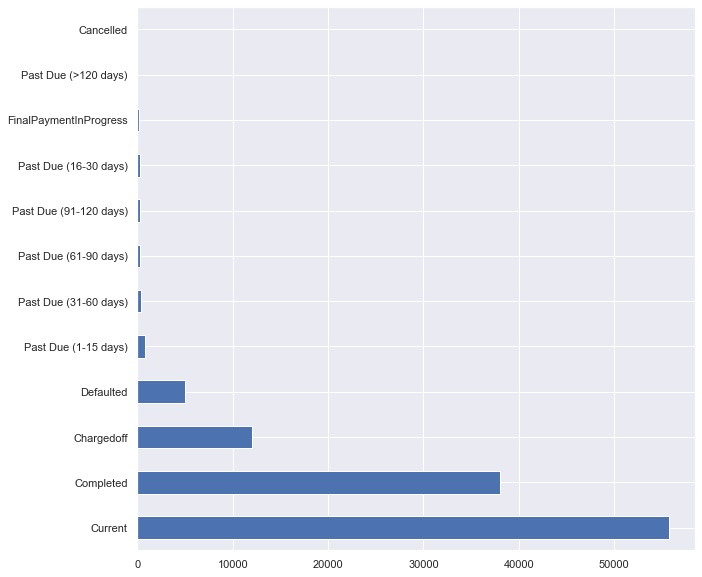

In [8]:
plt.figure(figsize=(10,10))
df_loans['LoanStatus'].value_counts().plot.barh()
plt.show()

C:\Users\m2021\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


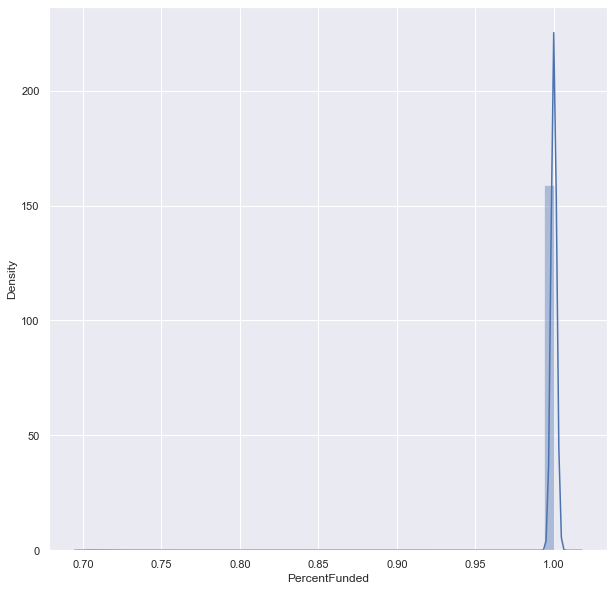

In [9]:
plt.figure(figsize=(10,10))
sns.distplot(df_loans['PercentFunded'])
plt.show()

C:\Users\m2021\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


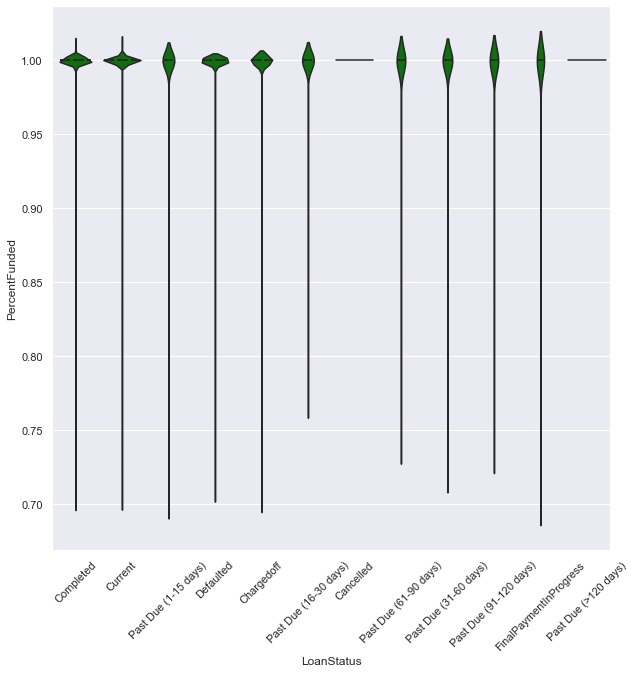

In [10]:
plt.figure(figsize=(10,10))
sns.violinplot( df_loans['LoanStatus'], df_loans['PercentFunded'], inner='quartile', color='green')
plt.xticks(rotation=45)
plt.show()

In [11]:
df_loans.groupby('LoanStatus')['PercentFunded'].describe()

,count,mean,std,min,25%,50%,75%,max
LoanStatus,,,,,,,,
Cancelled,5.0,1.000000,0.000000,1.0000,1.0,1.0,1.0,1.0000
Chargedoff,11992.0,0.997808,0.022167,0.7012,1.0,1.0,1.0,1.0000
Completed,38061.0,0.998701,0.017362,0.7000,1.0,1.0,1.0,1.0110
Current,55730.0,0.998644,0.017466,0.7000,1.0,1.0,1.0,1.0125
Defaulted,5018.0,0.999261,0.013197,0.7063,1.0,1.0,1.0,1.0000
FinalPaymentInProgress,203.0,0.996444,0.028813,0.7055,1.0,1.0,1.0,1.0000
Past Due (1-15 days),800.0,0.997521,0.023257,0.7024,1.0,1.0,1.0,1.0000
Past Due (16-30 days),265.0,0.997878,0.018921,0.7706,1.0,1.0,1.0,1.0000
Past Due (31-60 days),361.0,0.997494,0.024194,0.7227,1.0,1.0,1.0,1.0000


In [12]:
df_loans[stillmiss].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113066 entries, 0 to 113065
Data columns (total 19 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   ClosedDate                           55076 non-null   object 
 1   EstimatedEffectiveYield              83982 non-null   float32
 2   EstimatedLoss                        83982 non-null   float32
 3   EstimatedReturn                      83982 non-null   float32
 4   ProsperRating (numeric)              83982 non-null   float32
 5   ProsperRating (Alpha)                83982 non-null   object 
 6   ProsperScore                         83982 non-null   float32
 7   GroupKey                             13339 non-null   object 
 8   TotalProsperLoans                    21923 non-null   float32
 9   TotalProsperPaymentsBilled           21923 non-null   float32
 10  OnTimeProsperPayments                21923 non-null   float32
 11  ProsperPaymen

C:\Users\m2021\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


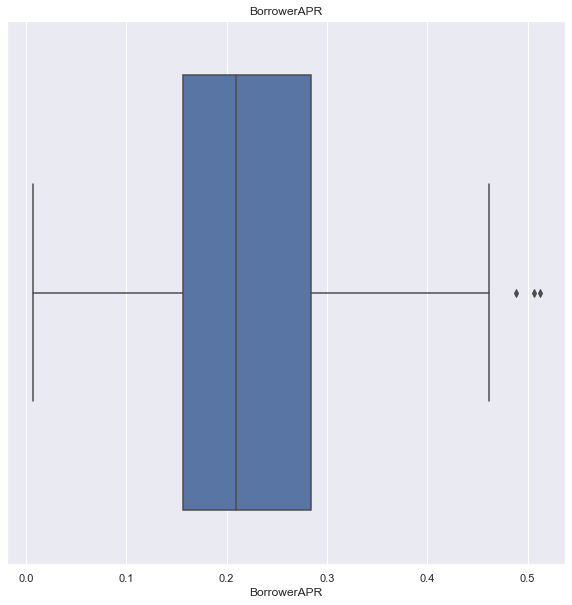

-------------------------------------------------------------------------------------------------------


C:\Users\m2021\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


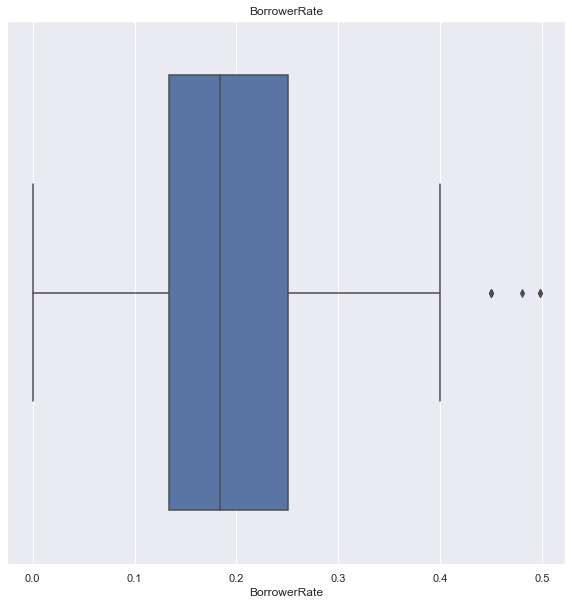

-------------------------------------------------------------------------------------------------------


C:\Users\m2021\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


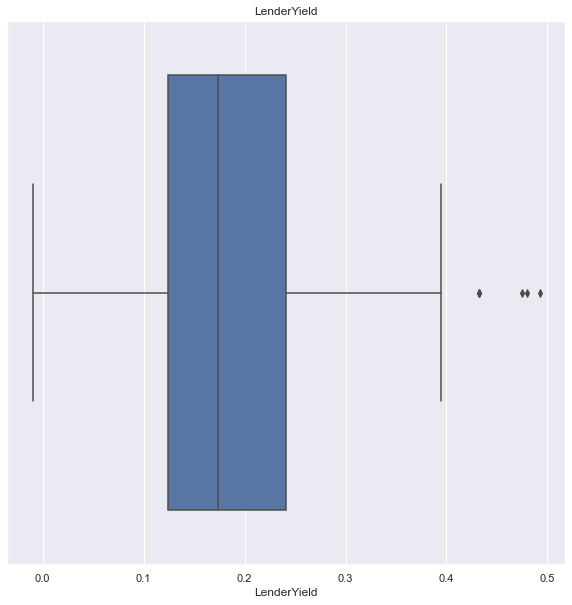

-------------------------------------------------------------------------------------------------------


C:\Users\m2021\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


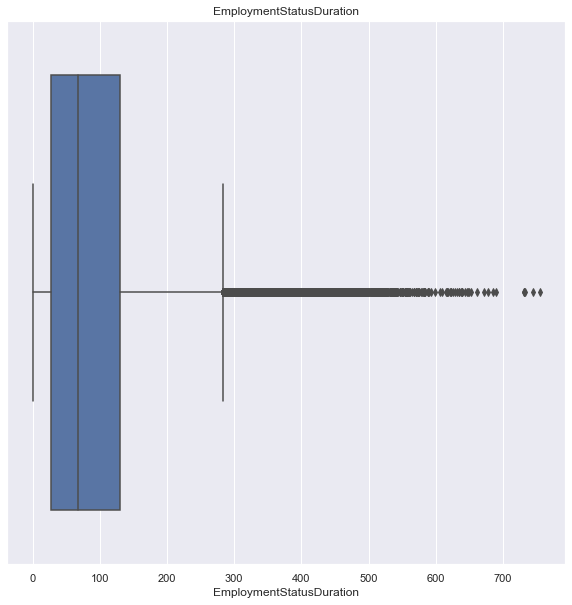

-------------------------------------------------------------------------------------------------------


C:\Users\m2021\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


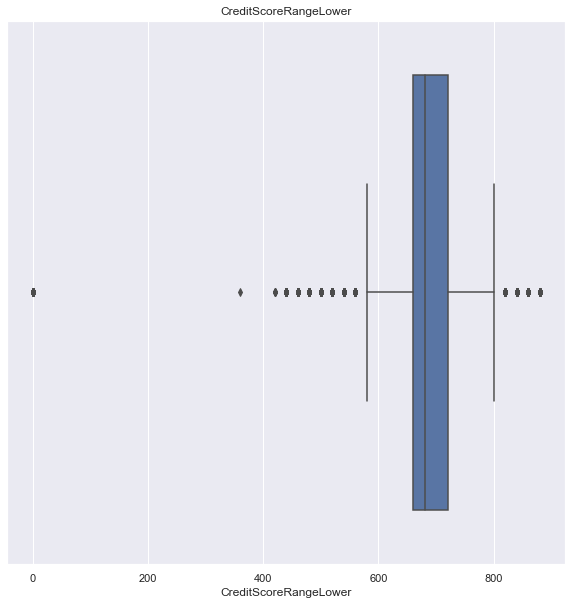

-------------------------------------------------------------------------------------------------------


C:\Users\m2021\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


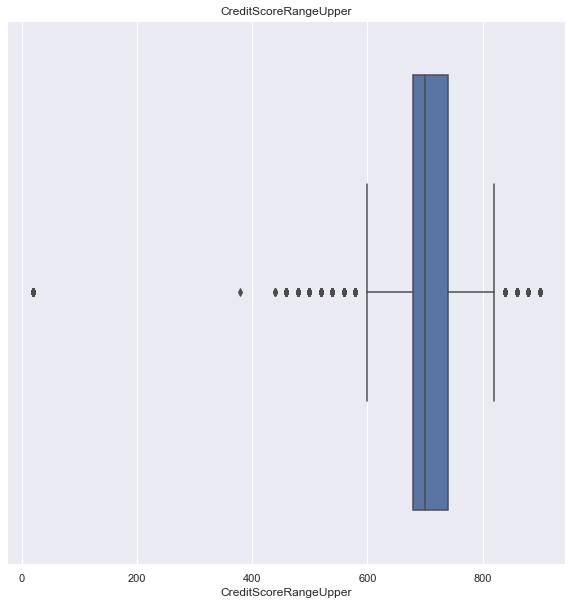

-------------------------------------------------------------------------------------------------------


C:\Users\m2021\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


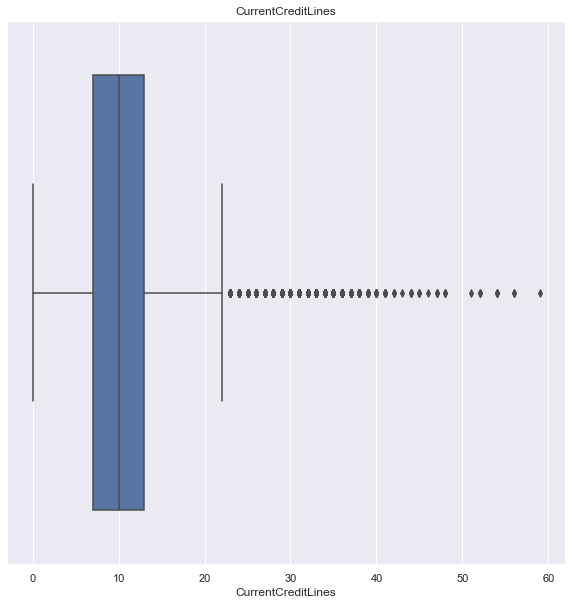

-------------------------------------------------------------------------------------------------------


C:\Users\m2021\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


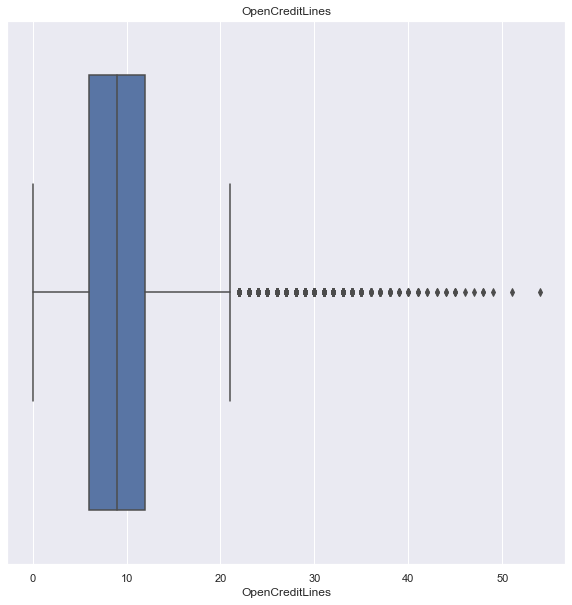

-------------------------------------------------------------------------------------------------------


C:\Users\m2021\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


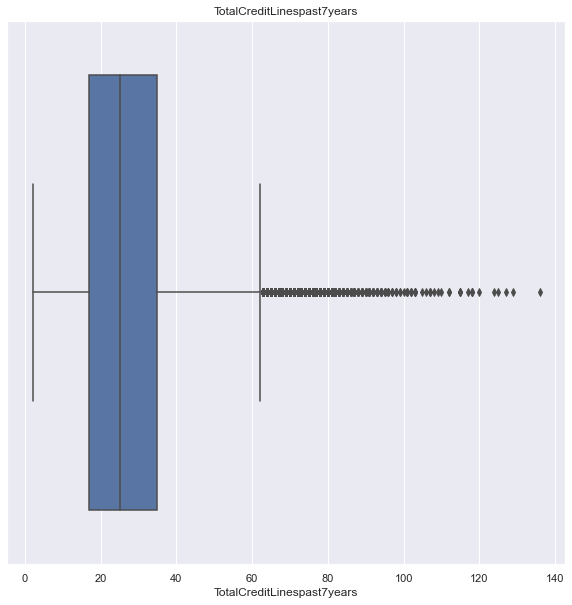

-------------------------------------------------------------------------------------------------------


C:\Users\m2021\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


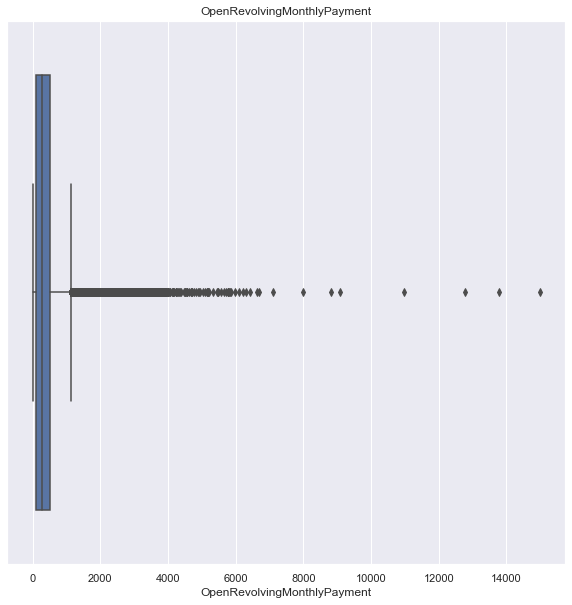

-------------------------------------------------------------------------------------------------------


C:\Users\m2021\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


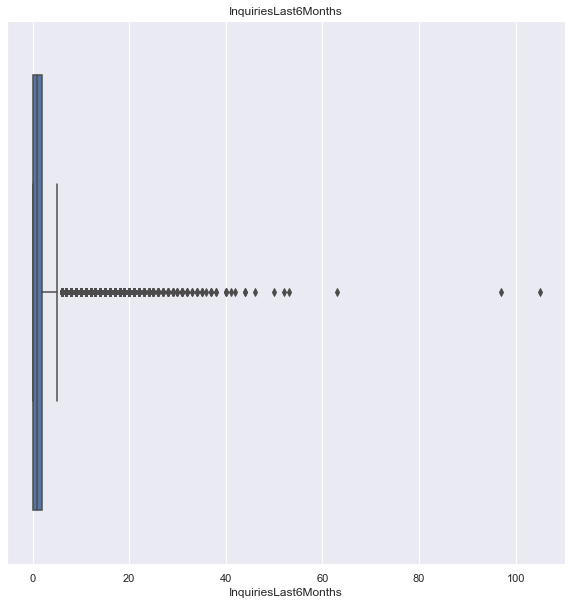

-------------------------------------------------------------------------------------------------------


C:\Users\m2021\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


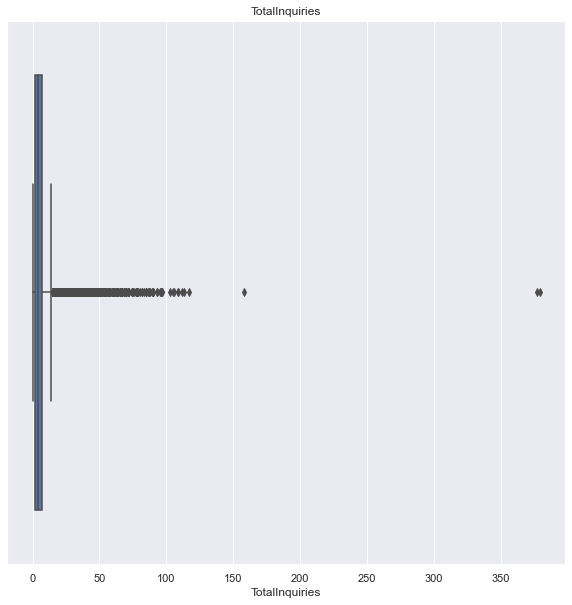

-------------------------------------------------------------------------------------------------------


C:\Users\m2021\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


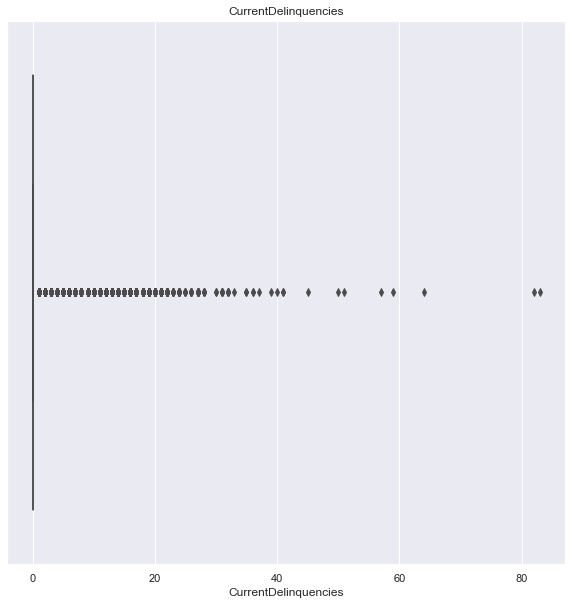

-------------------------------------------------------------------------------------------------------


C:\Users\m2021\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


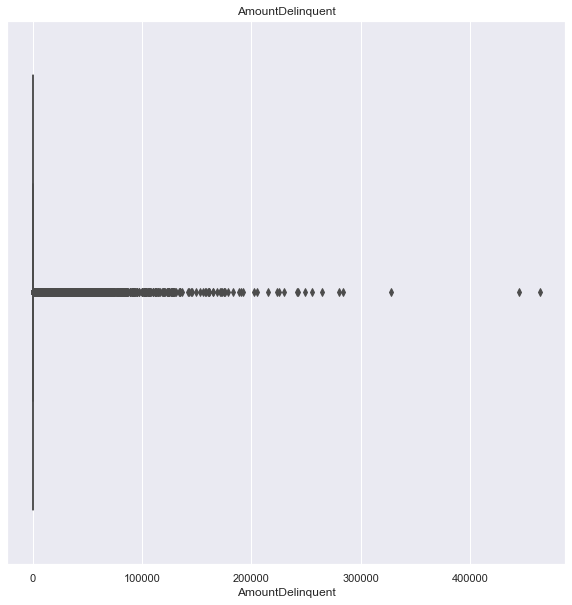

-------------------------------------------------------------------------------------------------------


C:\Users\m2021\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


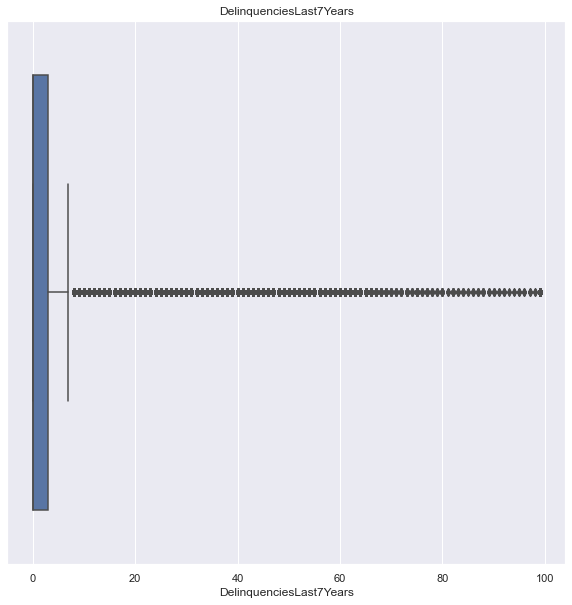

-------------------------------------------------------------------------------------------------------


C:\Users\m2021\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


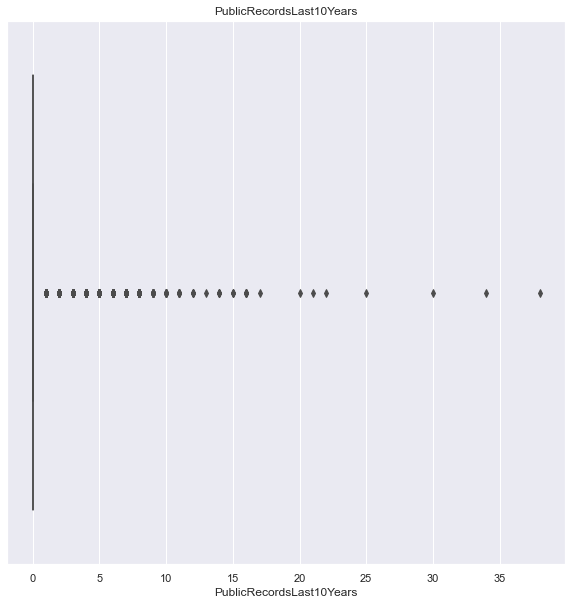

-------------------------------------------------------------------------------------------------------


C:\Users\m2021\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


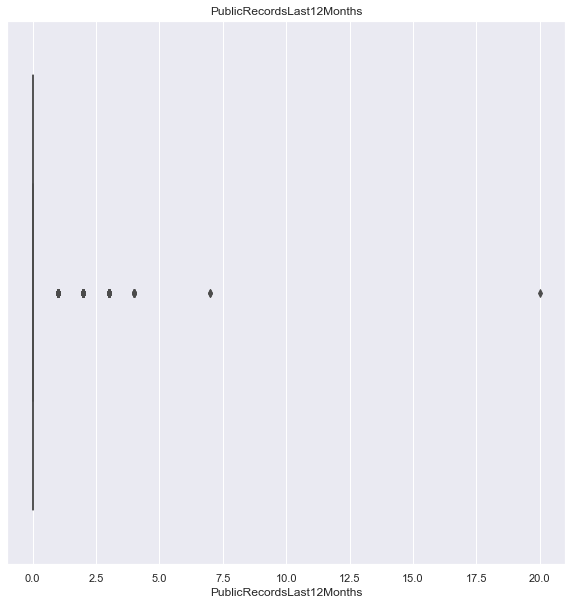

-------------------------------------------------------------------------------------------------------


C:\Users\m2021\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


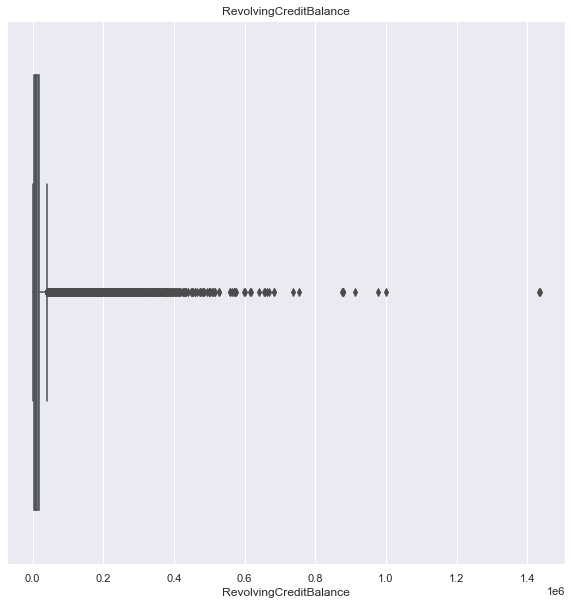

-------------------------------------------------------------------------------------------------------


C:\Users\m2021\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


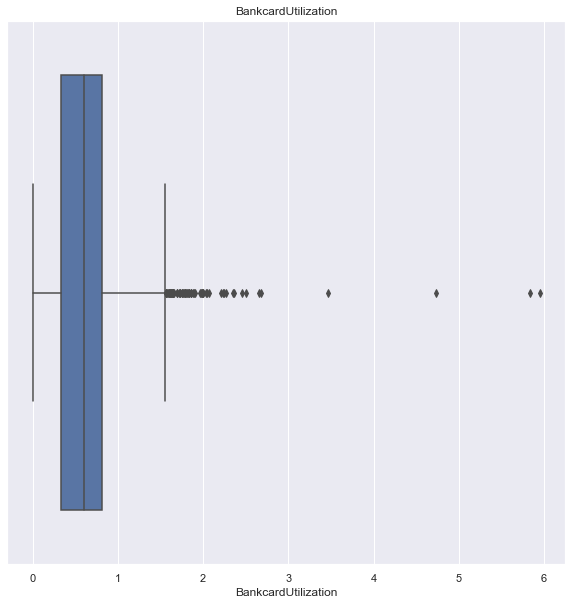

-------------------------------------------------------------------------------------------------------


C:\Users\m2021\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


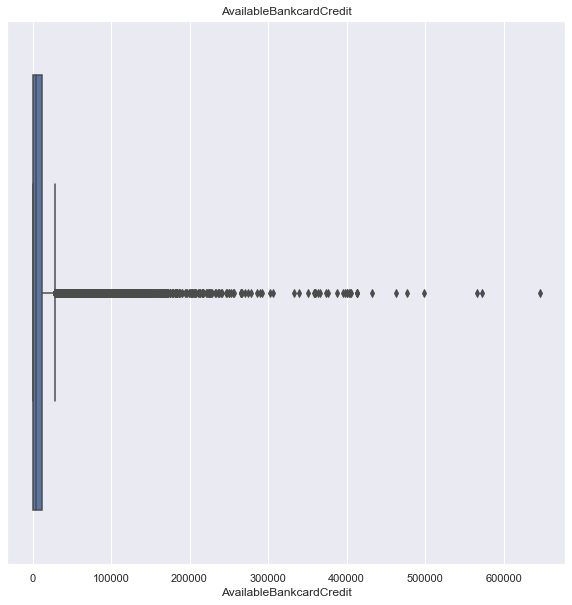

-------------------------------------------------------------------------------------------------------


C:\Users\m2021\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


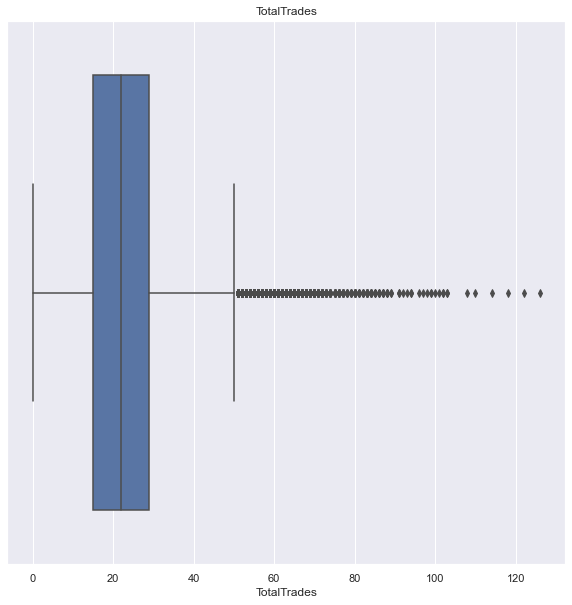

-------------------------------------------------------------------------------------------------------


C:\Users\m2021\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


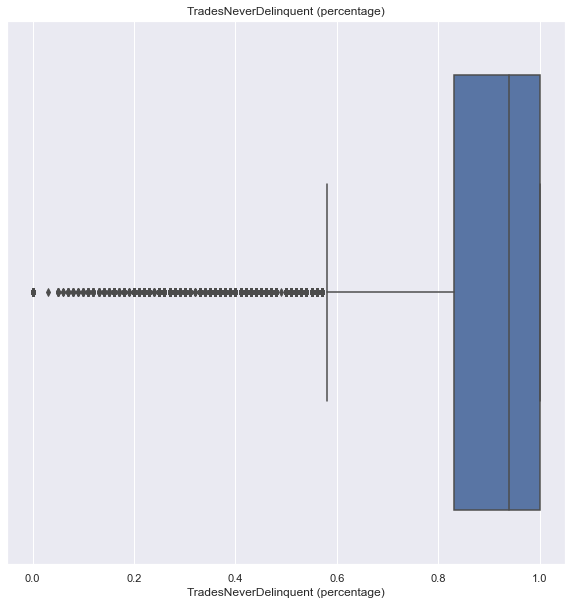

-------------------------------------------------------------------------------------------------------


C:\Users\m2021\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


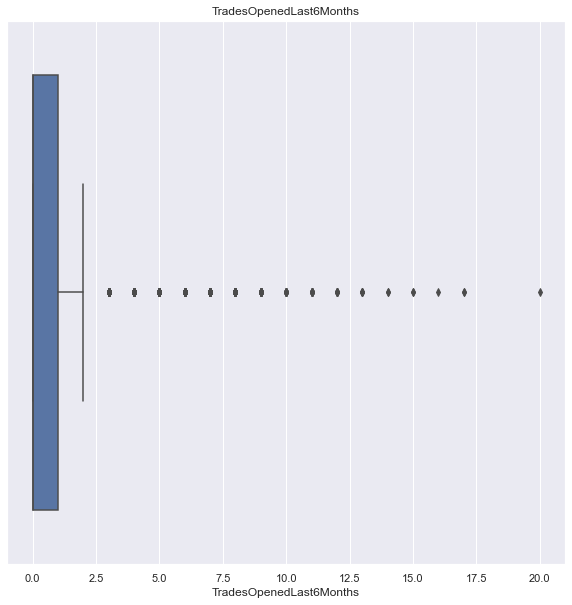

-------------------------------------------------------------------------------------------------------


C:\Users\m2021\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


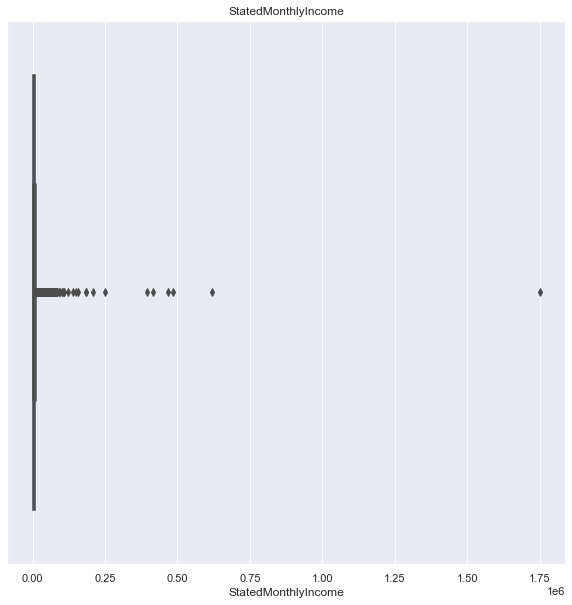

-------------------------------------------------------------------------------------------------------


C:\Users\m2021\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


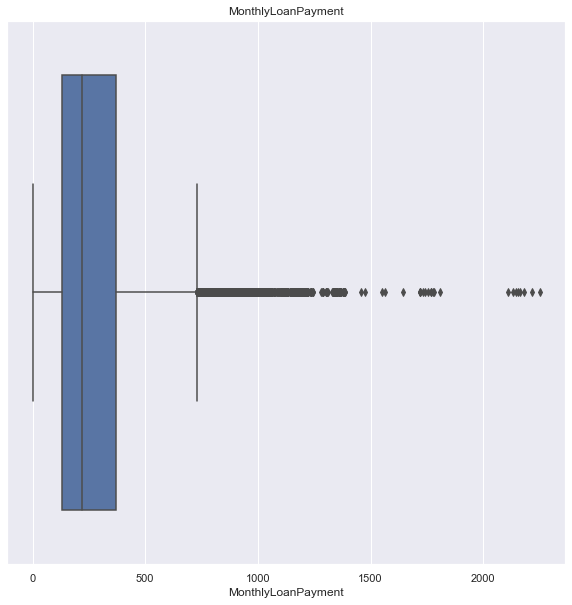

-------------------------------------------------------------------------------------------------------


C:\Users\m2021\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


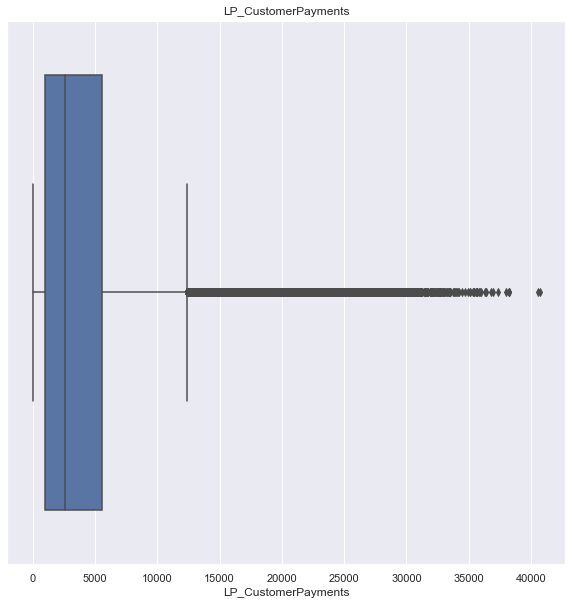

-------------------------------------------------------------------------------------------------------


C:\Users\m2021\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


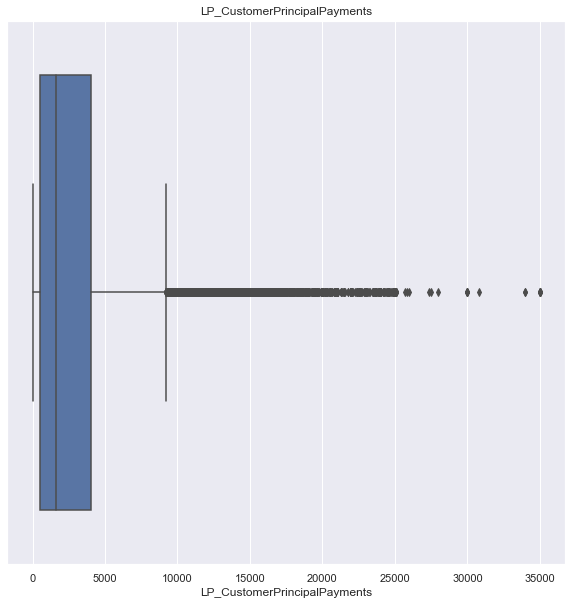

-------------------------------------------------------------------------------------------------------


C:\Users\m2021\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


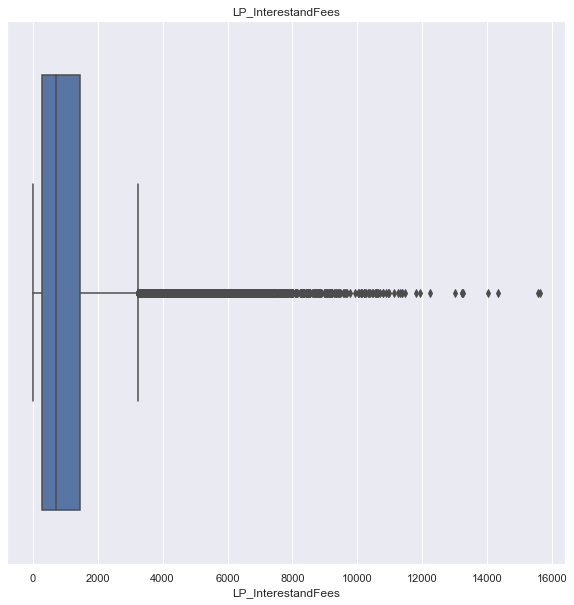

-------------------------------------------------------------------------------------------------------


C:\Users\m2021\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


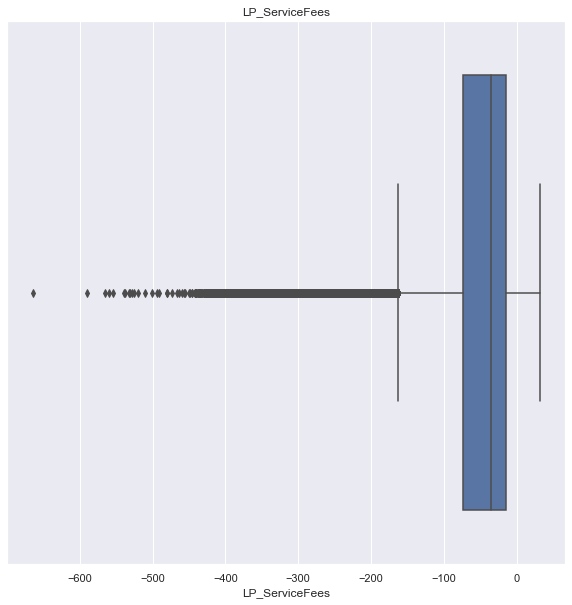

-------------------------------------------------------------------------------------------------------


C:\Users\m2021\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


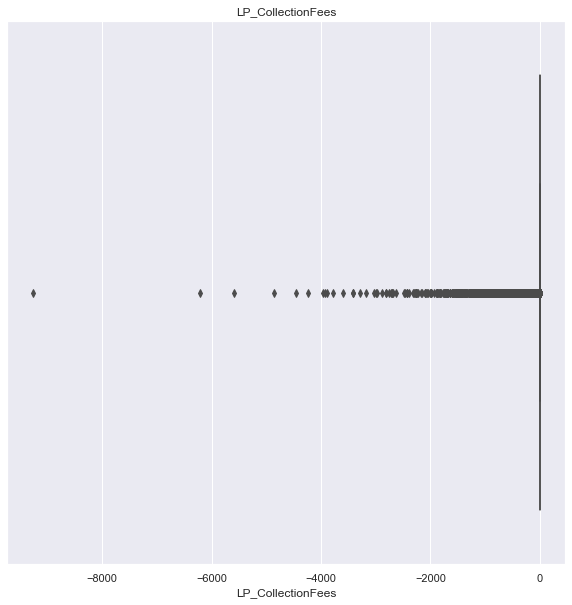

-------------------------------------------------------------------------------------------------------


C:\Users\m2021\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


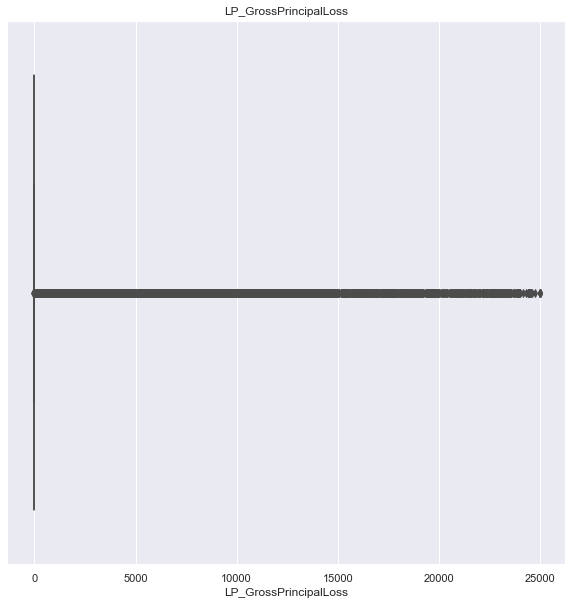

-------------------------------------------------------------------------------------------------------


C:\Users\m2021\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


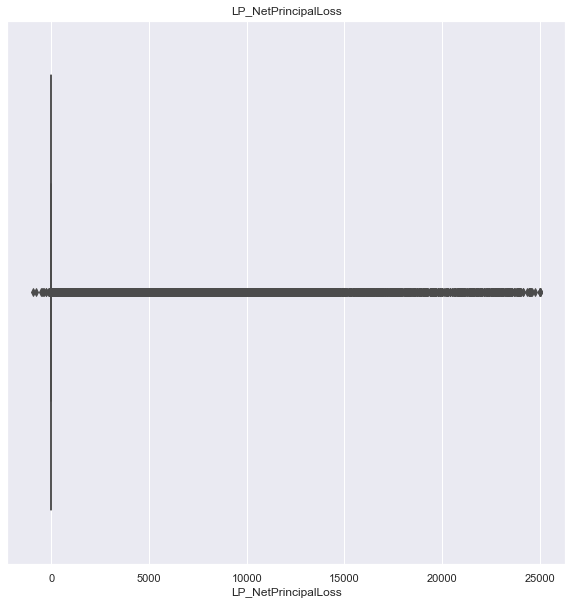

-------------------------------------------------------------------------------------------------------


C:\Users\m2021\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


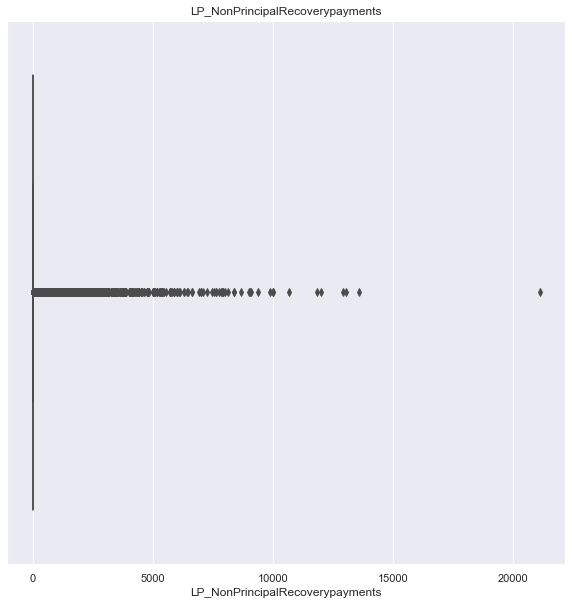

-------------------------------------------------------------------------------------------------------


C:\Users\m2021\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


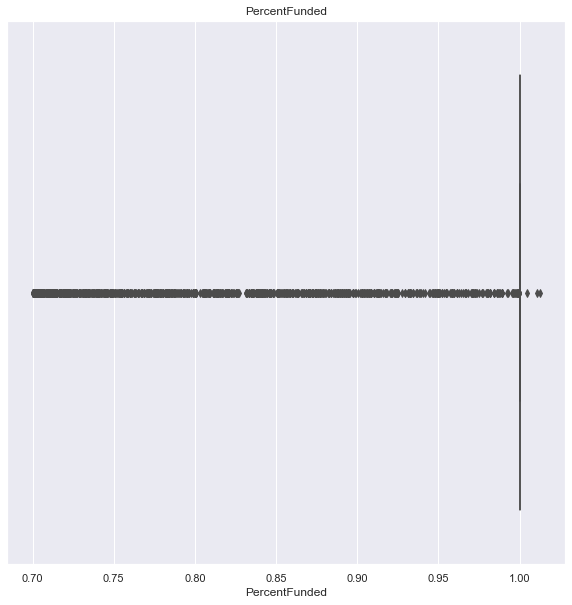

-------------------------------------------------------------------------------------------------------


C:\Users\m2021\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


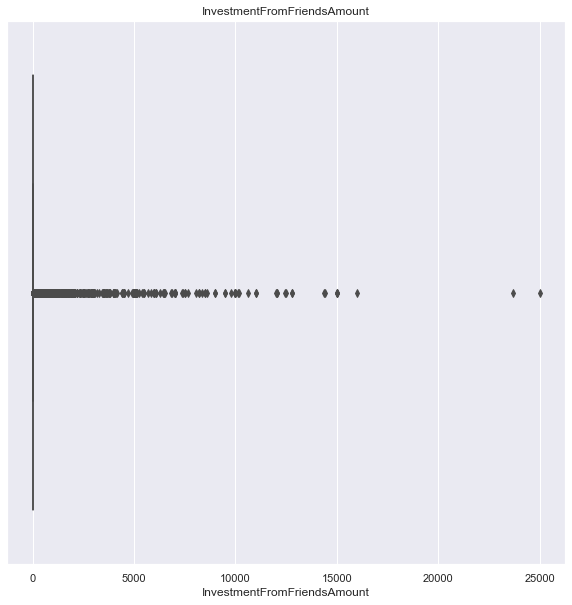

-------------------------------------------------------------------------------------------------------


C:\Users\m2021\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


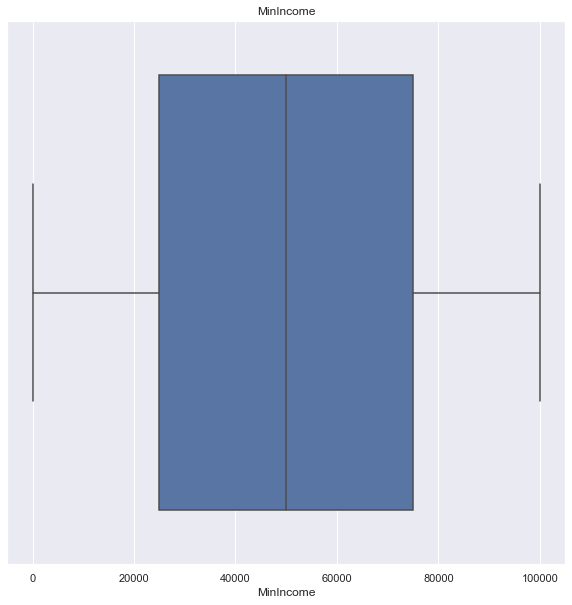

-------------------------------------------------------------------------------------------------------


C:\Users\m2021\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


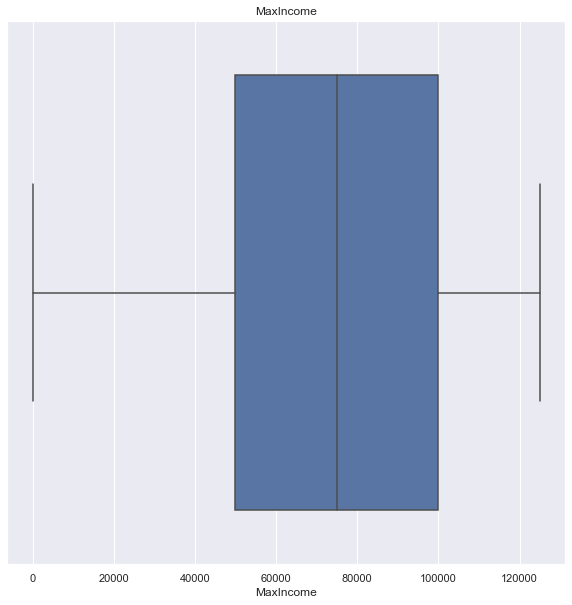

-------------------------------------------------------------------------------------------------------


In [13]:
for col in con_features:
    if col not in stillmiss:
        plt.figure(figsize=(10,10))
        sns.boxplot(df_loans[col])
        plt.title(col)
        plt.show()
        print('-------------------------------------------------------------------------------------------------------')

C:\Users\m2021\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


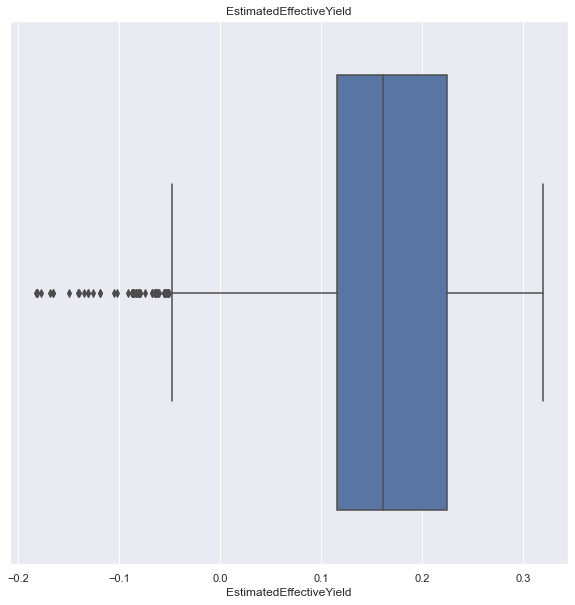

C:\Users\m2021\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


-------------------------------------------------------------------------------------------------------


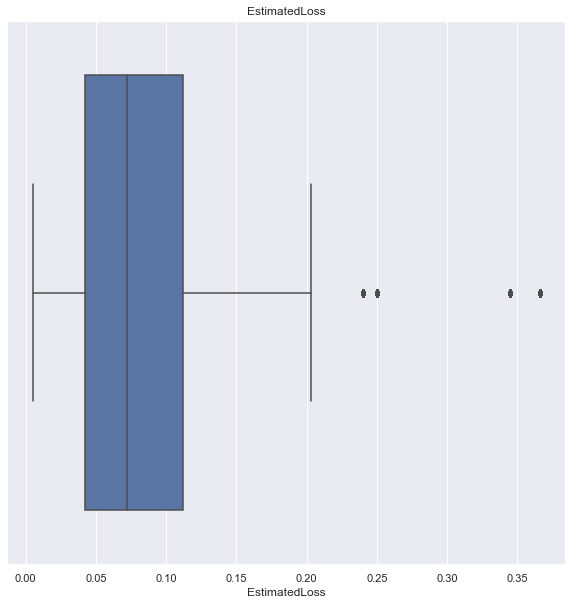

-------------------------------------------------------------------------------------------------------


C:\Users\m2021\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


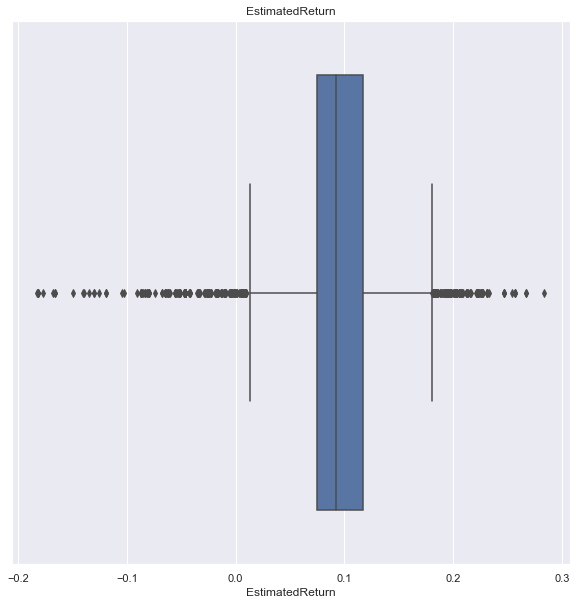

C:\Users\m2021\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


-------------------------------------------------------------------------------------------------------


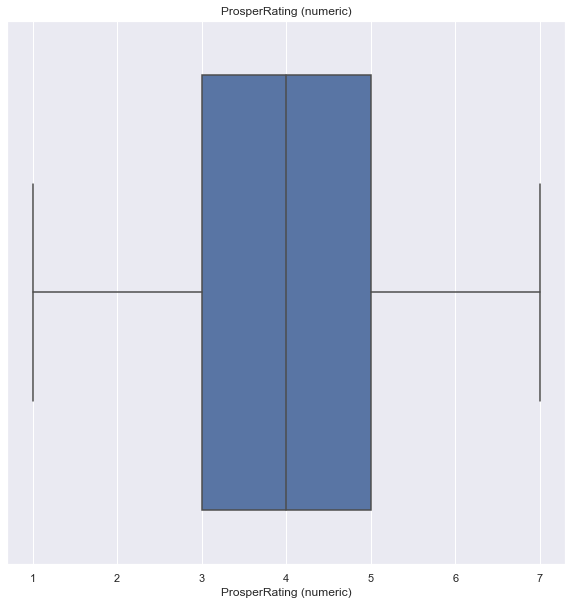

C:\Users\m2021\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


-------------------------------------------------------------------------------------------------------


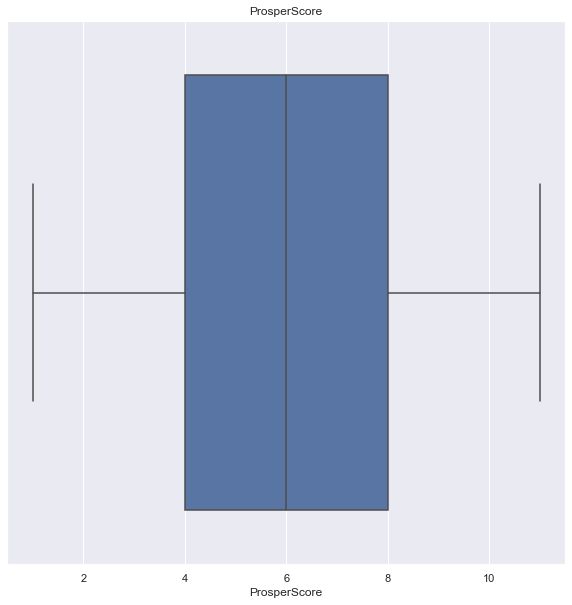

C:\Users\m2021\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


-------------------------------------------------------------------------------------------------------


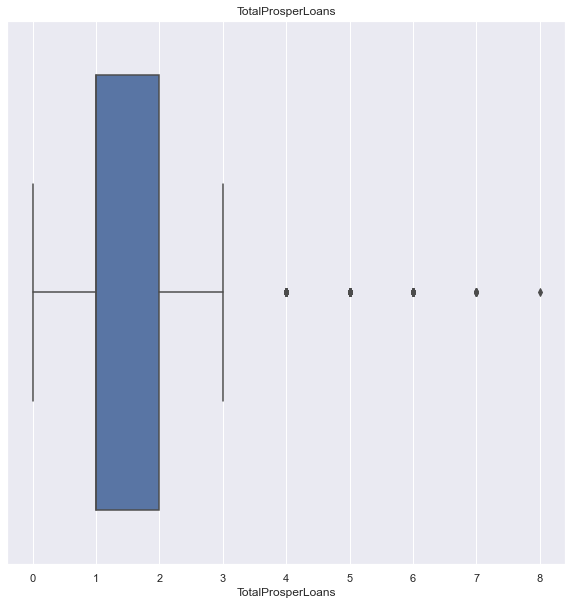

-------------------------------------------------------------------------------------------------------


C:\Users\m2021\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


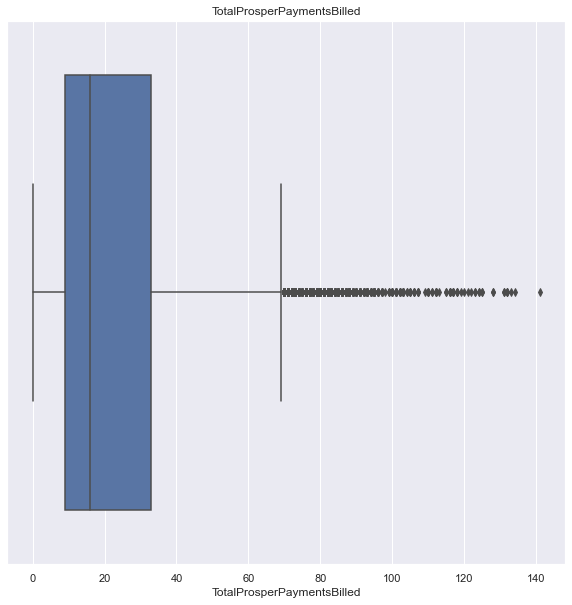

-------------------------------------------------------------------------------------------------------


C:\Users\m2021\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


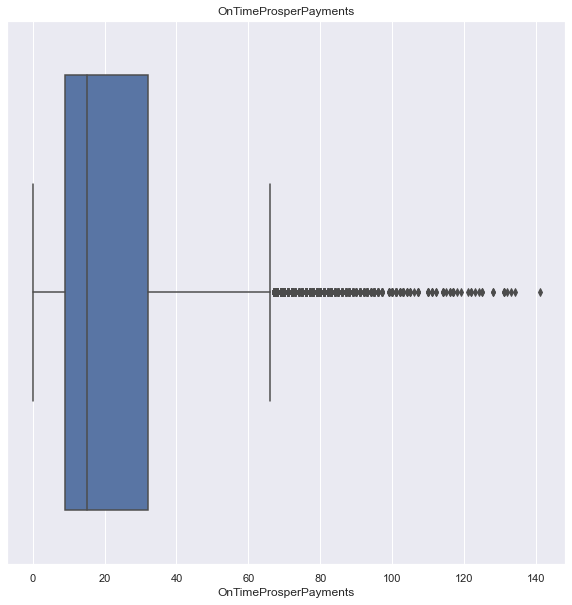

-------------------------------------------------------------------------------------------------------


C:\Users\m2021\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


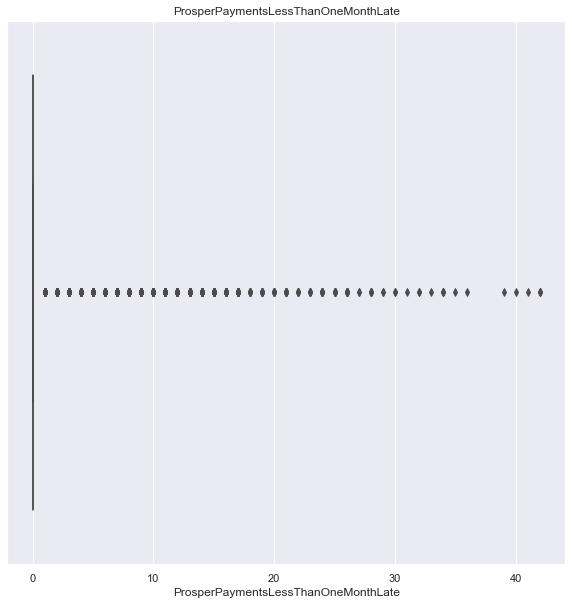

-------------------------------------------------------------------------------------------------------


C:\Users\m2021\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


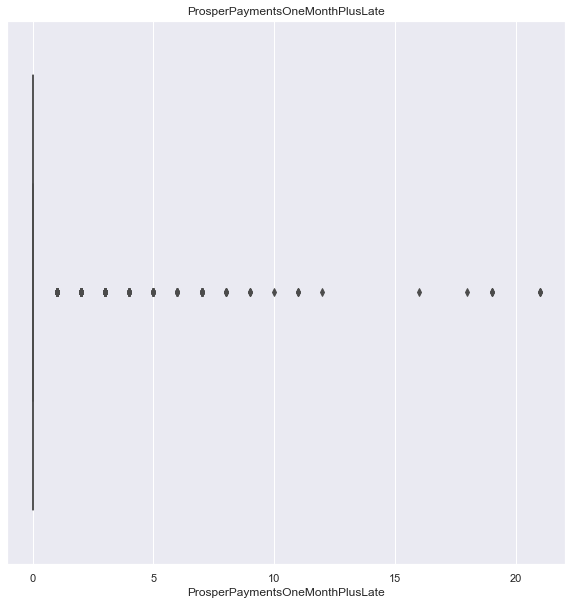

C:\Users\m2021\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


-------------------------------------------------------------------------------------------------------


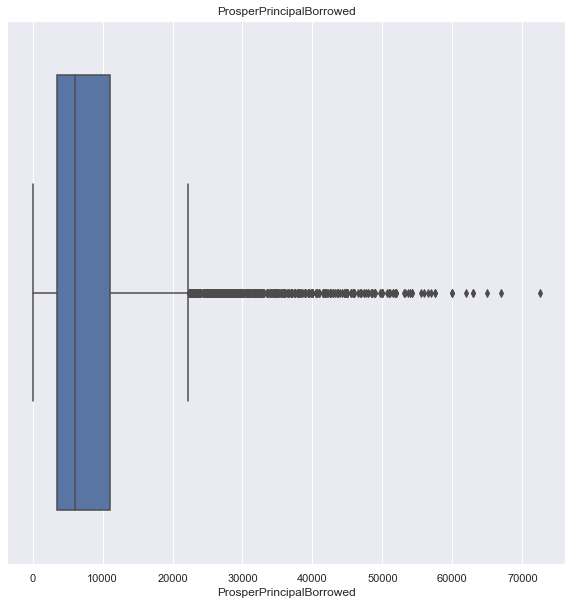

C:\Users\m2021\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


-------------------------------------------------------------------------------------------------------


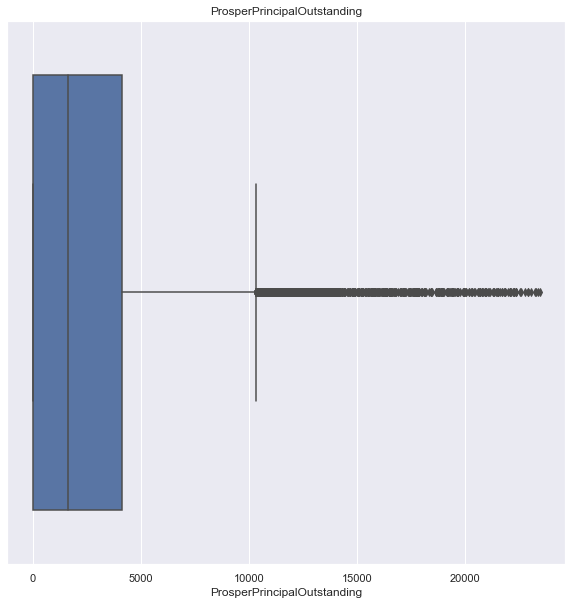

C:\Users\m2021\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


-------------------------------------------------------------------------------------------------------


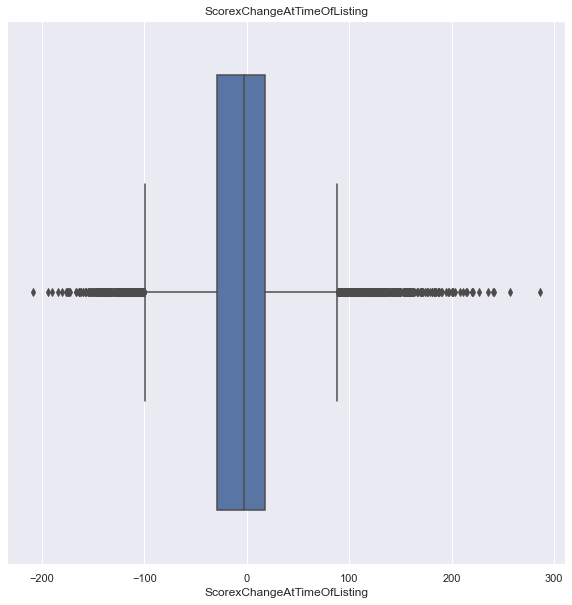

C:\Users\m2021\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


-------------------------------------------------------------------------------------------------------


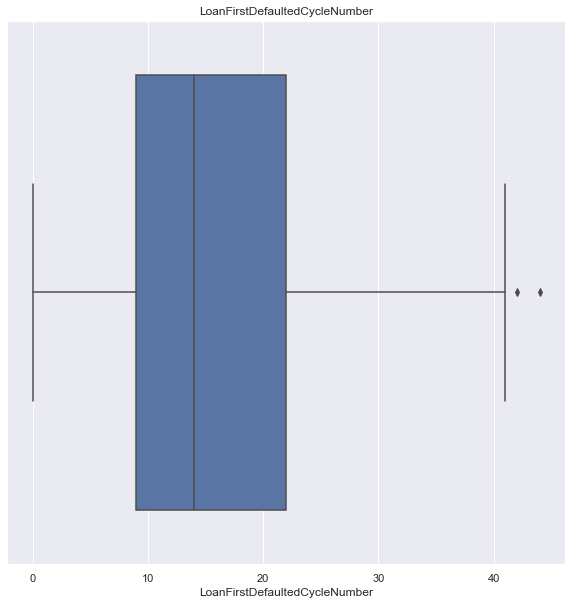

C:\Users\m2021\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


-------------------------------------------------------------------------------------------------------


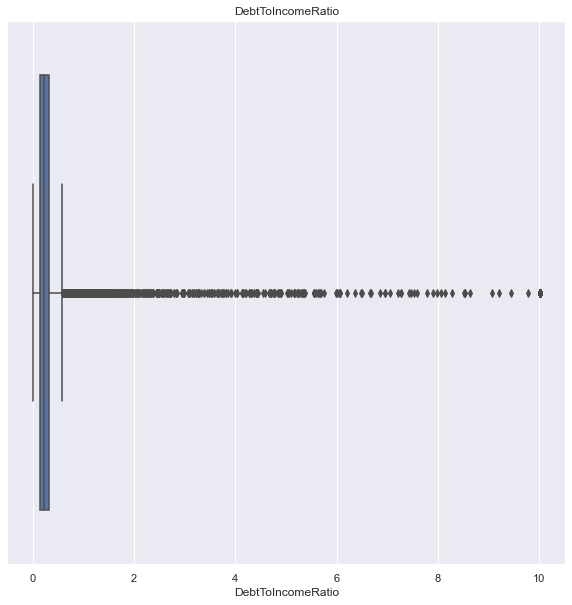

-------------------------------------------------------------------------------------------------------


In [18]:
for col in stillmiss:
    if df_loans[col].dtype == 'float32':
        plt.figure(figsize=(10,10))
        sns.boxplot(df_loans[col])
        plt.title(col)
        plt.show()
        print('-------------------------------------------------------------------------------------------------------')

In [19]:
df_loans[con_features].std()

BorrowerAPR                                0.080475
BorrowerRate                               0.074916
LenderYield                                0.074610
EstimatedEffectiveYield                    0.068608
EstimatedLoss                              0.046852
EstimatedReturn                            0.030473
ProsperRating (numeric)                    1.675635
ProsperScore                               2.373517
EmploymentStatusDuration                  91.475372
CreditScoreRangeLower                     66.463211
CreditScoreRangeUpper                     66.449883
CurrentCreditLines                         5.271513
OpenCreditLines                            4.849735
TotalCreditLinespast7years                13.602557
OpenRevolvingMonthlyPayment              447.650452
InquiriesLast6Months                       2.436478
TotalInquiries                             6.415864
CurrentDelinquencies                       1.977781
AmountDelinquent                        6915.965332
Delinquencie

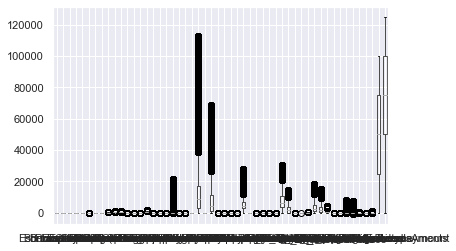

In [21]:
# Find the mean and standard dev
std = df_loans[con_features].std()
mean = df_loans[con_features].mean()

# Calculate the cutoff
cut_off = std * 3
lower, upper = mean - cut_off, mean + cut_off

# Trim the outliers
trimmed_df = df_loans[(df_loans[con_features] < upper) & (df_loans[con_features] > lower)]

# The trimmed box plot
trimmed_df[con_features].boxplot()
plt.show()

In [40]:
mask_up = (df_loans[con_features] > upper) 
mask_down =(df_loans[con_features] < lower)

In [41]:
mask_up.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113066 entries, 0 to 113065
Data columns (total 52 columns):
 #   Column                               Non-Null Count   Dtype
---  ------                               --------------   -----
 0   BorrowerAPR                          113066 non-null  bool 
 1   BorrowerRate                         113066 non-null  bool 
 2   LenderYield                          113066 non-null  bool 
 3   EstimatedEffectiveYield              113066 non-null  bool 
 4   EstimatedLoss                        113066 non-null  bool 
 5   EstimatedReturn                      113066 non-null  bool 
 6   ProsperRating (numeric)              113066 non-null  bool 
 7   ProsperScore                         113066 non-null  bool 
 8   EmploymentStatusDuration             113066 non-null  bool 
 9   CreditScoreRangeLower                113066 non-null  bool 
 10  CreditScoreRangeUpper                113066 non-null  bool 
 11  CurrentCreditLines                   11

In [42]:
mask_down.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113066 entries, 0 to 113065
Data columns (total 52 columns):
 #   Column                               Non-Null Count   Dtype
---  ------                               --------------   -----
 0   BorrowerAPR                          113066 non-null  bool 
 1   BorrowerRate                         113066 non-null  bool 
 2   LenderYield                          113066 non-null  bool 
 3   EstimatedEffectiveYield              113066 non-null  bool 
 4   EstimatedLoss                        113066 non-null  bool 
 5   EstimatedReturn                      113066 non-null  bool 
 6   ProsperRating (numeric)              113066 non-null  bool 
 7   ProsperScore                         113066 non-null  bool 
 8   EmploymentStatusDuration             113066 non-null  bool 
 9   CreditScoreRangeLower                113066 non-null  bool 
 10  CreditScoreRangeUpper                113066 non-null  bool 
 11  CurrentCreditLines                   11

In [43]:
data = df_loans.copy()

In [44]:
for col in con_features:
    for i in range(data.shape[0]):
        if mask_up[col].iloc[i] == True:
            data[col].iloc[i] = upper[col]
        elif mask_down[col].iloc[i] == True:
            data[col].iloc[i] = lower[col]

C:\Users\m2021\anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


C:\Users\m2021\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


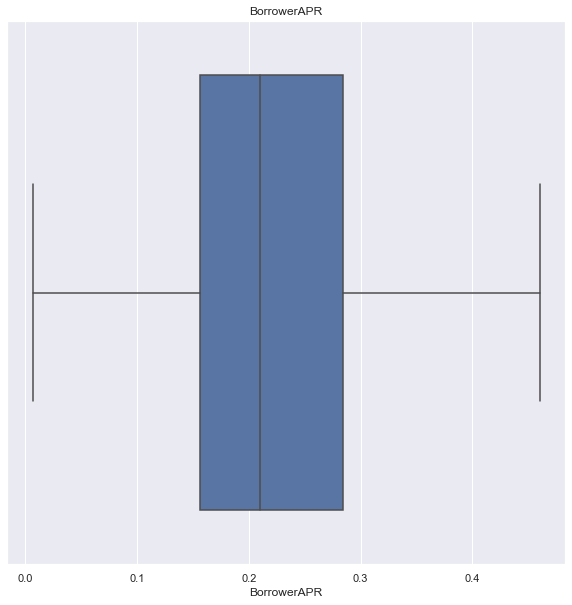

C:\Users\m2021\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


-------------------------------------------------------------------------------------------------------


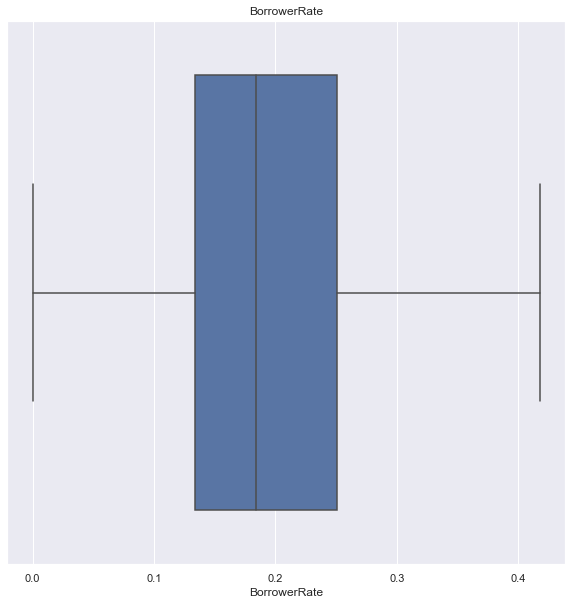

-------------------------------------------------------------------------------------------------------


C:\Users\m2021\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


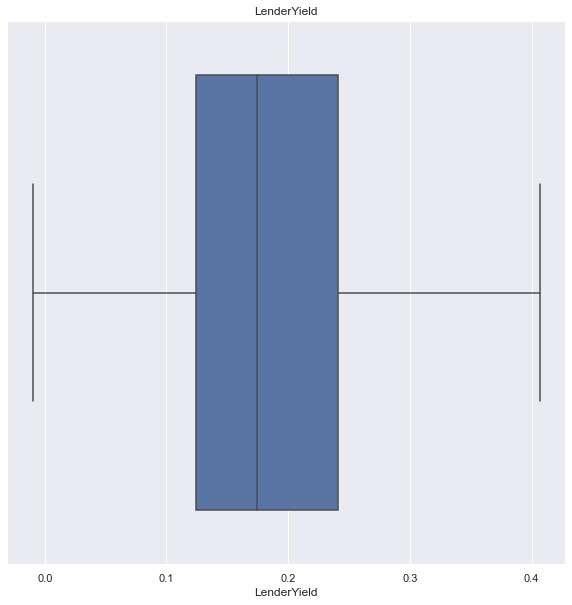

C:\Users\m2021\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


-------------------------------------------------------------------------------------------------------


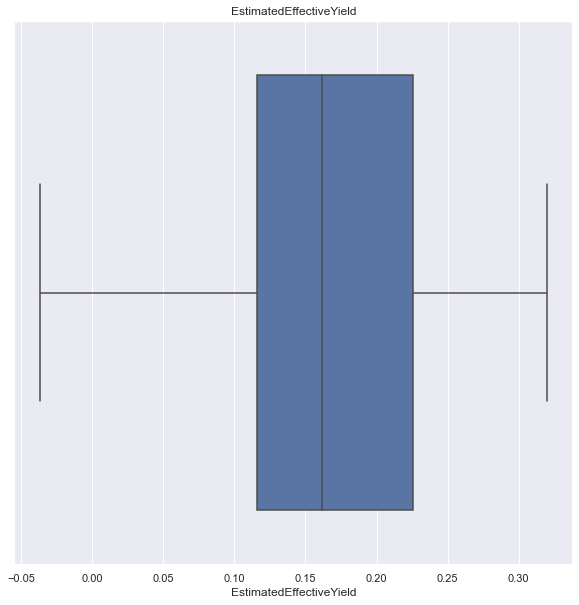

C:\Users\m2021\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


-------------------------------------------------------------------------------------------------------


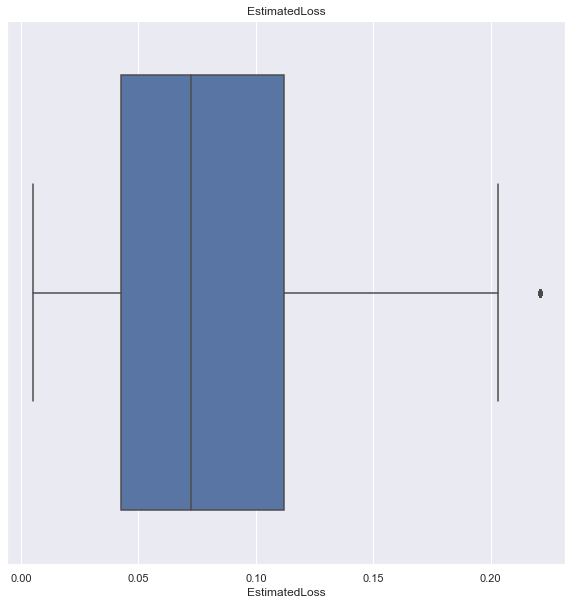

C:\Users\m2021\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


-------------------------------------------------------------------------------------------------------


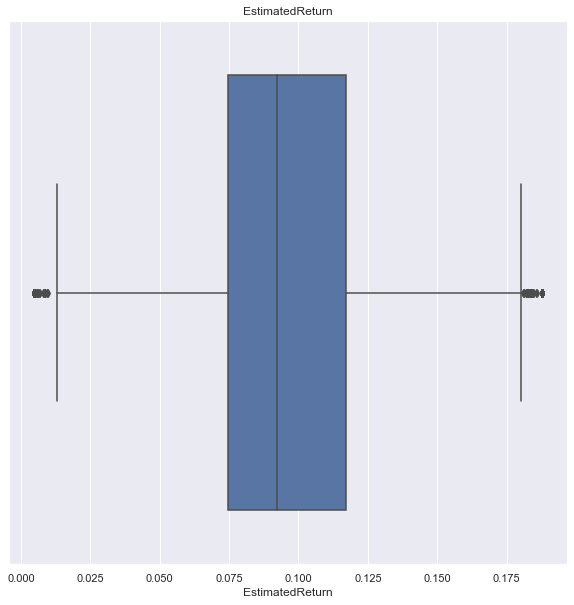

C:\Users\m2021\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


-------------------------------------------------------------------------------------------------------


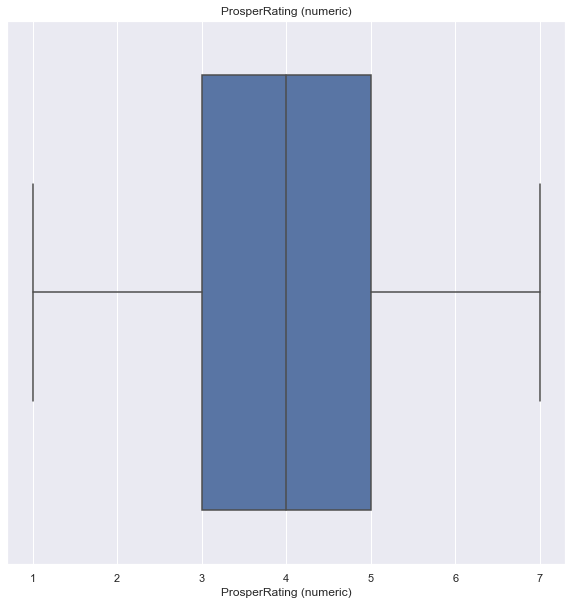

-------------------------------------------------------------------------------------------------------


C:\Users\m2021\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


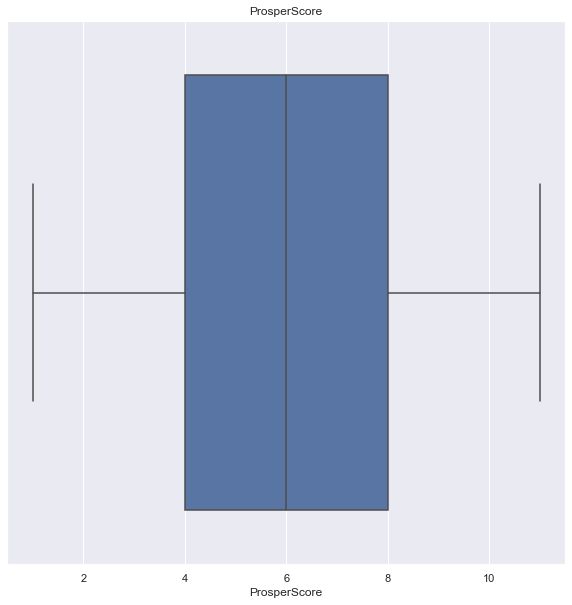

-------------------------------------------------------------------------------------------------------


C:\Users\m2021\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


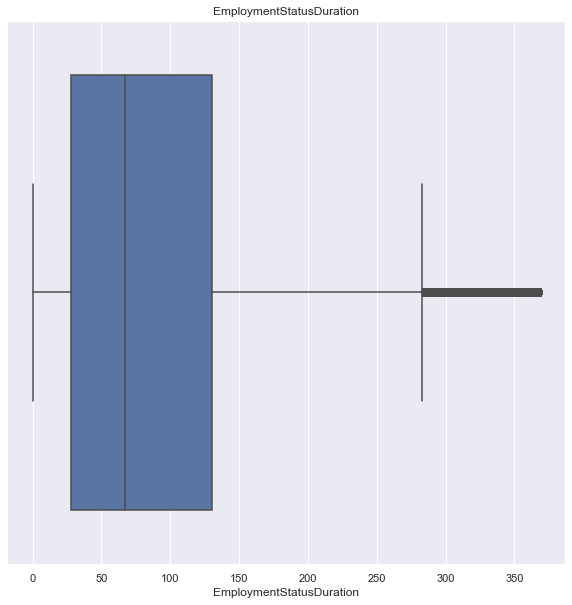

-------------------------------------------------------------------------------------------------------


C:\Users\m2021\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


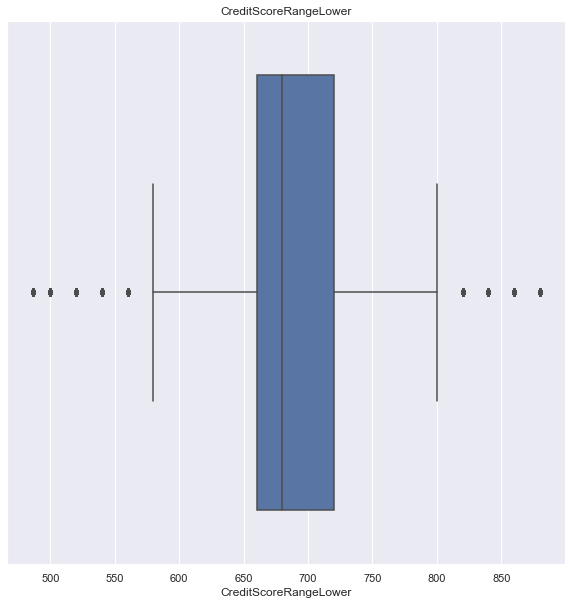

C:\Users\m2021\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


-------------------------------------------------------------------------------------------------------


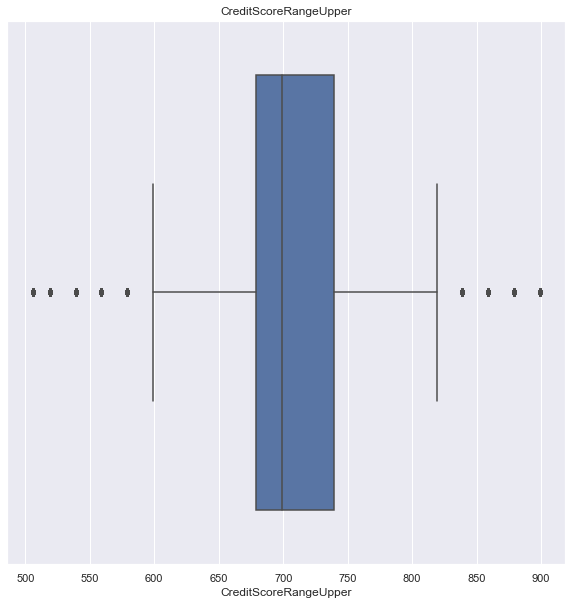

C:\Users\m2021\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


-------------------------------------------------------------------------------------------------------


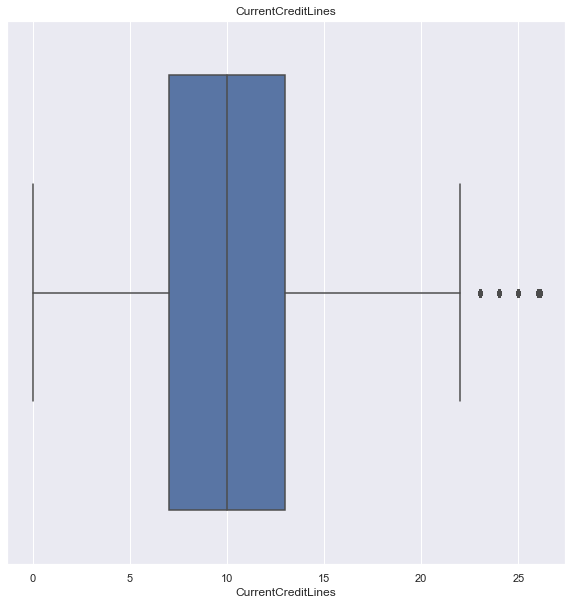

C:\Users\m2021\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


-------------------------------------------------------------------------------------------------------


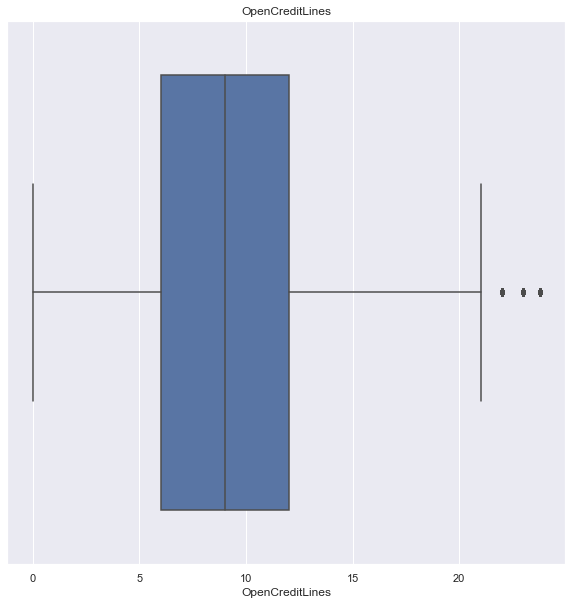

C:\Users\m2021\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


-------------------------------------------------------------------------------------------------------


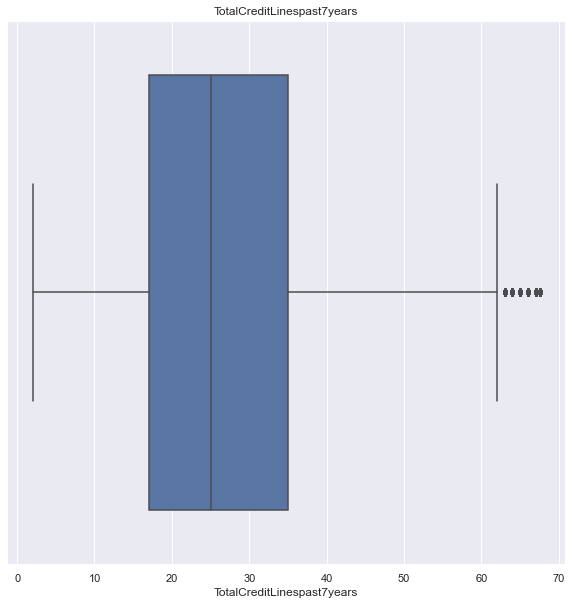

-------------------------------------------------------------------------------------------------------


C:\Users\m2021\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


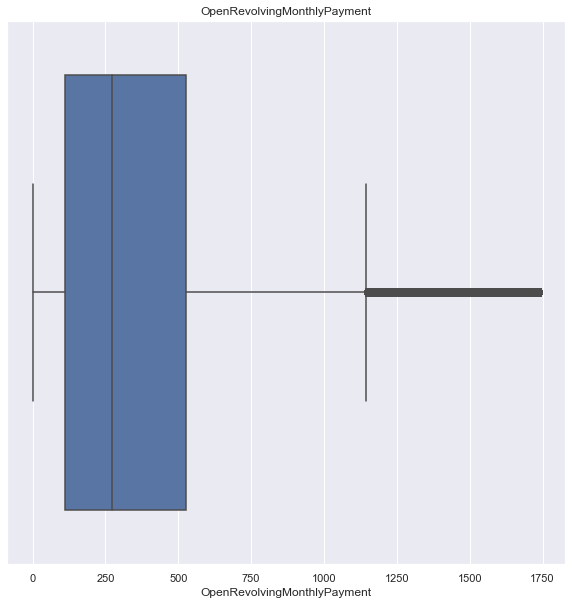

-------------------------------------------------------------------------------------------------------


C:\Users\m2021\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


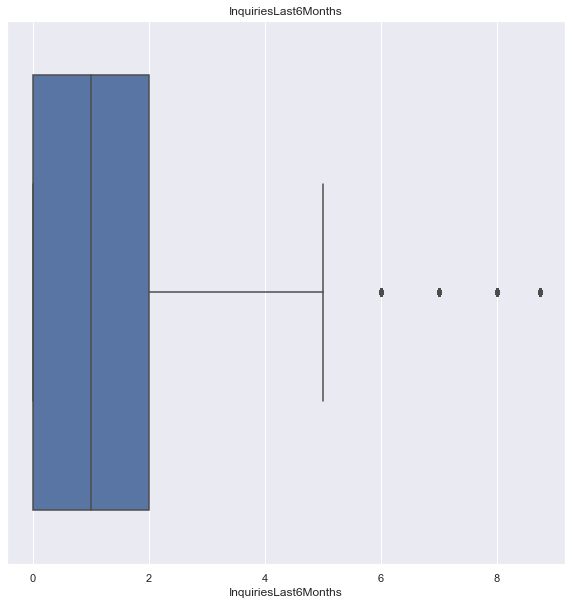

C:\Users\m2021\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


-------------------------------------------------------------------------------------------------------


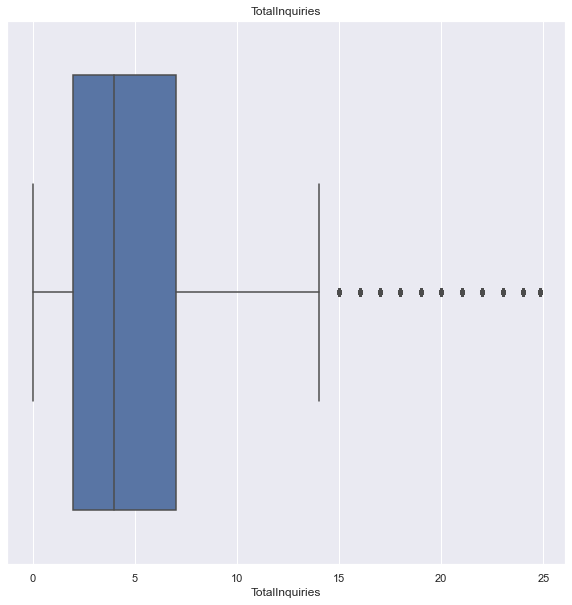

C:\Users\m2021\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


-------------------------------------------------------------------------------------------------------


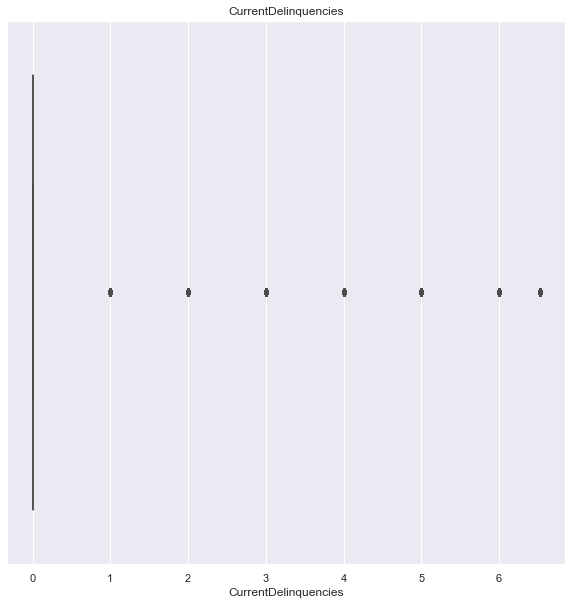

-------------------------------------------------------------------------------------------------------


C:\Users\m2021\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


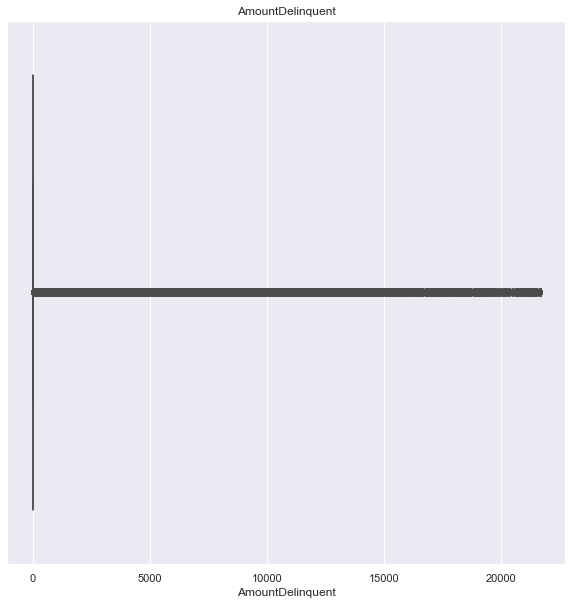

-------------------------------------------------------------------------------------------------------


C:\Users\m2021\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


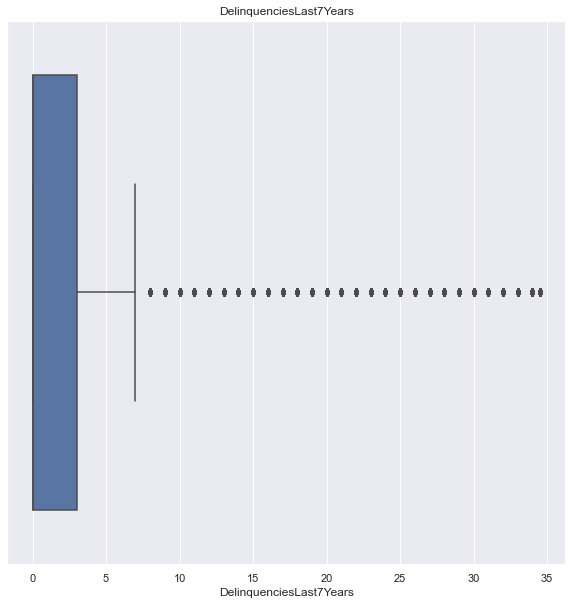

-------------------------------------------------------------------------------------------------------


C:\Users\m2021\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


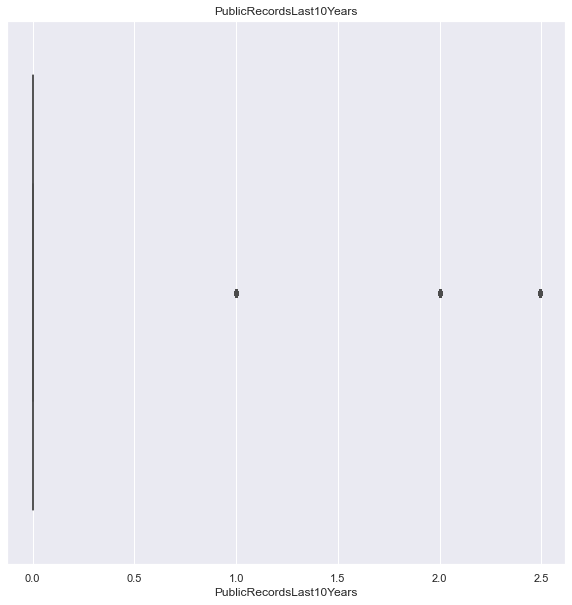

-------------------------------------------------------------------------------------------------------


C:\Users\m2021\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


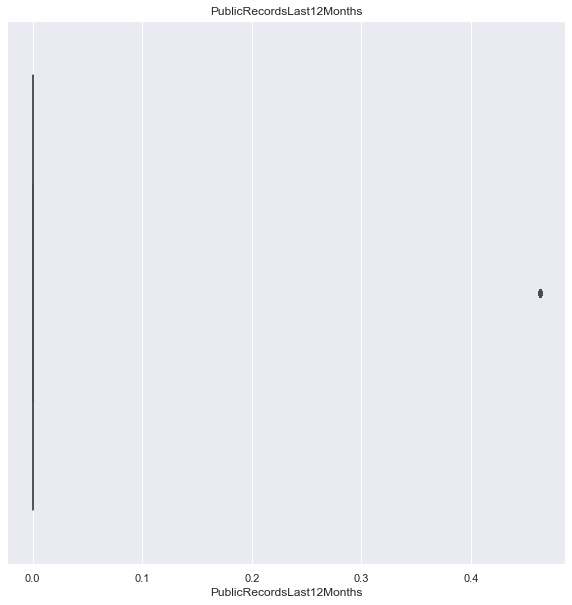

-------------------------------------------------------------------------------------------------------


C:\Users\m2021\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


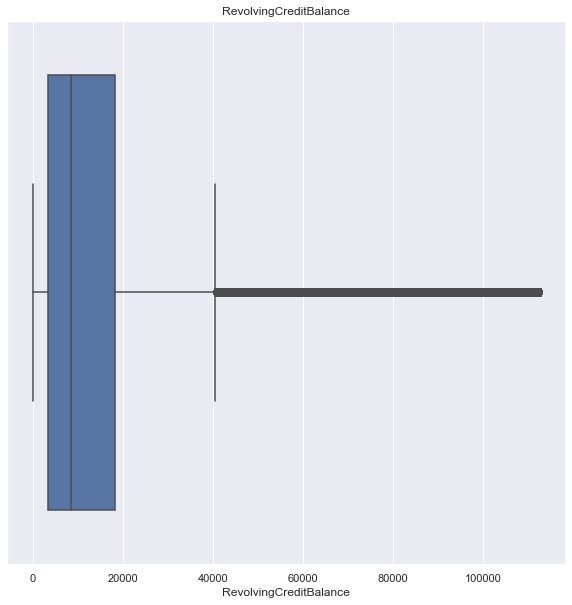

-------------------------------------------------------------------------------------------------------


C:\Users\m2021\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


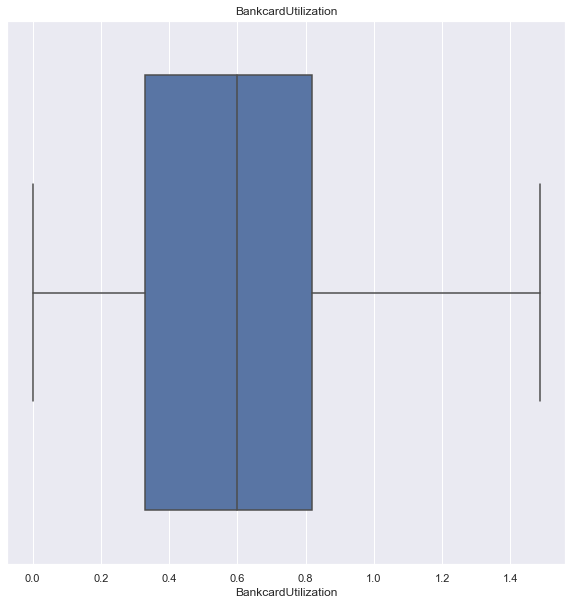

-------------------------------------------------------------------------------------------------------


C:\Users\m2021\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


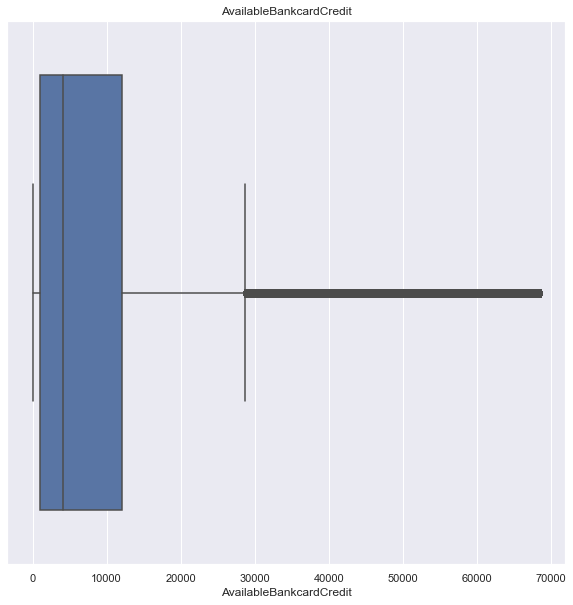

-------------------------------------------------------------------------------------------------------


C:\Users\m2021\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


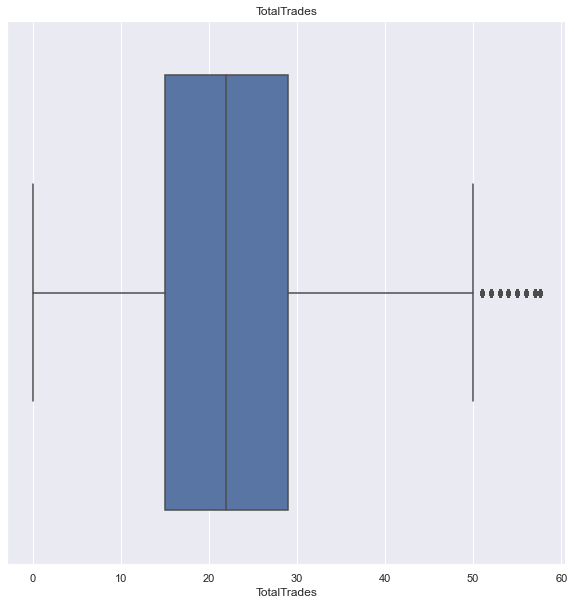

C:\Users\m2021\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


-------------------------------------------------------------------------------------------------------


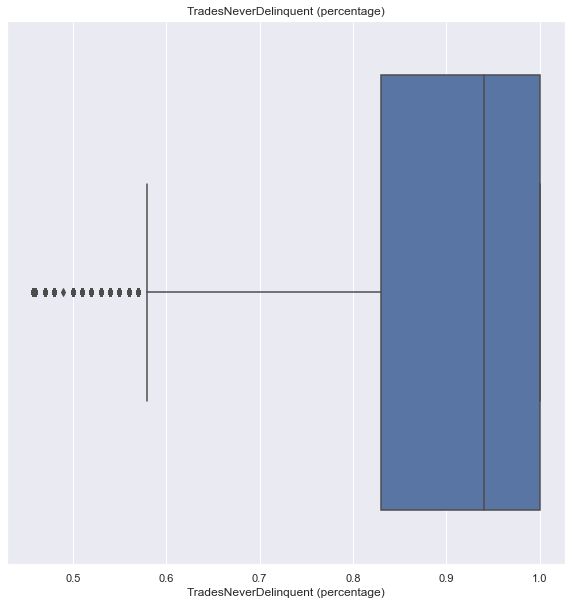

C:\Users\m2021\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


-------------------------------------------------------------------------------------------------------


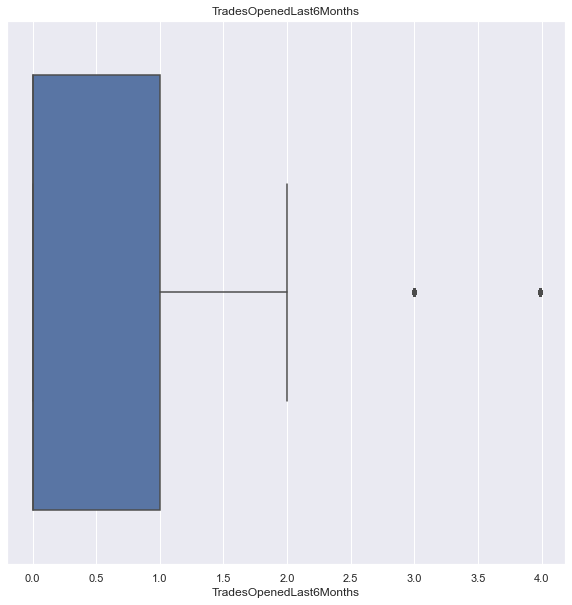

C:\Users\m2021\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


-------------------------------------------------------------------------------------------------------


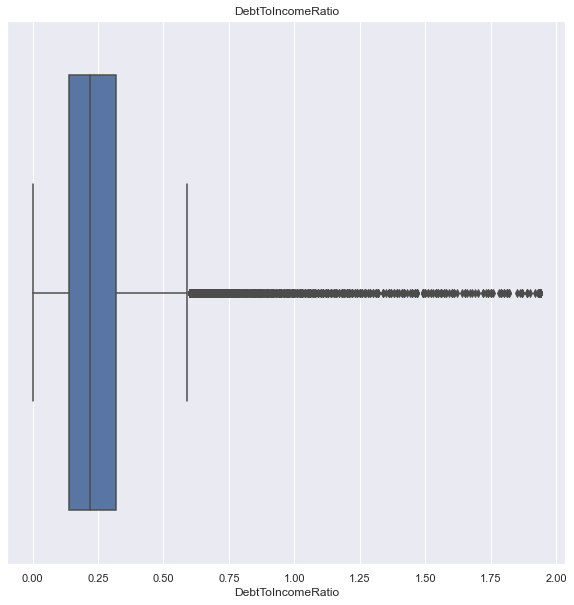

-------------------------------------------------------------------------------------------------------


C:\Users\m2021\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


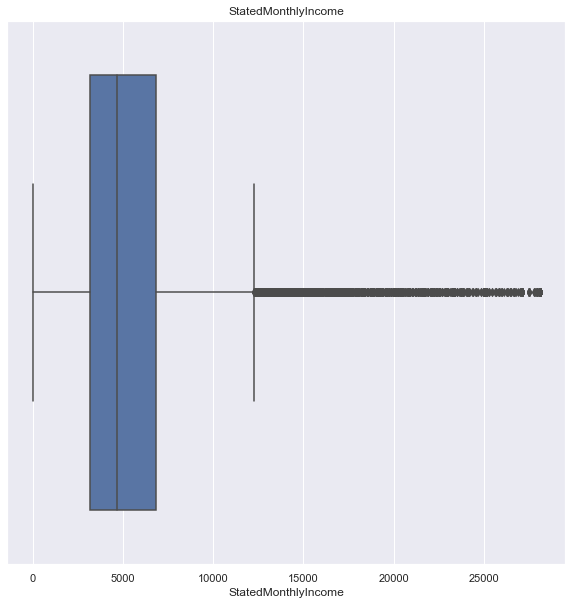

C:\Users\m2021\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


-------------------------------------------------------------------------------------------------------


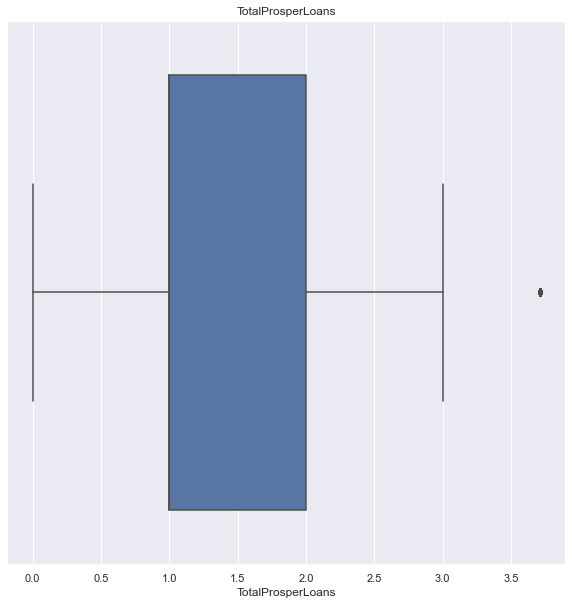

C:\Users\m2021\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


-------------------------------------------------------------------------------------------------------


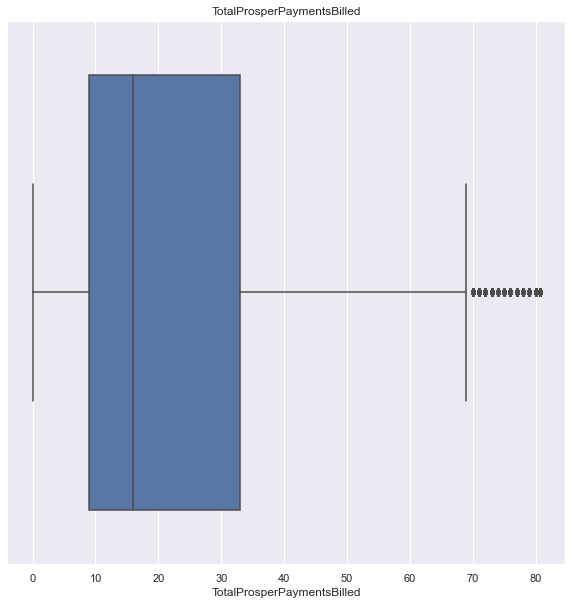

C:\Users\m2021\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


-------------------------------------------------------------------------------------------------------


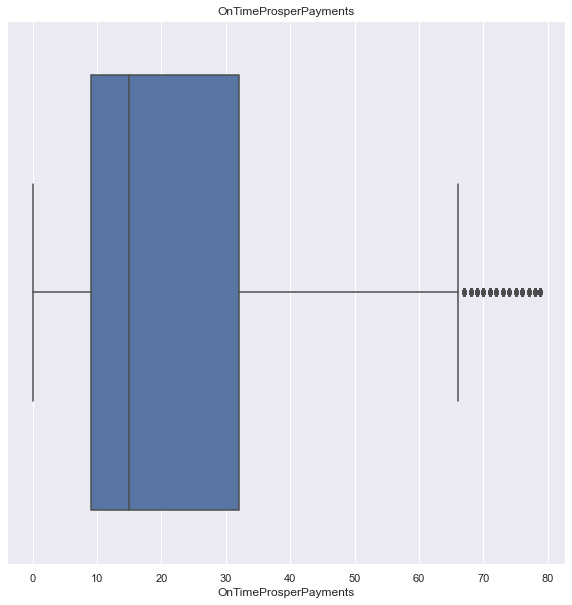

C:\Users\m2021\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


-------------------------------------------------------------------------------------------------------


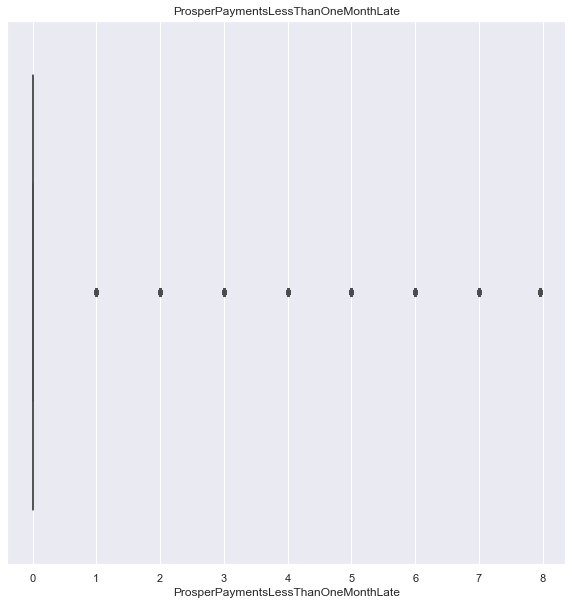

C:\Users\m2021\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


-------------------------------------------------------------------------------------------------------


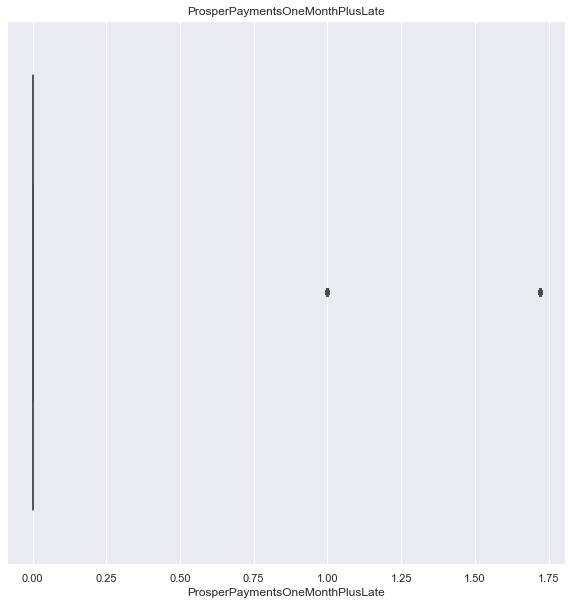

C:\Users\m2021\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


-------------------------------------------------------------------------------------------------------


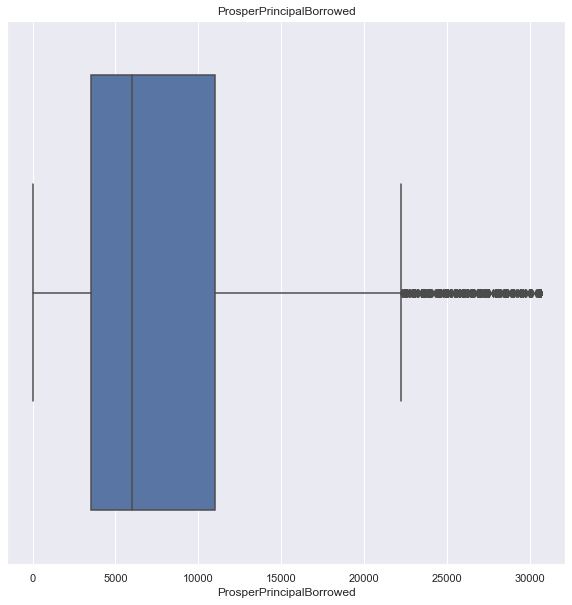

-------------------------------------------------------------------------------------------------------


C:\Users\m2021\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


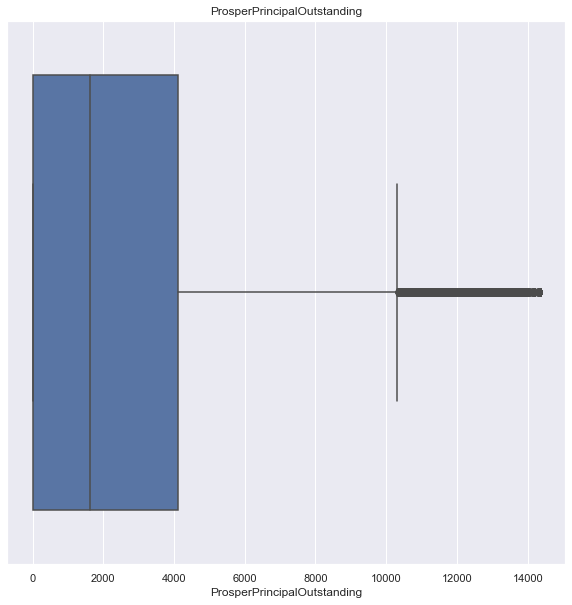

-------------------------------------------------------------------------------------------------------


C:\Users\m2021\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


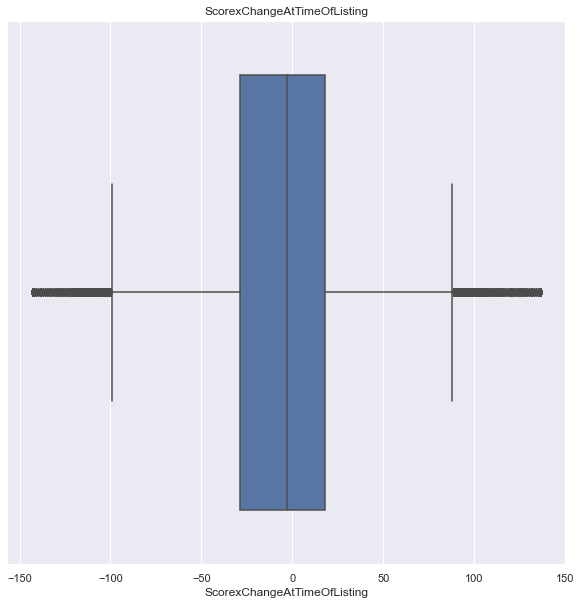

C:\Users\m2021\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


-------------------------------------------------------------------------------------------------------


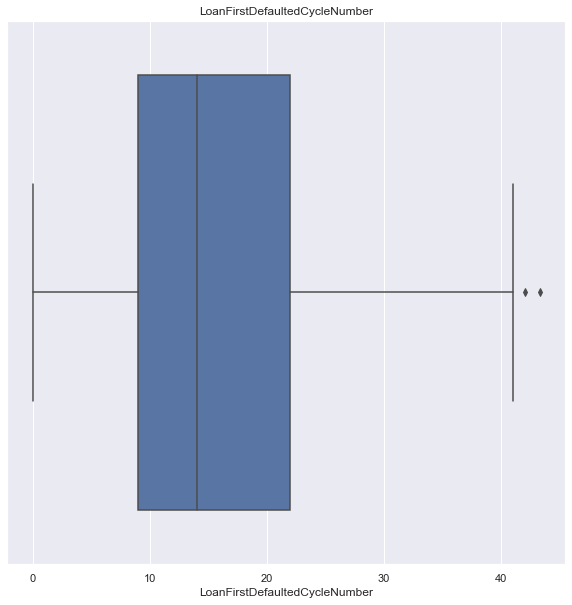

C:\Users\m2021\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


-------------------------------------------------------------------------------------------------------


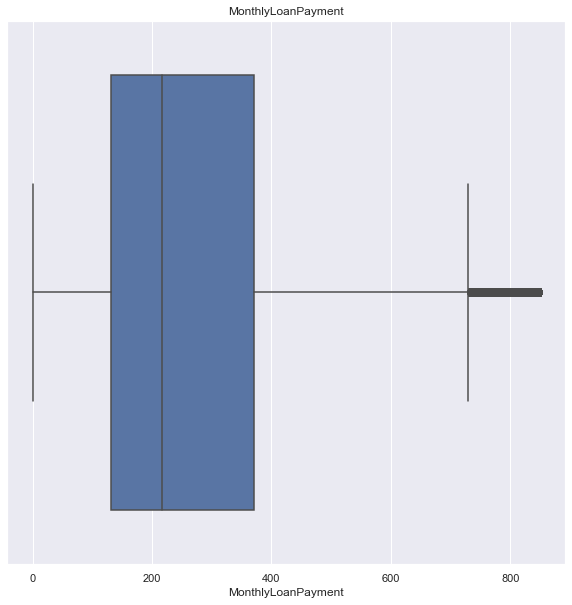

C:\Users\m2021\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


-------------------------------------------------------------------------------------------------------


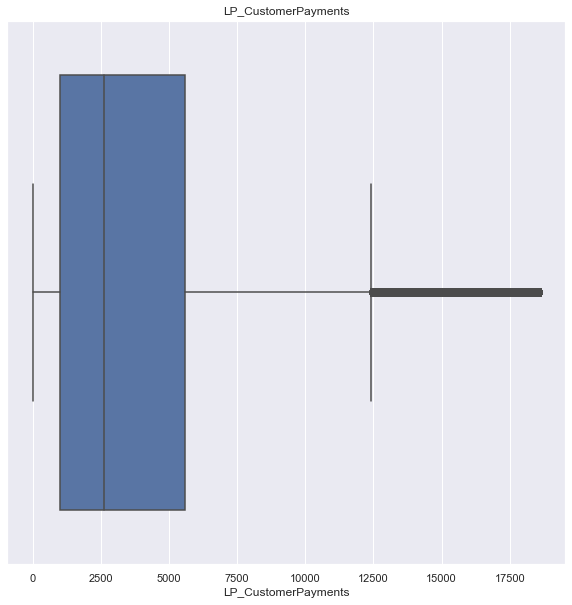

C:\Users\m2021\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


-------------------------------------------------------------------------------------------------------


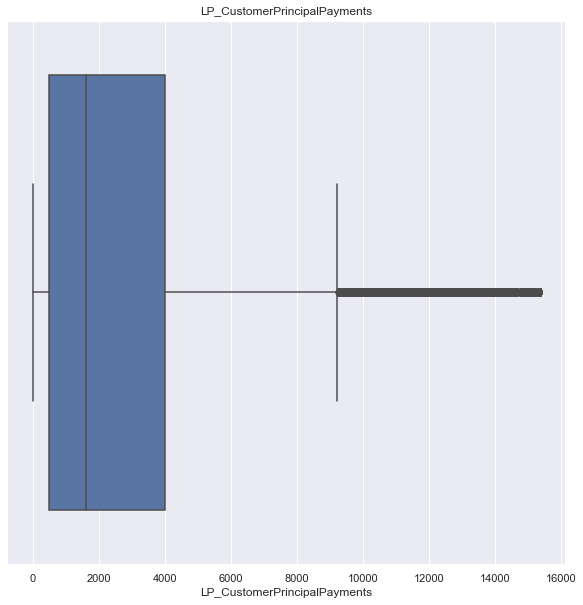

-------------------------------------------------------------------------------------------------------


C:\Users\m2021\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


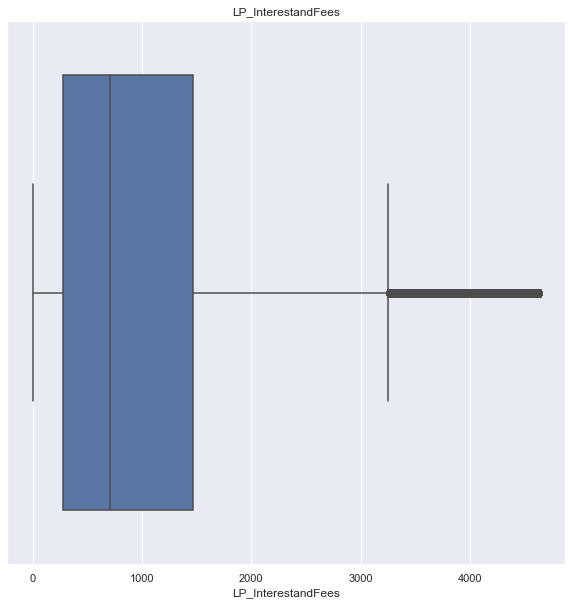

-------------------------------------------------------------------------------------------------------


C:\Users\m2021\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


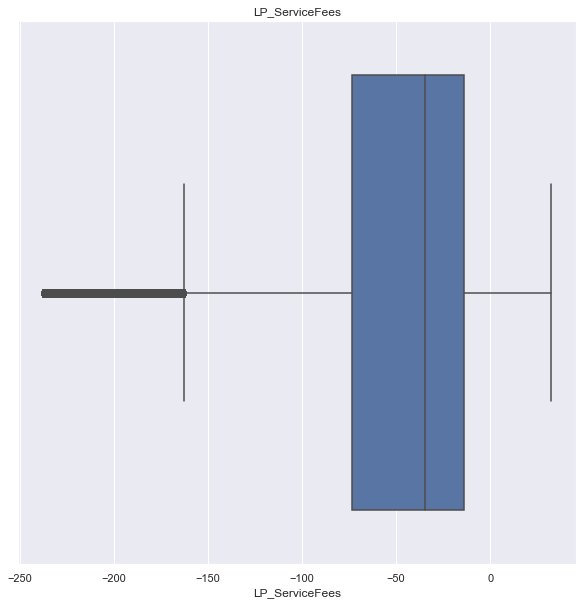

C:\Users\m2021\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


-------------------------------------------------------------------------------------------------------


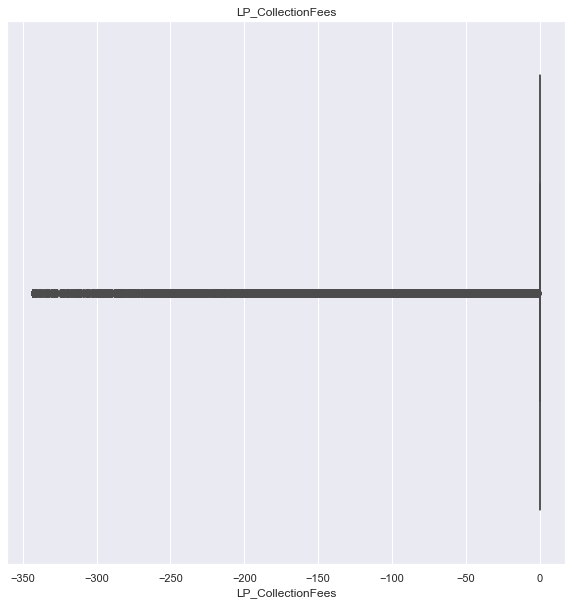

C:\Users\m2021\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


-------------------------------------------------------------------------------------------------------


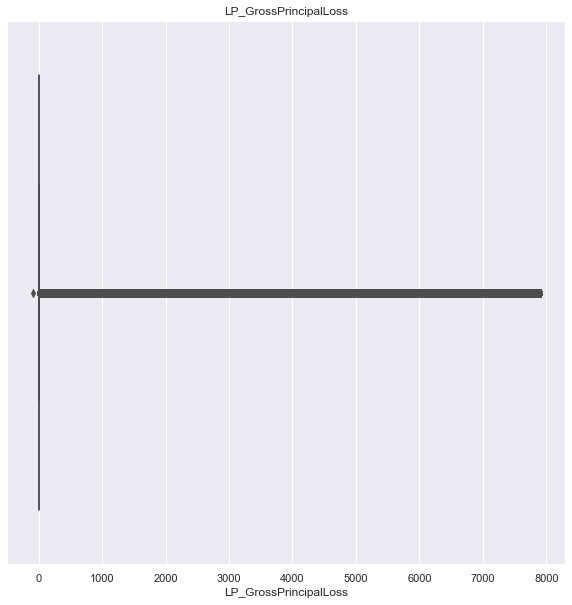

C:\Users\m2021\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


-------------------------------------------------------------------------------------------------------


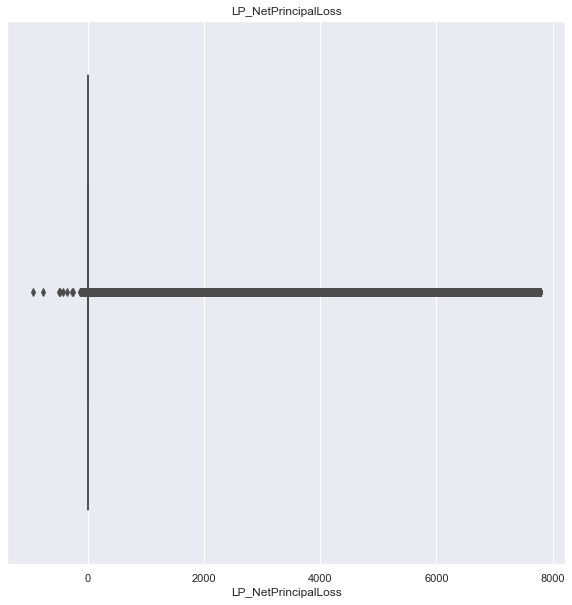

C:\Users\m2021\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


-------------------------------------------------------------------------------------------------------


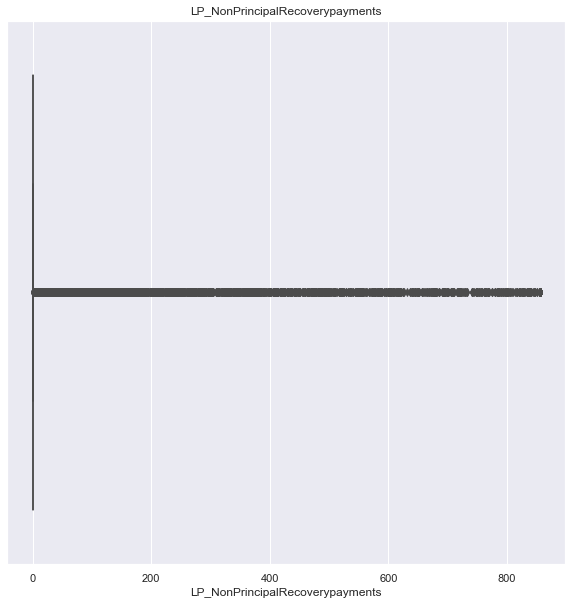

C:\Users\m2021\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


-------------------------------------------------------------------------------------------------------


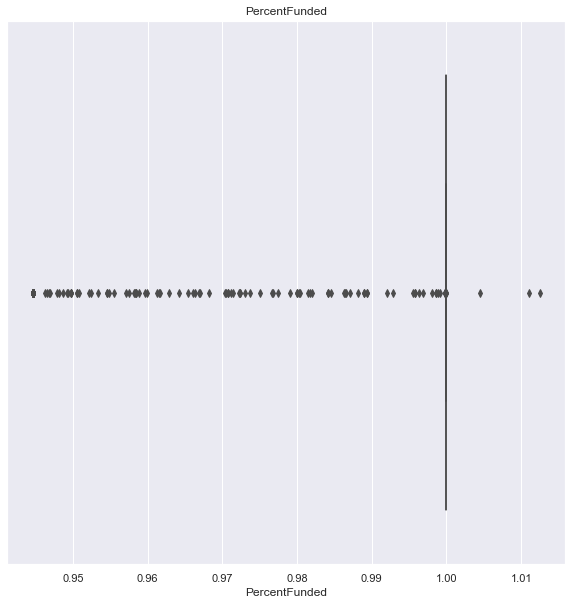

C:\Users\m2021\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


-------------------------------------------------------------------------------------------------------


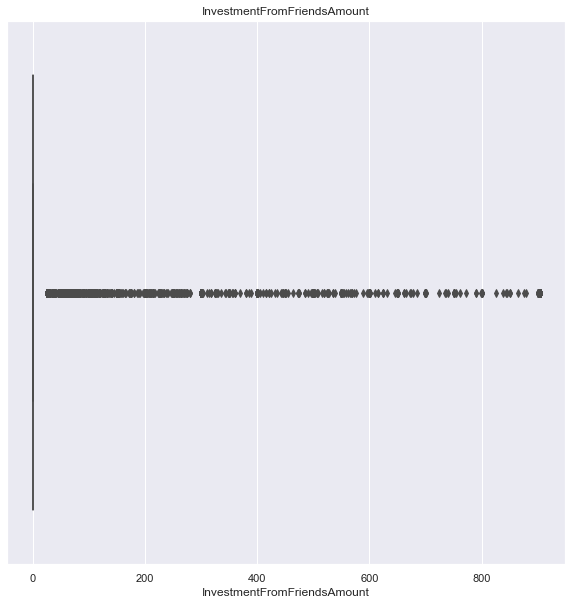

-------------------------------------------------------------------------------------------------------


C:\Users\m2021\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


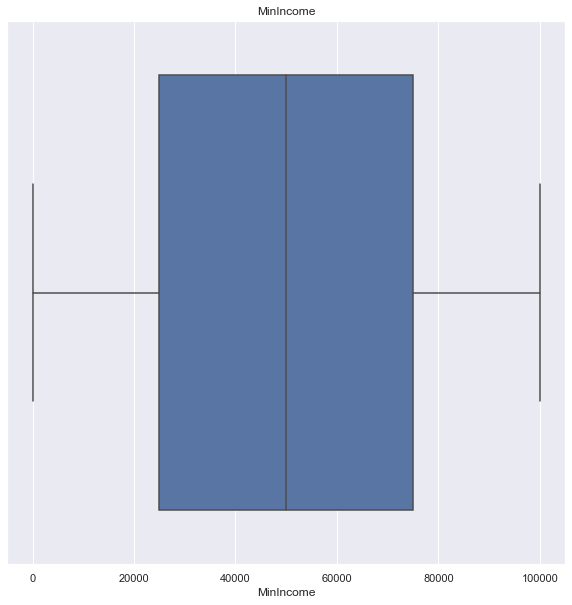

-------------------------------------------------------------------------------------------------------


C:\Users\m2021\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


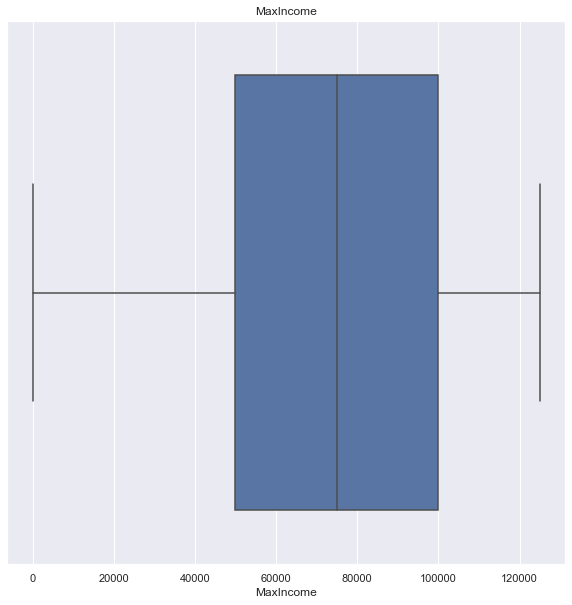

-------------------------------------------------------------------------------------------------------


In [45]:
for col in con_features:
    plt.figure(figsize=(10,10))
    sns.boxplot(data[col])
    plt.title(col)
    plt.show()
    print('-------------------------------------------------------------------------------------------------------')

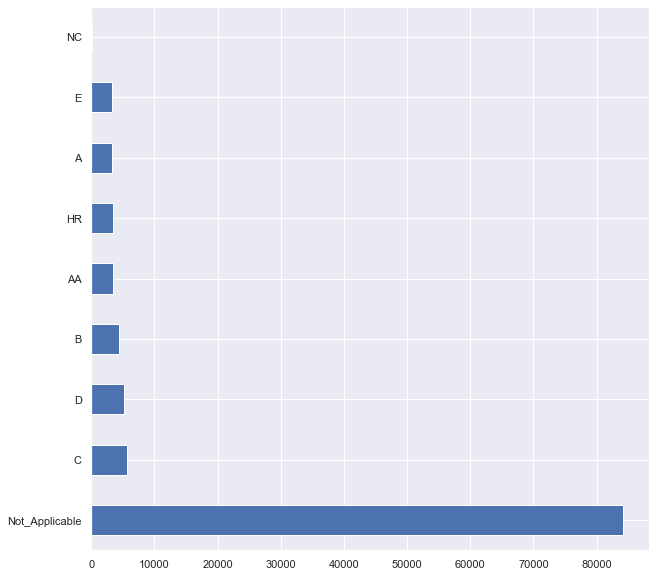

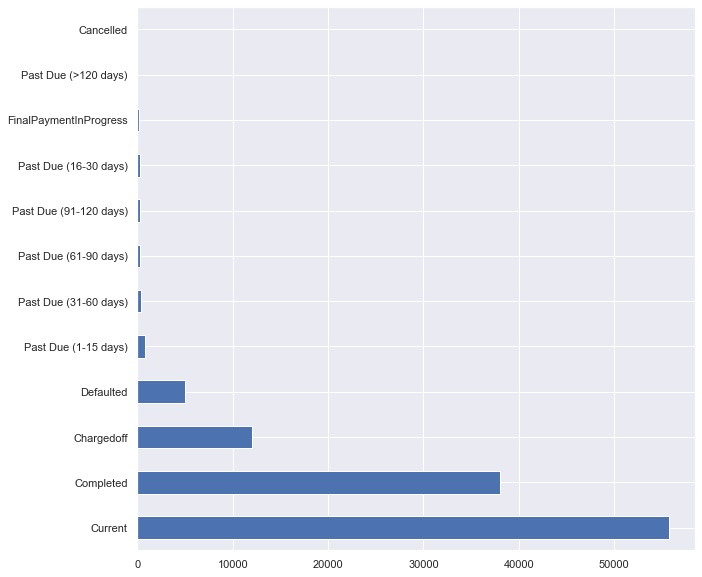

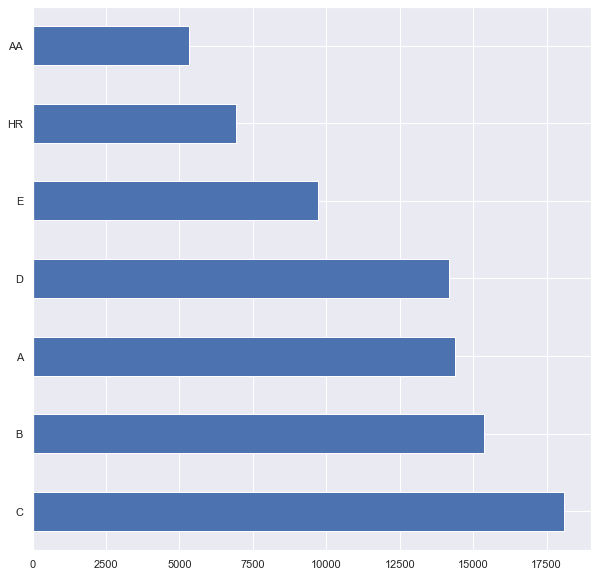

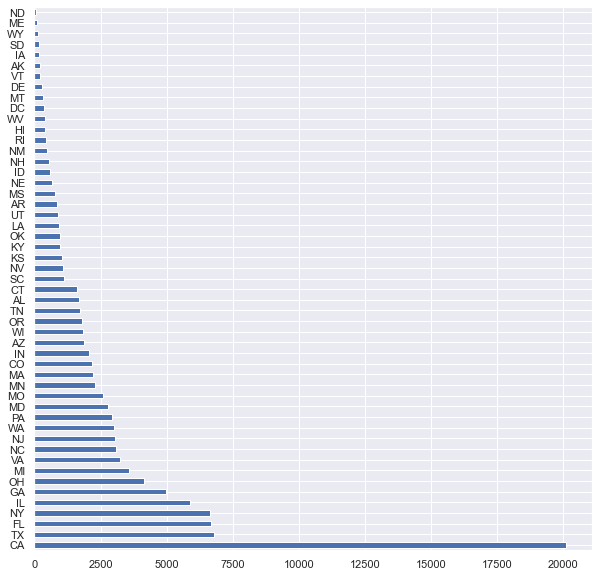

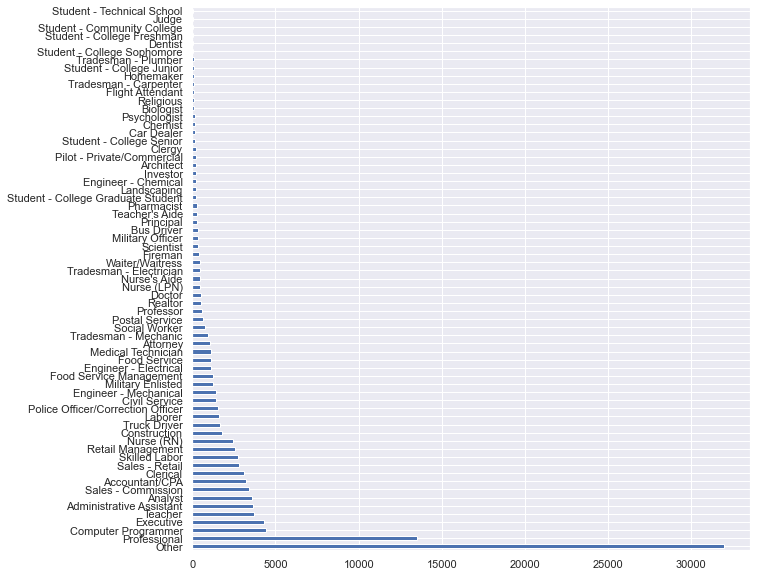

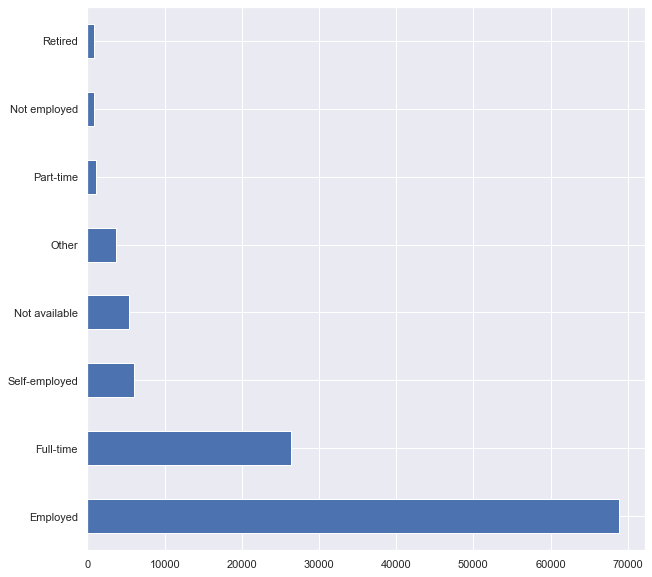

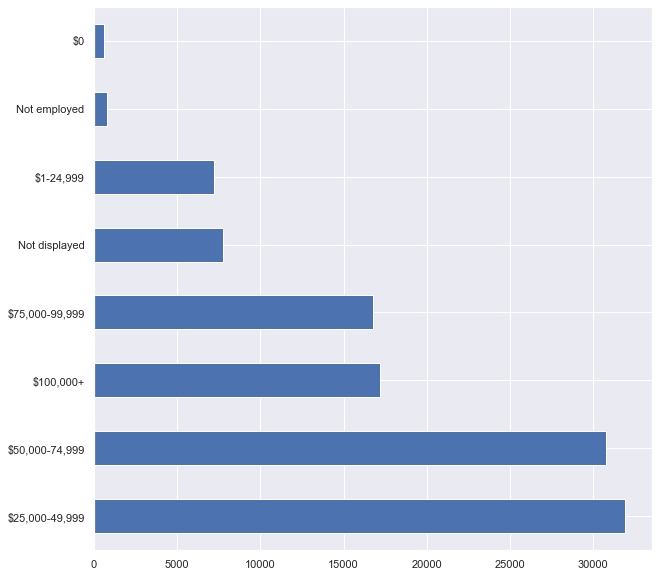

In [47]:
for col in cat_features :
    plt.figure(figsize=(10,10))
    data[col].value_counts().plot(kind = 'barh')
    plt.show()

IsBorrowerHomeowner


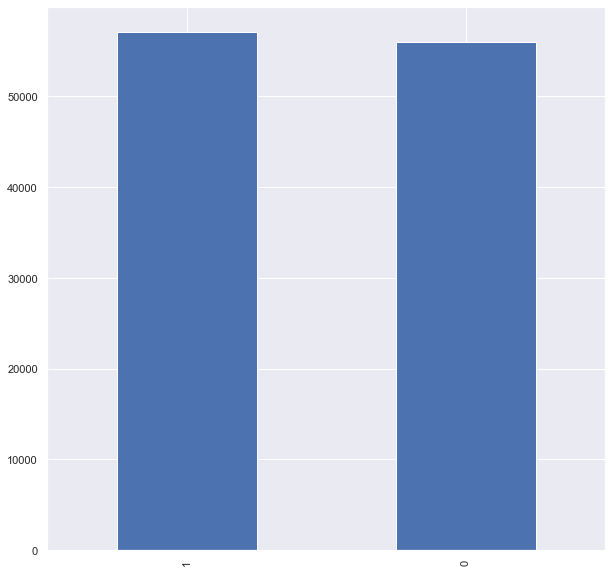

---------------------------------------------------------------------------------------------------------------
CurrentlyInGroup


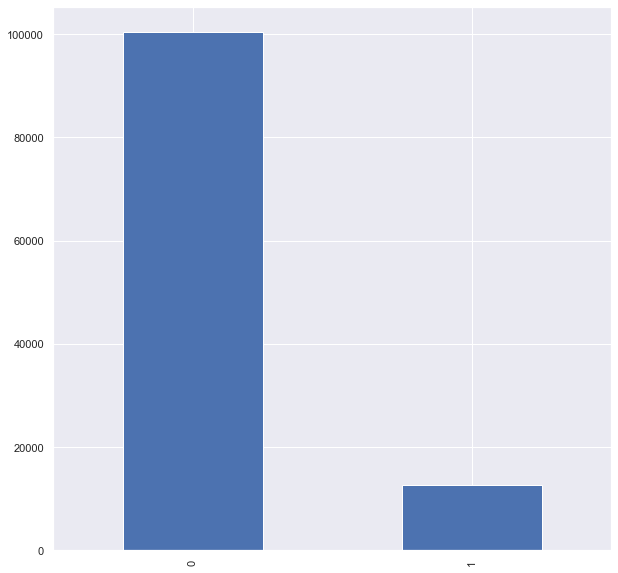

---------------------------------------------------------------------------------------------------------------
IncomeVerifiable


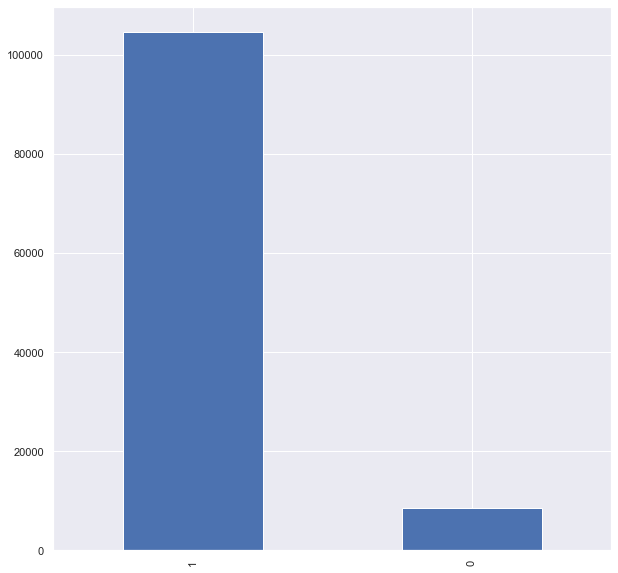

---------------------------------------------------------------------------------------------------------------
after_July2009


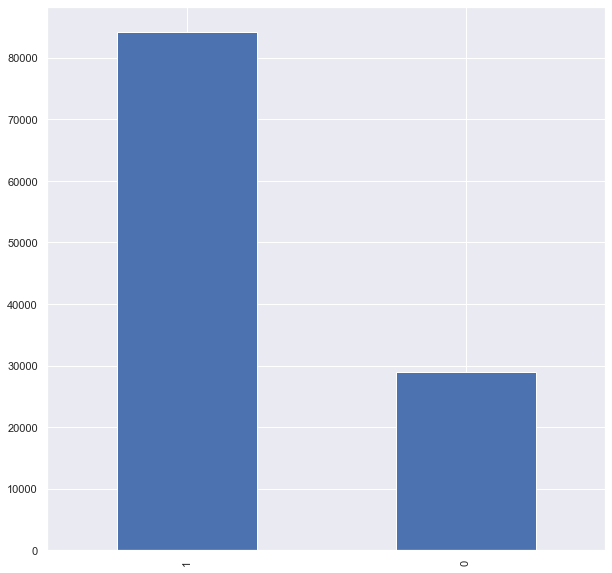

---------------------------------------------------------------------------------------------------------------
had_PriorLoans


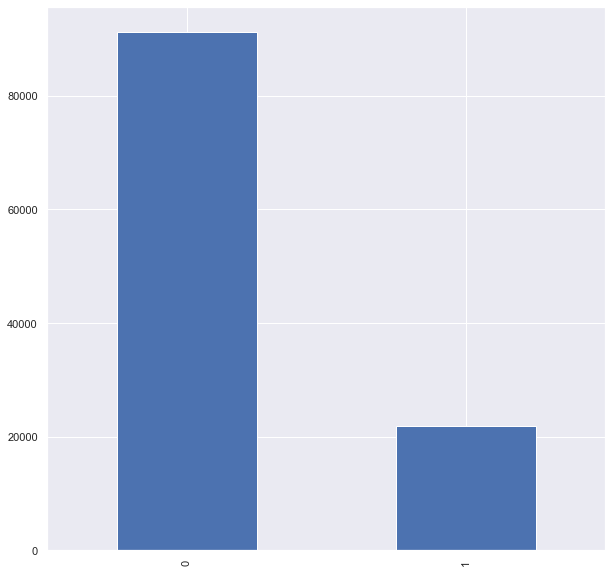

---------------------------------------------------------------------------------------------------------------
Is_ChargedOff


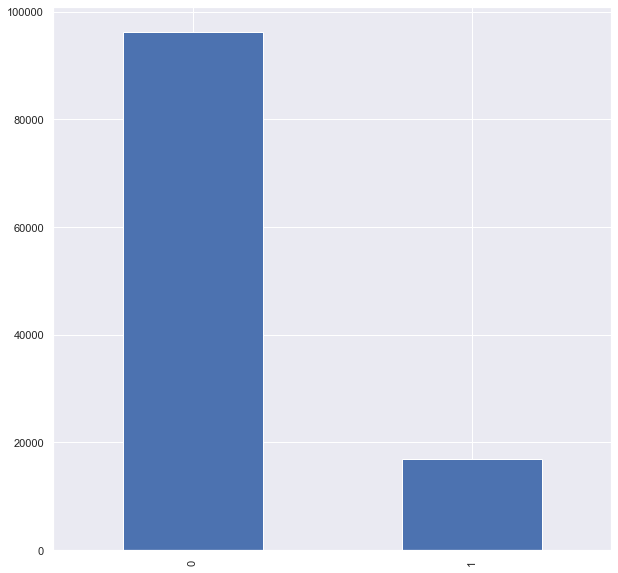

---------------------------------------------------------------------------------------------------------------
exclude_recoveries


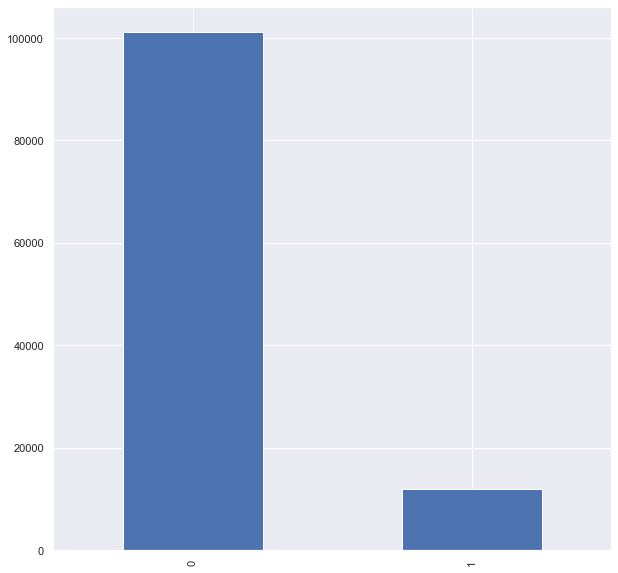

---------------------------------------------------------------------------------------------------------------
availability_DebtToIncomeRatio


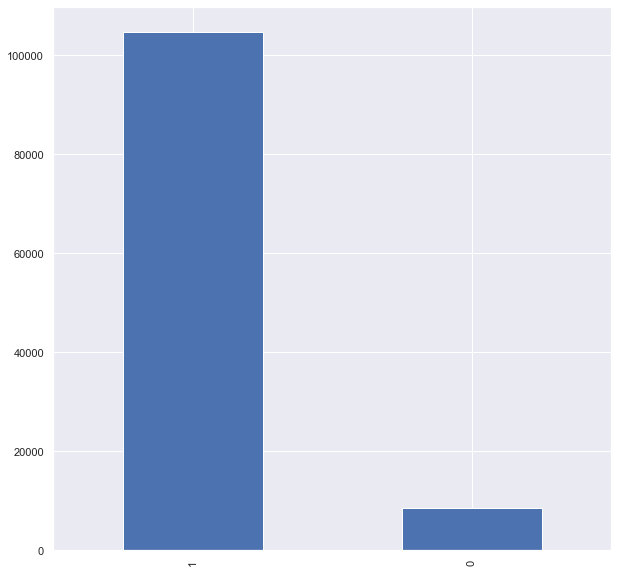

---------------------------------------------------------------------------------------------------------------
DebtToIncomeRatio_Larger_10


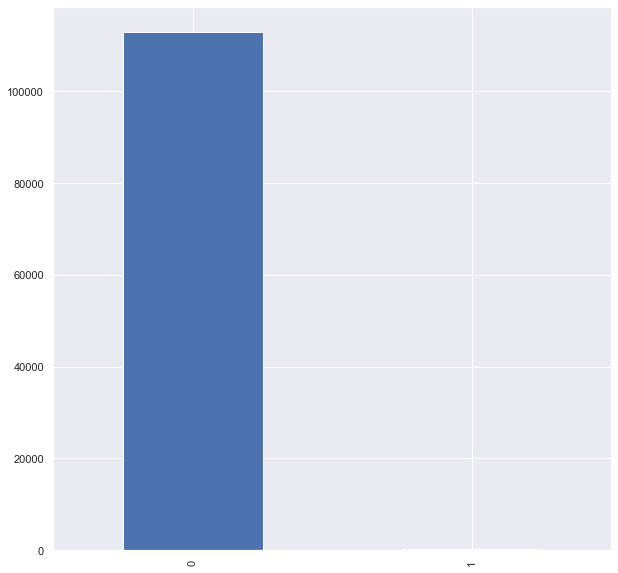

---------------------------------------------------------------------------------------------------------------
Is_CreditGradeApplicable


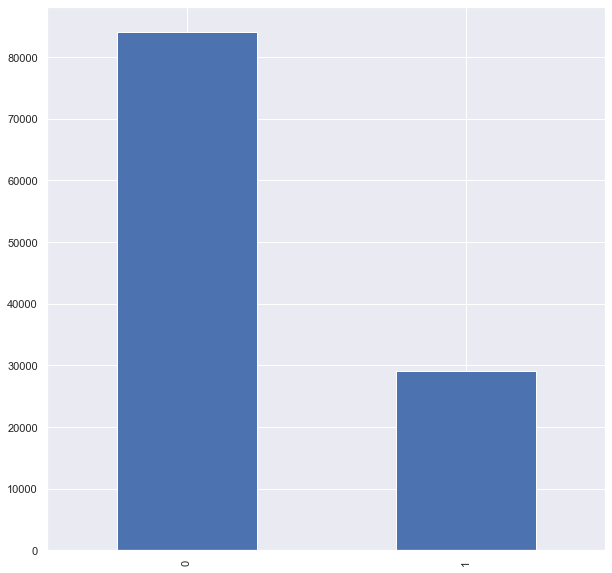

---------------------------------------------------------------------------------------------------------------
IsClosed


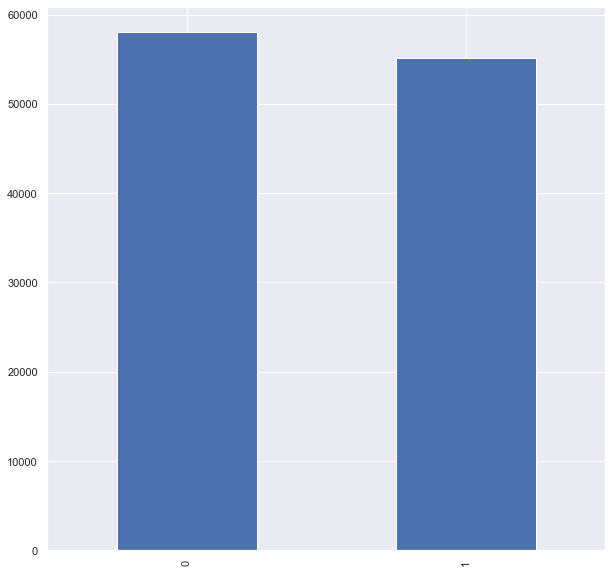

---------------------------------------------------------------------------------------------------------------
IsInProgress


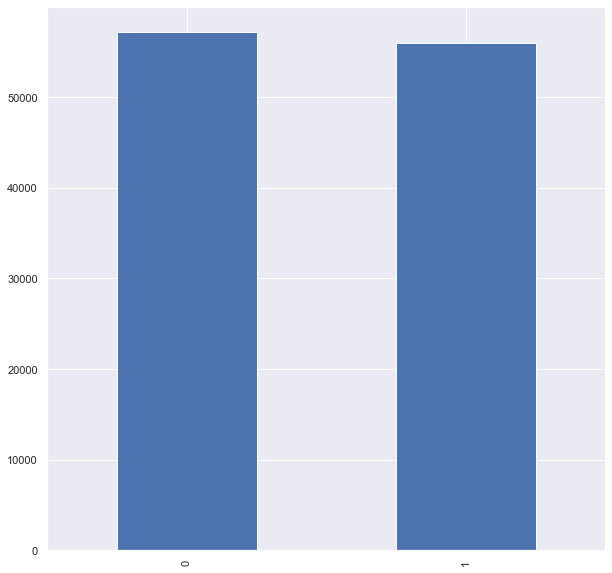

---------------------------------------------------------------------------------------------------------------
IsInGroup


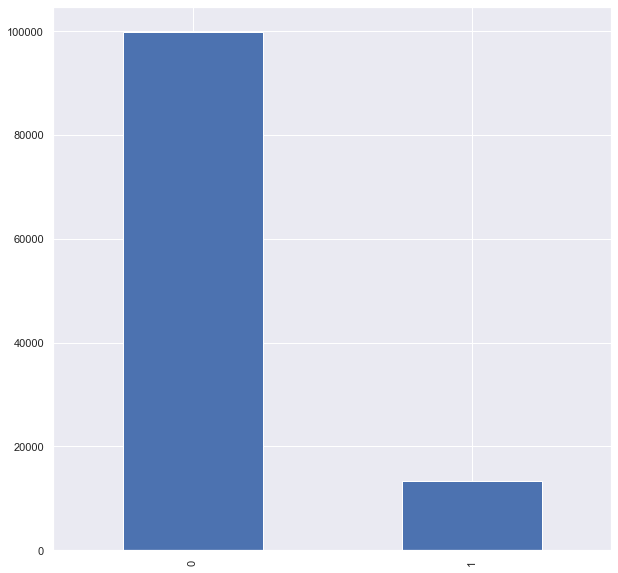

---------------------------------------------------------------------------------------------------------------
accompanied_delinquencyBucket


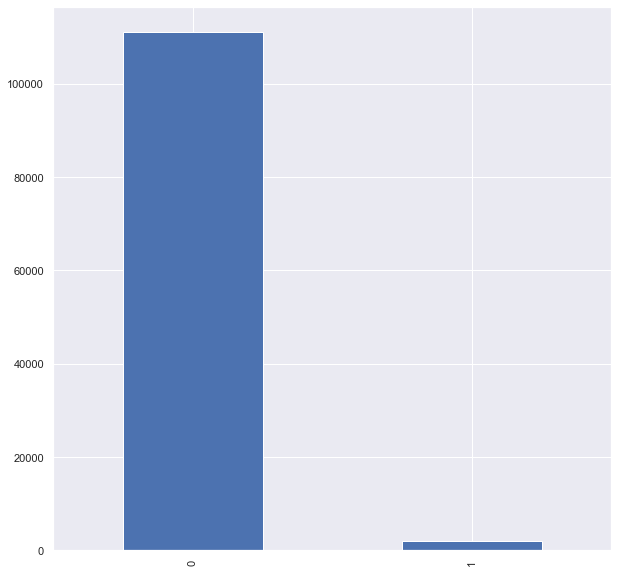

---------------------------------------------------------------------------------------------------------------


In [49]:
for col in bo_features+My_bo_features :
    print(col)
    plt.figure(figsize=(10,10))
    data[col].value_counts().plot(kind = 'bar')
    plt.show()
    print('---------------------------------------------------------------------------------------------------------------')

In [51]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113066 entries, 0 to 113065
Data columns (total 91 columns):
 #   Column                               Non-Null Count   Dtype         
---  ------                               --------------   -----         
 0   ListingCreationDate                  113066 non-null  datetime64[ns]
 1   CreditGrade                          113066 non-null  object        
 2   Term                                 113066 non-null  int8          
 3   LoanStatus                           113066 non-null  object        
 4   ClosedDate                           55076 non-null   object        
 5   BorrowerAPR                          113066 non-null  float32       
 6   BorrowerRate                         113066 non-null  float32       
 7   LenderYield                          113066 non-null  float32       
 8   EstimatedEffectiveYield              83982 non-null   float32       
 9   EstimatedLoss                        83982 non-null   float32       
 

In [52]:
data.to_csv('loans_data_without_outliers.csv')

# --------------------------------------------------------------------------------------------

In [6]:
df_loans = reduce_mem_usage(pd.read_csv("loans_data_without_outliers.csv"))
df_loans = df_loans.drop('Unnamed: 0', axis=1)
df_loans.info()

Memory usage of dataframe is 79.36 MB --> 38.17 MB (Decreased by 51.9%)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113066 entries, 0 to 113065
Data columns (total 91 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   ListingCreationDate                  113066 non-null  object 
 1   CreditGrade                          113066 non-null  object 
 2   Term                                 113066 non-null  int8   
 3   LoanStatus                           113066 non-null  object 
 4   ClosedDate                           55076 non-null   object 
 5   BorrowerAPR                          113066 non-null  float32
 6   BorrowerRate                         113066 non-null  float32
 7   LenderYield                          113066 non-null  float32
 8   EstimatedEffectiveYield              83982 non-null   float32
 9   EstimatedLoss                        83982 non-null   float32
 10  Estimate

In [7]:
for col in date_cols:
    df_loans[col] = pd.to_datetime(df_loans[col])

In [8]:
df_loans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113066 entries, 0 to 113065
Data columns (total 91 columns):
 #   Column                               Non-Null Count   Dtype         
---  ------                               --------------   -----         
 0   ListingCreationDate                  113066 non-null  datetime64[ns]
 1   CreditGrade                          113066 non-null  object        
 2   Term                                 113066 non-null  int8          
 3   LoanStatus                           113066 non-null  object        
 4   ClosedDate                           55076 non-null   object        
 5   BorrowerAPR                          113066 non-null  float32       
 6   BorrowerRate                         113066 non-null  float32       
 7   LenderYield                          113066 non-null  float32       
 8   EstimatedEffectiveYield              83982 non-null   float32       
 9   EstimatedLoss                        83982 non-null   float32       
 

In [6]:
df_loans['Is_completed'] = None
for i in range(df_loans.shape[0]):
    if df_loans['LoanStatus'].iloc[i] == 'Completed':
        df_loans['Is_completed'].iloc[i] = 1
    else :
        df_loans['Is_completed'].iloc[i] = 0
df_loans['Is_completed'].value_counts(normalize = True)

C:\Users\m2021\anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


0    0.663374
1    0.336626
Name: Is_completed, dtype: float64

In [7]:
imp_cols = ['CreditGrade', 'ProsperRating (numeric)', 'ProsperRating (Alpha)', 'ProsperScore' ,
'CreditScoreRangeLower', 'CreditScoreRangeUpper', 'Is_CreditGradeApplicable','IsClosed',
'IsInProgress','IsLate','Is_completed','after_July2009','accompanied_delinquencyBucket',]
temp_df = df_loans[imp_cols].copy()
temp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113066 entries, 0 to 113065
Data columns (total 13 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   CreditGrade                    113066 non-null  object 
 1   ProsperRating (numeric)        83982 non-null   float32
 2   ProsperRating (Alpha)          83982 non-null   object 
 3   ProsperScore                   83982 non-null   float32
 4   CreditScoreRangeLower          113066 non-null  float32
 5   CreditScoreRangeUpper          113066 non-null  float32
 6   Is_CreditGradeApplicable       113066 non-null  int8   
 7   IsClosed                       113066 non-null  int8   
 8   IsInProgress                   113066 non-null  int8   
 9   IsLate                         113066 non-null  int8   
 10  Is_completed                   113066 non-null  object 
 11  after_July2009                 113066 non-null  int8   
 12  accompanied_delinquencyBucket 

In [8]:
temp_df['ProsperRating (Alpha)'].value_counts(normalize=True)

C     0.215475
B     0.182992
A     0.171346
D     0.168727
E     0.115691
HR    0.082363
AA    0.063406
Name: ProsperRating (Alpha), dtype: float64

In [9]:
temp_df['ProsperRating (numeric)'].fillna(temp_df['ProsperRating (numeric)'].mean(), inplace = True)
temp_df['ProsperScore'].fillna(temp_df['ProsperScore'].mean(), inplace = True)
temp_df['ProsperRating (Alpha)'].fillna(temp_df['ProsperRating (Alpha)'].mode()[0], inplace = True)

In [10]:
temp_df['Is_completed'] =  temp_df['Is_completed'].astype('int8')
temp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113066 entries, 0 to 113065
Data columns (total 13 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   CreditGrade                    113066 non-null  object 
 1   ProsperRating (numeric)        113066 non-null  float32
 2   ProsperRating (Alpha)          113066 non-null  object 
 3   ProsperScore                   113066 non-null  float32
 4   CreditScoreRangeLower          113066 non-null  float32
 5   CreditScoreRangeUpper          113066 non-null  float32
 6   Is_CreditGradeApplicable       113066 non-null  int8   
 7   IsClosed                       113066 non-null  int8   
 8   IsInProgress                   113066 non-null  int8   
 9   IsLate                         113066 non-null  int8   
 10  Is_completed                   113066 non-null  int8   
 11  after_July2009                 113066 non-null  int8   
 12  accompanied_delinquencyBucket 

In [11]:
pd.get_dummies(temp_df, columns=['CreditGrade','ProsperRating (Alpha)']).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113066 entries, 0 to 113065
Data columns (total 27 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   ProsperRating (numeric)        113066 non-null  float32
 1   ProsperScore                   113066 non-null  float32
 2   CreditScoreRangeLower          113066 non-null  float32
 3   CreditScoreRangeUpper          113066 non-null  float32
 4   Is_CreditGradeApplicable       113066 non-null  int8   
 5   IsClosed                       113066 non-null  int8   
 6   IsInProgress                   113066 non-null  int8   
 7   IsLate                         113066 non-null  int8   
 8   Is_completed                   113066 non-null  int8   
 9   after_July2009                 113066 non-null  int8   
 10  accompanied_delinquencyBucket  113066 non-null  int8   
 11  CreditGrade_A                  113066 non-null  uint8  
 12  CreditGrade_AA                

In [12]:
temp2_df = pd.get_dummies(temp_df, columns=['CreditGrade','ProsperRating (Alpha)'])

In [13]:
temp2_df.std()

ProsperRating (numeric)           1.444056
ProsperScore                      2.045865
CreditScoreRangeLower            62.296894
CreditScoreRangeUpper            62.290321
Is_CreditGradeApplicable          0.437036
IsClosed                          0.499836
IsInProgress                      0.499974
IsLate                            0.402974
Is_completed                      0.472558
after_July2009                    0.436464
accompanied_delinquencyBucket     0.133649
CreditGrade_A                     0.168700
CreditGrade_AA                    0.173413
CreditGrade_B                     0.193162
CreditGrade_C                     0.217867
CreditGrade_D                     0.208563
CreditGrade_E                     0.168057
CreditGrade_HR                    0.173389
CreditGrade_NC                    0.035292
CreditGrade_Not_Applicable        0.436464
ProsperRating (Alpha)_A           0.333278
ProsperRating (Alpha)_AA          0.211846
ProsperRating (Alpha)_B           0.342706
ProsperRati

In [14]:
sc = StandardScaler()
sc.fit(temp2_df[['ProsperRating (numeric)','ProsperScore','CreditScoreRangeLower','CreditScoreRangeUpper']])

StandardScaler()

In [15]:
temp2_df[['ProsperRating (numeric)','ProsperScore','CreditScoreRangeLower','CreditScoreRangeUpper']] = sc.transform(temp2_df[['ProsperRating (numeric)','ProsperScore','CreditScoreRangeLower','CreditScoreRangeUpper']])
temp2_df.std()

ProsperRating (numeric)          1.000004
ProsperScore                     1.000004
CreditScoreRangeLower            1.000004
CreditScoreRangeUpper            1.000004
Is_CreditGradeApplicable         0.437036
IsClosed                         0.499836
IsInProgress                     0.499974
IsLate                           0.402974
Is_completed                     0.472558
after_July2009                   0.436464
accompanied_delinquencyBucket    0.133649
CreditGrade_A                    0.168700
CreditGrade_AA                   0.173413
CreditGrade_B                    0.193162
CreditGrade_C                    0.217867
CreditGrade_D                    0.208563
CreditGrade_E                    0.168057
CreditGrade_HR                   0.173389
CreditGrade_NC                   0.035292
CreditGrade_Not_Applicable       0.436464
ProsperRating (Alpha)_A          0.333278
ProsperRating (Alpha)_AA         0.211846
ProsperRating (Alpha)_B          0.342706
ProsperRating (Alpha)_C          0

In [16]:
temp2_df.to_csv('temp_df_for_model1.csv')

Text(0.5, 1.0, 'Correlation')

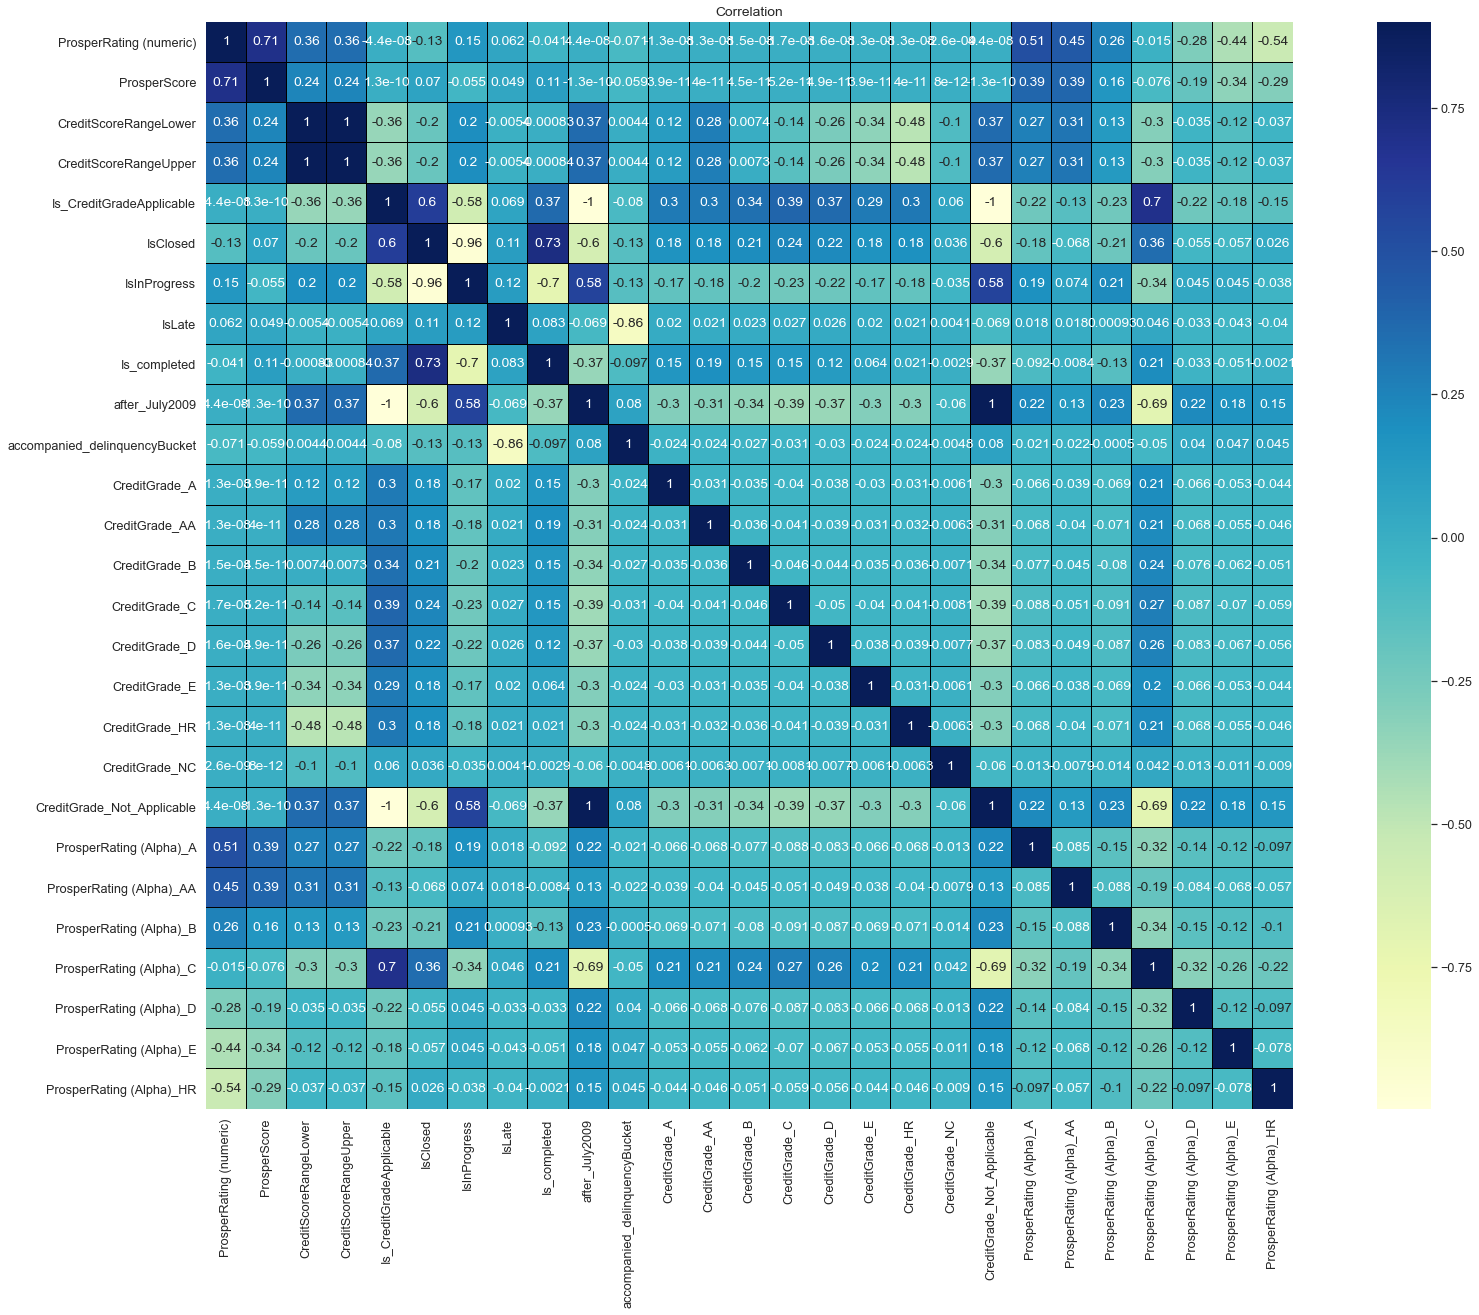

In [17]:
sns.set(font_scale=1.15)
plt.figure(figsize=(30, 20))
sns.heatmap(temp2_df.corr(),  vmax=0.9, linewidths=0.02,
           square=True,
            annot=True,
            cmap='YlGnBu',
            linecolor="black")
plt.title('Correlation')

# --------------------------------------------------------------------------------------------------------

In [5]:
temp2_df = pd.read_csv('temp_df_for_model1.csv')
temp2_df = temp2_df.drop('Unnamed: 0', axis=1)
temp2_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113066 entries, 0 to 113065
Data columns (total 27 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   ProsperRating (numeric)        113066 non-null  float64
 1   ProsperScore                   113066 non-null  float64
 2   CreditScoreRangeLower          113066 non-null  float64
 3   CreditScoreRangeUpper          113066 non-null  float64
 4   Is_CreditGradeApplicable       113066 non-null  int64  
 5   IsClosed                       113066 non-null  int64  
 6   IsInProgress                   113066 non-null  int64  
 7   IsLate                         113066 non-null  int64  
 8   Is_completed                   113066 non-null  int64  
 9   after_July2009                 113066 non-null  int64  
 10  accompanied_delinquencyBucket  113066 non-null  int64  
 11  CreditGrade_A                  113066 non-null  int64  
 12  CreditGrade_AA                

In [6]:
temp2_df.drop(['CreditGrade_Not_Applicable','after_July2009','CreditScoreRangeLower'],axis=1,inplace=True)
temp2_df=reduce_mem_usage(temp2_df)

Memory usage of dataframe is 20.70 MB --> 3.56 MB (Decreased by 82.8%)


In [7]:
X_train,X_test,y_train,y_test = train_test_split(temp2_df.drop('Is_completed',axis=1),temp2_df['Is_completed'],test_size=0.25,random_state=1111)

In [8]:
model1 = LogisticRegression(penalty='l1', solver='liblinear', random_state=1111, max_iter=10000)

In [9]:
# Instantiate the GridSearchCV object and run the search
searcher = GridSearchCV(model1, {'C':[0.001, 0.005, 0.01, 0.05, 0.1, 0.3, 0.6, 1, 3, 6]}, cv=5)
searcher.fit(X_train, y_train)

# Report the best parameters
print("Best CV params", searcher.best_params_)

# Find the number of nonzero coefficients (selected features)
best_lr = searcher.best_estimator_
coefs = best_lr.coef_
print("Total number of features:", coefs.size)
print("Number of selected features:", np.count_nonzero(coefs))

Best CV params {'C': 0.01}
Total number of features: 23
Number of selected features: 9


In [10]:
perm = PermutationImportance(searcher, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

Weight,Feature
0.2298 ± 0.0043,IsInProgress
0.0456 ± 0.0025,IsClosed
0.0122 ± 0.0013,CreditScoreRangeUpper
0.0090 ± 0.0006,IsLate
0.0017 ± 0.0003,Is_CreditGradeApplicable
0.0006 ± 0.0005,ProsperRating (numeric)
0.0004 ± 0.0008,ProsperScore
0 ± 0.0000,CreditGrade_E
0 ± 0.0000,ProsperRating (Alpha)_HR
0 ± 0.0000,ProsperRating (Alpha)_D


In [11]:
imp_fea=["IsInProgress",
"IsClosed",
"CreditScoreRangeUpper",
"IsLate",
"Is_CreditGradeApplicable",
"ProsperRating (numeric)",
"ProsperScore"]

model1 = LogisticRegression(penalty='l1', solver='liblinear', random_state=1111, max_iter=10000)

# Instantiate the GridSearchCV object and run the search
searcher = GridSearchCV(model1, {'C':[0.001, 0.005, 0.01, 0.05, 0.1, 0.3, 0.6, 1, 3, 6]}, cv=5)
searcher.fit(X_train[imp_fea], y_train)

# Report the best parameters
print("Best CV params", searcher.best_params_)

# Find the number of nonzero coefficients (selected features)
best_lr0 = searcher.best_estimator_
coefs = best_lr0.coef_
print("Total number of features:", coefs.size)
print("Number of selected features:", np.count_nonzero(coefs))

Best CV params {'C': 0.005}
Total number of features: 7
Number of selected features: 7


In [12]:
perm = PermutationImportance(searcher, random_state=1).fit(X_test[imp_fea], y_test)
eli5.show_weights(perm, feature_names = X_test[imp_fea].columns.tolist())

Weight,Feature
0.2331 ± 0.0029,IsInProgress
0.0399 ± 0.0029,IsClosed
0.0126 ± 0.0010,CreditScoreRangeUpper
0.0090 ± 0.0007,IsLate
0.0019 ± 0.0005,Is_CreditGradeApplicable
0.0009 ± 0.0007,ProsperScore
0.0005 ± 0.0007,ProsperRating (numeric)


In [13]:
y_pred=best_lr.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.97      0.81      0.88     18813
           1       0.71      0.95      0.82      9454

    accuracy                           0.86     28267
   macro avg       0.84      0.88      0.85     28267
weighted avg       0.89      0.86      0.86     28267



In [14]:
y_pred0=best_lr0.predict(X_test[imp_fea])
print(classification_report(y_test,y_pred0))

              precision    recall  f1-score   support

           0       0.97      0.81      0.88     18813
           1       0.71      0.95      0.82      9454

    accuracy                           0.86     28267
   macro avg       0.84      0.88      0.85     28267
weighted avg       0.88      0.86      0.86     28267



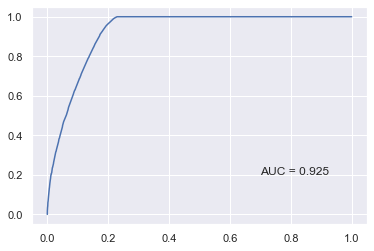

In [15]:
fpr,tpr,hp=roc_curve(y_test,best_lr.predict_proba(X_test)[:,1])
auc=roc_auc_score(y_test,best_lr.predict_proba(X_test)[:,1])
plt.plot(fpr,tpr)
plt.text(0.7,0.2,"AUC = "+"{:.3f}".format(auc))
plt.show()

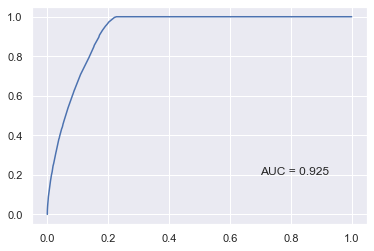

In [16]:
fpr,tpr,hp=roc_curve(y_train,best_lr.predict_proba(X_train)[:,1])
auc=roc_auc_score(y_train,best_lr.predict_proba(X_train)[:,1])
plt.plot(fpr,tpr)
plt.text(0.7,0.2,"AUC = "+"{:.3f}".format(auc))
plt.show()

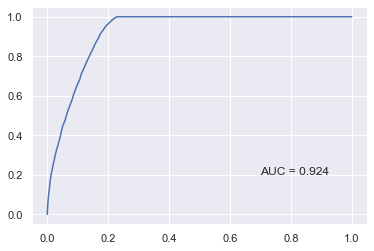

In [17]:
fpr,tpr,hp=roc_curve(y_test,best_lr0.predict_proba(X_test[imp_fea])[:,1])
auc=roc_auc_score(y_test,best_lr0.predict_proba(X_test[imp_fea])[:,1])
plt.plot(fpr,tpr)
plt.text(0.7,0.2,"AUC = "+"{:.3f}".format(auc))
plt.show()

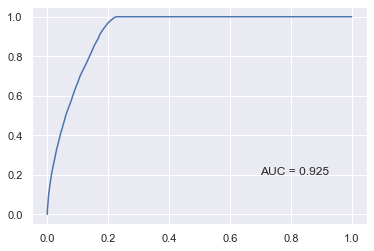

In [18]:
fpr,tpr,hp=roc_curve(y_train,best_lr0.predict_proba(X_train[imp_fea])[:,1])
auc=roc_auc_score(y_train,best_lr0.predict_proba(X_train[imp_fea])[:,1])
plt.plot(fpr,tpr)
plt.text(0.7,0.2,"AUC = "+"{:.3f}".format(auc))
plt.show()

In [19]:
df_loans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113066 entries, 0 to 113065
Data columns (total 91 columns):
 #   Column                               Non-Null Count   Dtype         
---  ------                               --------------   -----         
 0   ListingCreationDate                  113066 non-null  datetime64[ns]
 1   CreditGrade                          113066 non-null  object        
 2   Term                                 113066 non-null  int8          
 3   LoanStatus                           113066 non-null  object        
 4   ClosedDate                           55076 non-null   object        
 5   BorrowerAPR                          113066 non-null  float32       
 6   BorrowerRate                         113066 non-null  float32       
 7   LenderYield                          113066 non-null  float32       
 8   EstimatedEffectiveYield              83982 non-null   float32       
 9   EstimatedLoss                        83982 non-null   float32       
 

In [20]:
data = df_loans.drop(['ClosedDate','GroupKey','LoanOriginationDate','FirstRecordedCreditLine',
                      'DateCreditPulled','ListingCreationDate'],axis=1)

data['ProsperRating (Alpha)'].fillna(data['ProsperRating (Alpha)'].mode()[0], inplace = True)
data['EstimatedEffectiveYield'].fillna(data['EstimatedEffectiveYield'].mean(), inplace = True)
data['EstimatedLoss'].fillna(data['EstimatedLoss'].mean(), inplace = True)
data['EstimatedReturn'].fillna(data['EstimatedReturn'].mean(), inplace = True)
data['ProsperScore'].fillna(data['ProsperScore'].mean(), inplace = True)
data['TotalProsperLoans'].fillna(data['TotalProsperLoans'].mean(), inplace = True)
data['TotalProsperPaymentsBilled'].fillna(data['TotalProsperPaymentsBilled'].mean(), inplace = True)
data['OnTimeProsperPayments'].fillna(data['OnTimeProsperPayments'].mean(), inplace = True)
data['ProsperPaymentsLessThanOneMonthLate'].fillna(data['ProsperPaymentsLessThanOneMonthLate'].mean(), inplace = True)
data['ProsperPaymentsOneMonthPlusLate'].fillna(data['ProsperPaymentsOneMonthPlusLate'].mean(), inplace = True)
data['ProsperPrincipalBorrowed'].fillna(data['ProsperPrincipalBorrowed'].mean(), inplace = True)
data['ProsperPrincipalOutstanding'].fillna(data['ProsperPrincipalOutstanding'].mean(), inplace = True)
data['ScorexChangeAtTimeOfListing'].fillna(data['ScorexChangeAtTimeOfListing'].mean(), inplace = True)
data['LoanFirstDefaultedCycleNumber'].fillna(data['LoanFirstDefaultedCycleNumber'].mean(), inplace = True)
data['ProsperRating (numeric)'].fillna(data['ProsperRating (numeric)'].mean(), inplace = True)
data['DebtToIncomeRatio'].fillna(data['DebtToIncomeRatio'].mean(), inplace = True)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113066 entries, 0 to 113065
Data columns (total 85 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   CreditGrade                          113066 non-null  object 
 1   Term                                 113066 non-null  int8   
 2   LoanStatus                           113066 non-null  object 
 3   BorrowerAPR                          113066 non-null  float32
 4   BorrowerRate                         113066 non-null  float32
 5   LenderYield                          113066 non-null  float32
 6   EstimatedEffectiveYield              113066 non-null  float32
 7   EstimatedLoss                        113066 non-null  float32
 8   EstimatedReturn                      113066 non-null  float32
 9   ProsperRating (numeric)              113066 non-null  float32
 10  ProsperRating (Alpha)                113066 non-null  object 
 11  ProsperScore 

In [21]:
data.select_dtypes(include="O")

,CreditGrade,LoanStatus,ProsperRating (Alpha),BorrowerState,Occupation,EmploymentStatus,IncomeRange,LoanKey
0,C,Completed,C,CO,Other,Self-employed,"$25,000-49,999",E33A3400205839220442E84
1,Not_Applicable,Current,A,CO,Professional,Employed,"$50,000-74,999",9E3B37071505919926B1D82
2,HR,Completed,C,GA,Other,Not available,Not displayed,6954337960046817851BCB2
3,Not_Applicable,Current,A,GA,Skilled Labor,Employed,"$25,000-49,999",A0393664465886295619C51
4,Not_Applicable,Current,D,MN,Executive,Employed,"$100,000+",A180369302188889200689E
...,...,...,...,...,...,...,...,...
113061,Not_Applicable,Current,C,IL,Food Service Management,Employed,"$50,000-74,999",9BD7367919051593140DB62
113062,Not_Applicable,FinalPaymentInProgress,A,PA,Professional,Employed,"$75,000-99,999",62D93634569816897D5A276
113063,Not_Applicable,Current,D,TX,Other,Employed,"$25,000-49,999",DD1A370200396006300ACA0
113064,Not_Applicable,Completed,C,GA,Food Service,Full-time,"$25,000-49,999",589536350469116027ED11B


In [22]:
data.drop('LoanKey',axis=1,inplace=True)

In [23]:
li = list(data.select_dtypes(include="O").columns)
li

['CreditGrade',
 'LoanStatus',
 'ProsperRating (Alpha)',
 'BorrowerState',
 'Occupation',
 'EmploymentStatus',
 'IncomeRange']

In [24]:
data = pd.get_dummies(data, columns=li)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113066 entries, 0 to 113065
Columns: 239 entries, Term to IncomeRange_Not employed
dtypes: float32(52), int16(2), int32(1), int8(22), uint8(162)
memory usage: 43.1 MB


In [25]:
data.std()[data.std()>1]

Term                                      10.421518
ProsperRating (numeric)                    1.444056
ProsperScore                               2.045865
ListingCategory (numeric)                  3.998188
EmploymentStatusDuration                  91.475372
CreditScoreRangeLower                     66.463211
CreditScoreRangeUpper                     66.449883
CurrentCreditLines                         5.271513
OpenCreditLines                            4.849735
TotalCreditLinespast7years                13.602557
OpenRevolvingAccounts                      4.629303
OpenRevolvingMonthlyPayment              447.650452
InquiriesLast6Months                       2.436478
TotalInquiries                             6.415864
CurrentDelinquencies                       1.977781
AmountDelinquent                        6915.965332
DelinquenciesLast7Years                   10.126908
RevolvingCreditBalance                 31896.578125
AvailableBankcardCredit                19255.052734
TotalTrades 

In [26]:
df_loans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113066 entries, 0 to 113065
Data columns (total 91 columns):
 #   Column                               Non-Null Count   Dtype         
---  ------                               --------------   -----         
 0   ListingCreationDate                  113066 non-null  datetime64[ns]
 1   CreditGrade                          113066 non-null  object        
 2   Term                                 113066 non-null  int8          
 3   LoanStatus                           113066 non-null  object        
 4   ClosedDate                           55076 non-null   object        
 5   BorrowerAPR                          113066 non-null  float32       
 6   BorrowerRate                         113066 non-null  float32       
 7   LenderYield                          113066 non-null  float32       
 8   EstimatedEffectiveYield              83982 non-null   float32       
 9   EstimatedLoss                        83982 non-null   float32       
 

In [27]:
features_to_scale = dis_features + con_features
len(features_to_scale)

63

In [28]:
sc = StandardScaler()
sc.fit(data[features_to_scale])
data[features_to_scale]=sc.transform(data[features_to_scale])

In [29]:
data.std()[data.std()>1]

Term                       1.000004
BorrowerAPR                1.000004
BorrowerRate               1.000004
LenderYield                1.000004
EstimatedEffectiveYield    1.000004
                             ...   
Investors                  1.000004
IsLate                     1.000004
MinIncome                  1.000004
MaxIncome                  1.000004
Loan_Quarter               1.000004
Length: 63, dtype: float64

In [55]:
data.to_csv("My_final_data_without_missing_values_or_catigorical_features.csv")

In [30]:
df_loans['CreditScoreAverage'] = (df_loans['CreditScoreRangeUpper'] + df_loans['CreditScoreRangeLower'])/2
df_loans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113066 entries, 0 to 113065
Data columns (total 92 columns):
 #   Column                               Non-Null Count   Dtype         
---  ------                               --------------   -----         
 0   ListingCreationDate                  113066 non-null  datetime64[ns]
 1   CreditGrade                          113066 non-null  object        
 2   Term                                 113066 non-null  int8          
 3   LoanStatus                           113066 non-null  object        
 4   ClosedDate                           55076 non-null   object        
 5   BorrowerAPR                          113066 non-null  float32       
 6   BorrowerRate                         113066 non-null  float32       
 7   LenderYield                          113066 non-null  float32       
 8   EstimatedEffectiveYield              83982 non-null   float32       
 9   EstimatedLoss                        83982 non-null   float32       
 

In [31]:
df_loans[['ProsperScore','CreditScoreAverage']].describe()

,ProsperScore,CreditScoreAverage
count,83982.000000,113066.000000
mean,5.952871,694.574097
std,2.373517,66.462906
min,1.000000,9.500000
25%,4.000000,669.500000
50%,6.000000,689.500000
75%,8.000000,729.500000
max,11.000000,889.500000


In [32]:
data.columns

Index(['Term', 'BorrowerAPR', 'BorrowerRate', 'LenderYield',
       'EstimatedEffectiveYield', 'EstimatedLoss', 'EstimatedReturn',
       'ProsperRating (numeric)', 'ProsperScore', 'ListingCategory (numeric)',
       ...
       'EmploymentStatus_Retired', 'EmploymentStatus_Self-employed',
       'IncomeRange_$0', 'IncomeRange_$1-24,999', 'IncomeRange_$100,000+',
       'IncomeRange_$25,000-49,999', 'IncomeRange_$50,000-74,999',
       'IncomeRange_$75,000-99,999', 'IncomeRange_Not displayed',
       'IncomeRange_Not employed'],
      dtype='object', length=239)

In [33]:
data["LoanStatus_Completed"]

0         1
1         0
2         1
3         0
4         0
         ..
113061    0
113062    0
113063    0
113064    1
113065    0
Name: LoanStatus_Completed, Length: 113066, dtype: uint8

In [34]:
df_loans['LoanStatus']

0                      Completed
1                        Current
2                      Completed
3                        Current
4                        Current
                   ...          
113061                   Current
113062    FinalPaymentInProgress
113063                   Current
113064                 Completed
113065                   Current
Name: LoanStatus, Length: 113066, dtype: object

In [35]:
df_loans[['ProsperScore','CreditScoreAverage']].fillna(df_loans['ProsperScore'].median()).describe()

,ProsperScore,CreditScoreAverage
count,113066.000000,113066.000000
mean,5.964994,694.574097
std,2.046260,66.462906
min,1.000000,9.500000
25%,5.000000,669.500000
50%,6.000000,689.500000
75%,7.000000,729.500000
max,11.000000,889.500000


In [36]:
df_loans[['ProsperScore','CreditScoreAverage']].describe()

,ProsperScore,CreditScoreAverage
count,83982.000000,113066.000000
mean,5.952871,694.574097
std,2.373517,66.462906
min,1.000000,9.500000
25%,4.000000,669.500000
50%,6.000000,689.500000
75%,8.000000,729.500000
max,11.000000,889.500000


In [37]:
temp3_df = pd.concat([df_loans[['ProsperScore','CreditScoreAverage']].fillna(df_loans['ProsperScore'].median()),data["LoanStatus_Completed"]],axis=1)

In [ ]:
temp3_df.to_csv("datafor_another_models.csv")

# --------------------------------------------------------------------------------------------------

cat_features
con_features
dis_features
bo_features
My_bo_features
date_features
still_miss

{CreditGrade, LoanStatus, ProsperRating (numeric), ProsperRating (Alpha),  ProsperScore , CreditScoreRangeLower, CreditScoreRangeUpper, LoanStatus}

create a Logistic model to predict the likelihood of a loan
would be high risk or completed using these features

inverse = {BankcardUtilization, DebtToIncomeRatio, DebtToIncomeRatio_Larger_10}
direct = {ScorexChangeAtTimeOfListing, StatedMonthlyIncome}

with prosper score

high_risk_loans

higher = {BankCardUtilization, DebtToIncomeRatio, ProsperPrincipalOutstanding}
lower = {ScorexChangeAtTimeOfListing, IncomeRange and StatedMonthlyIncome}

holding Prosper Scoreconstant.

all these features above except IncomeRange and StatedMonthlyIncome to build a
Logistic Regression model to predict likelihood of one loan would be completed or high risk

two other models: 

one only contains CreditScoreAverage as predictor variable; 
the other use Prosper Score as predictor variable
{CreditScoreAverage, Prosper Score}

present some predictive power for loan quality,

In [38]:
df_loans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113066 entries, 0 to 113065
Data columns (total 92 columns):
 #   Column                               Non-Null Count   Dtype         
---  ------                               --------------   -----         
 0   ListingCreationDate                  113066 non-null  datetime64[ns]
 1   CreditGrade                          113066 non-null  object        
 2   Term                                 113066 non-null  int8          
 3   LoanStatus                           113066 non-null  object        
 4   ClosedDate                           55076 non-null   object        
 5   BorrowerAPR                          113066 non-null  float32       
 6   BorrowerRate                         113066 non-null  float32       
 7   LenderYield                          113066 non-null  float32       
 8   EstimatedEffectiveYield              83982 non-null   float32       
 9   EstimatedLoss                        83982 non-null   float32       
 

In [41]:
df_loans['LoanStatus']

0                      Completed
1                        Current
2                      Completed
3                        Current
4                        Current
                   ...          
113061                   Current
113062    FinalPaymentInProgress
113063                   Current
113064                 Completed
113065                   Current
Name: LoanStatus, Length: 113066, dtype: object

In [47]:
df_loans[df_loans['LoanStatus']=='Completed']['ProsperScore'].isnull().sum()

18410

In [45]:
113066 - 83982 

29084

In [48]:
df_loans[df_loans['LoanStatus']=='Completed']['ProsperScore'].describe()

count    19651.000000
mean         6.537072
std          2.303758
min          1.000000
25%          5.000000
50%          7.000000
75%          8.000000
max         11.000000
Name: ProsperScore, dtype: float64

In [49]:
19651+18410

38061

<AxesSubplot:ylabel='LoanStatus'>

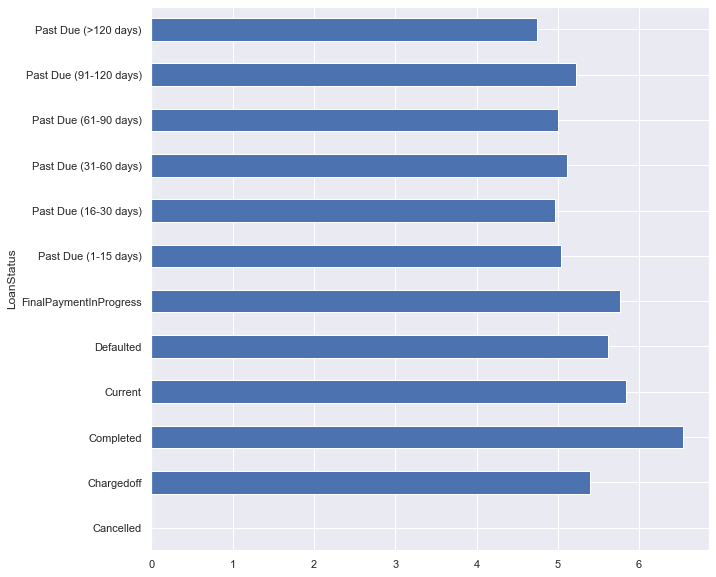

In [51]:
plt.figure(figsize=(10,10))
df_loans.groupby('LoanStatus')['ProsperScore'].mean().plot(kind='barh')

In [53]:
plt.figure(figsize=(10,10))
df_loans.groupby('LoanStatus')['ProsperScore'].describe()

,count,mean,std,min,25%,50%,75%,max
LoanStatus,,,,,,,,
Cancelled,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Chargedoff,5336.0,5.390742,2.152320,1.0,4.00,5.0,7.00,10.0
Completed,19651.0,6.537072,2.303758,1.0,5.00,7.0,8.00,11.0
Current,55730.0,5.840266,2.387903,1.0,4.00,6.0,8.00,11.0
Defaulted,1005.0,5.619901,2.207108,1.0,4.00,6.0,7.00,11.0
FinalPaymentInProgress,203.0,5.768473,2.475742,1.0,4.00,6.0,8.00,11.0
Past Due (1-15 days),800.0,5.041250,2.111309,1.0,3.00,5.0,7.00,11.0
Past Due (16-30 days),265.0,4.969811,2.154768,1.0,3.00,5.0,7.00,10.0
Past Due (31-60 days),361.0,5.108033,2.150447,1.0,3.00,5.0,7.00,10.0


<Figure size 720x720 with 0 Axes>

<AxesSubplot:>

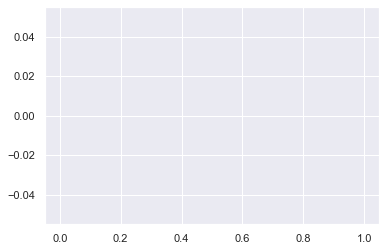

In [57]:
df_loans[df_loans['LoanStatus']=='Cancelled']['ProsperScore'].hist()

In [58]:
df_loans['LoanStatus'].value_counts()

Current                   55730
Completed                 38061
Chargedoff                11992
Defaulted                  5018
Past Due (1-15 days)        800
Past Due (31-60 days)       361
Past Due (61-90 days)       311
Past Due (91-120 days)      304
Past Due (16-30 days)       265
FinalPaymentInProgress      203
Past Due (>120 days)         16
Cancelled                     5
Name: LoanStatus, dtype: int64

In [59]:
data = reduce_mem_usage(pd.read_csv("loans_data_without_outliers.csv"))
data = data.drop('Unnamed: 0', axis=1)
data.info()

Memory usage of dataframe is 79.36 MB --> 38.17 MB (Decreased by 51.9%)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113066 entries, 0 to 113065
Data columns (total 91 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   ListingCreationDate                  113066 non-null  object 
 1   CreditGrade                          113066 non-null  object 
 2   Term                                 113066 non-null  int8   
 3   LoanStatus                           113066 non-null  object 
 4   ClosedDate                           55076 non-null   object 
 5   BorrowerAPR                          113066 non-null  float32
 6   BorrowerRate                         113066 non-null  float32
 7   LenderYield                          113066 non-null  float32
 8   EstimatedEffectiveYield              83982 non-null   float32
 9   EstimatedLoss                        83982 non-null   float32
 10  Estimate

In [60]:
date_cols = ["ListingCreationDate","FirstRecordedCreditLine","LoanOriginationDate","DateCreditPulled"]
for col in date_cols:
    data[col] = pd.to_datetime(data[col])
data['CreditScoreAverage'] = data['CreditScoreRangeLower'] + data['CreditScoreRangeUpper']
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113066 entries, 0 to 113065
Data columns (total 92 columns):
 #   Column                               Non-Null Count   Dtype         
---  ------                               --------------   -----         
 0   ListingCreationDate                  113066 non-null  datetime64[ns]
 1   CreditGrade                          113066 non-null  object        
 2   Term                                 113066 non-null  int8          
 3   LoanStatus                           113066 non-null  object        
 4   ClosedDate                           55076 non-null   object        
 5   BorrowerAPR                          113066 non-null  float32       
 6   BorrowerRate                         113066 non-null  float32       
 7   LenderYield                          113066 non-null  float32       
 8   EstimatedEffectiveYield              83982 non-null   float32       
 9   EstimatedLoss                        83982 non-null   float32       
 

### I will define the high risk loans is the loans which its prosper score is less than 5

In [61]:
data.groupby('LoanStatus')['ProsperScore'].describe()

,count,mean,std,min,25%,50%,75%,max
LoanStatus,,,,,,,,
Cancelled,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Chargedoff,5336.0,5.390742,2.152320,1.0,4.00,5.0,7.00,10.0
Completed,19651.0,6.537072,2.303758,1.0,5.00,7.0,8.00,11.0
Current,55730.0,5.840266,2.387903,1.0,4.00,6.0,8.00,11.0
Defaulted,1005.0,5.619901,2.207108,1.0,4.00,6.0,7.00,11.0
FinalPaymentInProgress,203.0,5.768473,2.475742,1.0,4.00,6.0,8.00,11.0
Past Due (1-15 days),800.0,5.041250,2.111309,1.0,3.00,5.0,7.00,11.0
Past Due (16-30 days),265.0,4.969811,2.154768,1.0,3.00,5.0,7.00,10.0
Past Due (31-60 days),361.0,5.108033,2.150447,1.0,3.00,5.0,7.00,10.0


<Figure size 1080x1080 with 0 Axes>

In [62]:
data['LoanStatus'].value_counts()

Current                   55730
Completed                 38061
Chargedoff                11992
Defaulted                  5018
Past Due (1-15 days)        800
Past Due (31-60 days)       361
Past Due (61-90 days)       311
Past Due (91-120 days)      304
Past Due (16-30 days)       265
FinalPaymentInProgress      203
Past Due (>120 days)         16
Cancelled                     5
Name: LoanStatus, dtype: int64

In [63]:
ana=['Current','Completed','Chargedoff','Defaulted']

<AxesSubplot:ylabel='LoanStatus'>

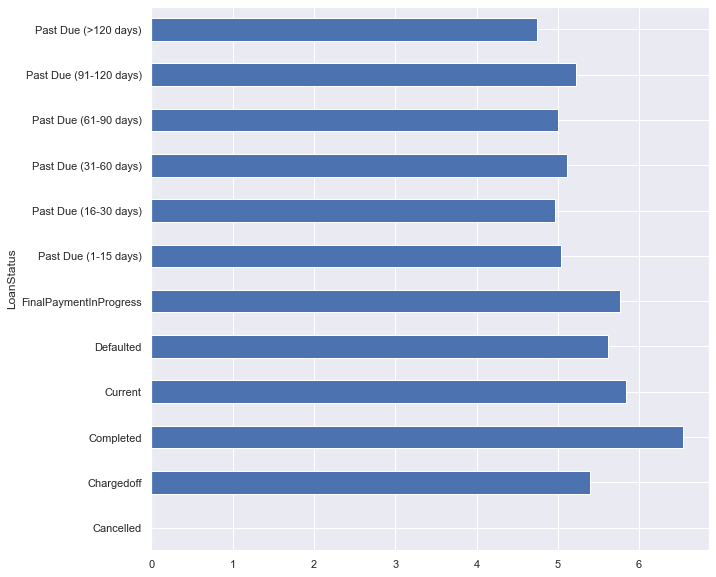

In [66]:
plt.figure(figsize=(10,10))
data.groupby('LoanStatus')['ProsperScore'].mean().plot(kind='barh')

No handles with labels found to put in legend.


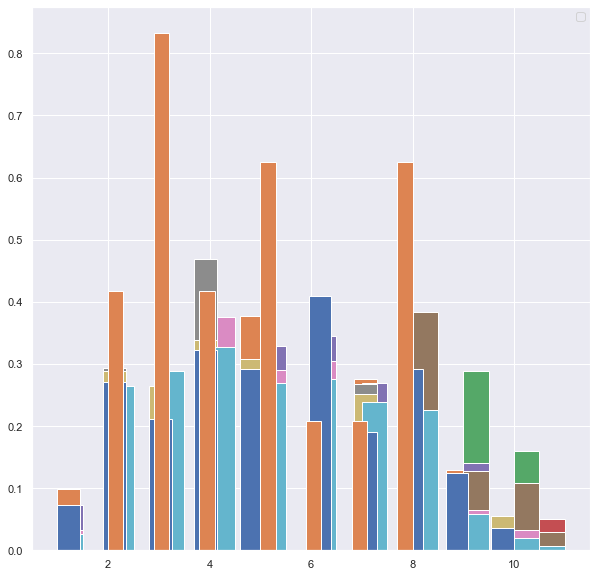

In [70]:
plt.figure(figsize=(10,10))
data.groupby('LoanStatus')['ProsperScore']

In [71]:
data['ProsperScore'][data['ProsperScore'] < 5].describe()

count    26660.000000
mean         3.181733
std          0.888720
min          1.000000
25%          3.000000
50%          3.000000
75%          4.000000
max          4.000000
Name: ProsperScore, dtype: float64

In [72]:
data['ProsperScore'][data['ProsperScore'] < 5.5].describe()

count    36392.000000
mean         3.667976
std          1.107112
min          1.000000
25%          3.000000
50%          4.000000
75%          5.000000
max          5.000000
Name: ProsperScore, dtype: float64

In [74]:
data['ProsperScore'][data['ProsperScore'] < 6.5].describe()

count    48553.000000
mean         4.252075
std          1.392799
min          1.000000
25%          3.000000
50%          4.000000
75%          6.000000
max          6.000000
Name: ProsperScore, dtype: float64

In [75]:
data['ProsperScore'][data['ProsperScore'] < 3.5].describe()

count    14217.000000
mean         2.465569
std          0.618022
min          1.000000
25%          2.000000
50%          3.000000
75%          3.000000
max          3.000000
Name: ProsperScore, dtype: float64

In [76]:
data['ProsperScore'][data['ProsperScore'] < 7.5].describe()

count    59042.000000
mean         4.740252
std          1.642894
min          1.000000
25%          4.000000
50%          5.000000
75%          6.000000
max          7.000000
Name: ProsperScore, dtype: float64

In [77]:
data['ProsperScore'][data['ProsperScore'] < 8.5].describe()

count    70995.000000
mean         5.289077
std          1.931273
min          1.000000
25%          4.000000
50%          5.000000
75%          7.000000
max          8.000000
Name: ProsperScore, dtype: float64

In [78]:
data['ProsperScore'][data['ProsperScore'] < 9.5].describe()

count    77860.000000
mean         5.616273
std          2.123728
min          1.000000
25%          4.000000
50%          6.000000
75%          7.000000
max          9.000000
Name: ProsperScore, dtype: float64

In [79]:
data['ProsperScore'][data['ProsperScore'] < 10.5].describe()

count    82551.000000
mean         5.865380
std          2.298621
min          1.000000
25%          4.000000
50%          6.000000
75%          8.000000
max         10.000000
Name: ProsperScore, dtype: float64

In [80]:
data['ProsperScore'][data['ProsperScore'] < 11.5].describe()

count    83982.000000
mean         5.952871
std          2.373517
min          1.000000
25%          4.000000
50%          6.000000
75%          8.000000
max         11.000000
Name: ProsperScore, dtype: float64

In [81]:
data['ProsperScore'][data['ProsperScore'] < 12.5].describe()

count    83982.000000
mean         5.952871
std          2.373517
min          1.000000
25%          4.000000
50%          6.000000
75%          8.000000
max         11.000000
Name: ProsperScore, dtype: float64

In [86]:
data['LoanStatus'][data['ProsperScore'].isnull()].value_counts(normalize=True)

Completed     0.632994
Chargedoff    0.228854
Defaulted     0.137980
Cancelled     0.000172
Name: LoanStatus, dtype: float64

In [87]:
data['ProsperScore'][data['LoanStatus'] == "Completed"].describe()

count    19651.000000
mean         6.537072
std          2.303758
min          1.000000
25%          5.000000
50%          7.000000
75%          8.000000
max         11.000000
Name: ProsperScore, dtype: float64

In [88]:
data['ProsperScore'][data['LoanStatus'] == "Chargedoff"].describe()

count    5336.000000
mean        5.390742
std         2.152320
min         1.000000
25%         4.000000
50%         5.000000
75%         7.000000
max        10.000000
Name: ProsperScore, dtype: float64

In [89]:
data['ProsperScore'][data['LoanStatus'] == "Defaulted"].describe()

count    1005.000000
mean        5.619901
std         2.207108
min         1.000000
25%         4.000000
50%         6.000000
75%         7.000000
max        11.000000
Name: ProsperScore, dtype: float64

In [90]:
data['ProsperScore'][data['LoanStatus'] == "Completed"].quantile(0.5)

7.0

In [91]:
data['LoanStatus'][data['ProsperScore'] < 5].value_counts(normalize=True)

Current                   0.730908
Completed                 0.153413
Chargedoff                0.067892
Past Due (1-15 days)      0.013391
Defaulted                 0.011290
Past Due (31-60 days)     0.005626
Past Due (61-90 days)     0.005289
Past Due (16-30 days)     0.004689
Past Due (91-120 days)    0.004501
FinalPaymentInProgress    0.002701
Past Due (>120 days)      0.000300
Name: LoanStatus, dtype: float64

In [92]:
data['ProsperScore'][data['LoanStatus'] == "FinalPaymentInProgress"].describe()

count    203.000000
mean       5.768473
std        2.475742
min        1.000000
25%        4.000000
50%        6.000000
75%        8.000000
max       11.000000
Name: ProsperScore, dtype: float64

In [98]:
data['ProsperScore'][data['LoanStatus'] == "Completed"].fillna(data['ProsperScore'][data['LoanStatus'] == "Completed"].quantile(0.5), inplace=True)

In [99]:
data['ProsperScore'][data['LoanStatus'] == "Chargedoff"].fillna(data['ProsperScore'][data['LoanStatus'] == "Chargedoff"].quantile(0.5), inplace=True)

In [100]:
data['ProsperScore'][data['LoanStatus'] == "Cancelled"].fillna(2, inplace=True)

In [101]:
data['ProsperScore'].isnull().sum()

29084

In [102]:
data['LoanStatus'][data['ProsperScore'].isnull()].value_counts(normalize=True)

Completed     0.632994
Chargedoff    0.228854
Defaulted     0.137980
Cancelled     0.000172
Name: LoanStatus, dtype: float64

In [103]:
data['LoanStatus'].isnull().iloc[5]

False

In [106]:
for i in range(data.shape[0]):
    if (data['LoanStatus'].iloc[i] == "Cancelled") & (data['ProsperScore'].isnull().iloc[i] == True) :
        data['ProsperScore'].iloc[i] = 3
        
    elif (data['LoanStatus'].iloc[i] == "Defaulted") & (data['ProsperScore'].isnull().iloc[i] == True) :
        data['ProsperScore'].iloc[i] = 6
        
    elif (data['LoanStatus'].iloc[i] == "Chargedoff") & (data['ProsperScore'].isnull().iloc[i] == True) :
        data['ProsperScore'].iloc[i] = 5
        
    elif (data['LoanStatus'].iloc[i] == "Completed") & (data['ProsperScore'].isnull().iloc[i] == True) :
        data['ProsperScore'].iloc[i] = 7

data['ProsperScore'].isnull().sum()

0

In [107]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113066 entries, 0 to 113065
Data columns (total 92 columns):
 #   Column                               Non-Null Count   Dtype         
---  ------                               --------------   -----         
 0   ListingCreationDate                  113066 non-null  datetime64[ns]
 1   CreditGrade                          113066 non-null  object        
 2   Term                                 113066 non-null  int8          
 3   LoanStatus                           113066 non-null  object        
 4   ClosedDate                           55076 non-null   object        
 5   BorrowerAPR                          113066 non-null  float32       
 6   BorrowerRate                         113066 non-null  float32       
 7   LenderYield                          113066 non-null  float32       
 8   EstimatedEffectiveYield              83982 non-null   float32       
 9   EstimatedLoss                        83982 non-null   float32       
 

In [108]:
data['DebtToIncomeRatio'].describe()

count    104594.000000
mean          0.250554
std           0.187302
min           0.000000
25%           0.140000
50%           0.220000
75%           0.320000
max           1.937296
Name: DebtToIncomeRatio, dtype: float64

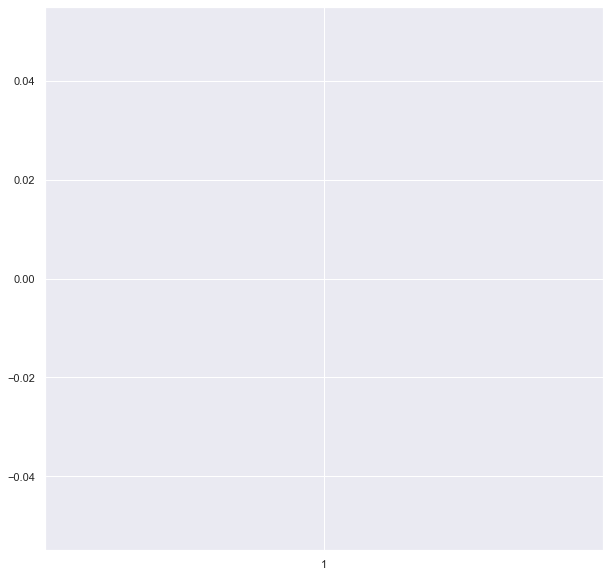

In [109]:
plt.figure(figsize=(10,10))
plt.boxplot(data['DebtToIncomeRatio'])
plt.show()

<AxesSubplot:>

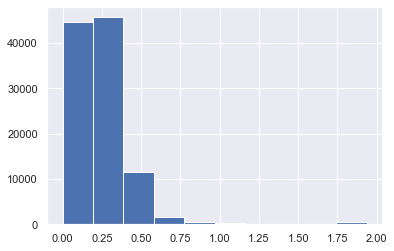

In [110]:
data['DebtToIncomeRatio'].hist()

In [111]:
con_features

['BorrowerAPR',
 'BorrowerRate',
 'LenderYield',
 'EstimatedEffectiveYield',
 'EstimatedLoss',
 'EstimatedReturn',
 'ProsperRating (numeric)',
 'ProsperScore',
 'EmploymentStatusDuration',
 'CreditScoreRangeLower',
 'CreditScoreRangeUpper',
 'CurrentCreditLines',
 'OpenCreditLines',
 'TotalCreditLinespast7years',
 'OpenRevolvingMonthlyPayment',
 'InquiriesLast6Months',
 'TotalInquiries',
 'CurrentDelinquencies',
 'AmountDelinquent',
 'DelinquenciesLast7Years',
 'PublicRecordsLast10Years',
 'PublicRecordsLast12Months',
 'RevolvingCreditBalance',
 'BankcardUtilization',
 'AvailableBankcardCredit',
 'TotalTrades',
 'TradesNeverDelinquent (percentage)',
 'TradesOpenedLast6Months',
 'DebtToIncomeRatio',
 'StatedMonthlyIncome',
 'TotalProsperLoans',
 'TotalProsperPaymentsBilled',
 'OnTimeProsperPayments',
 'ProsperPaymentsLessThanOneMonthLate',
 'ProsperPaymentsOneMonthPlusLate',
 'ProsperPrincipalBorrowed',
 'ProsperPrincipalOutstanding',
 'ScorexChangeAtTimeOfListing',
 'LoanFirstDefaulted

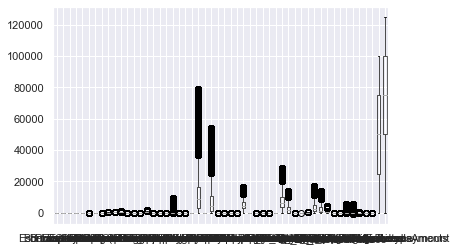

In [112]:
std = data[con_features].std()
mean = data[con_features].mean()
cut_off = std * 3
lower, upper = mean - cut_off, mean + cut_off
trimmed_df = data[(data[con_features] < upper) & (data[con_features] > lower)]
trimmed_df[con_features].boxplot()
plt.show()

In [113]:
mask_up = (data[con_features] > upper) 
mask_down =(data[con_features] < lower)

In [114]:
df=data.copy()

In [115]:
for col in con_features:
    for i in range(data.shape[0]):
        if mask_up[col].iloc[i] == True:
            df[col].iloc[i] = upper[col]
        elif mask_down[col].iloc[i] == True:
            df[col].iloc[i] = lower[col]


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [116]:
df['DebtToIncomeRatio'].describe()

count    104594.000000
mean          0.243567
std           0.142688
min           0.000000
25%           0.140000
50%           0.220000
75%           0.320000
max           0.812459
Name: DebtToIncomeRatio, dtype: float64

In [117]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113066 entries, 0 to 113065
Data columns (total 92 columns):
 #   Column                               Non-Null Count   Dtype         
---  ------                               --------------   -----         
 0   ListingCreationDate                  113066 non-null  datetime64[ns]
 1   CreditGrade                          113066 non-null  object        
 2   Term                                 113066 non-null  int8          
 3   LoanStatus                           113066 non-null  object        
 4   ClosedDate                           55076 non-null   object        
 5   BorrowerAPR                          113066 non-null  float32       
 6   BorrowerRate                         113066 non-null  float32       
 7   LenderYield                          113066 non-null  float32       
 8   EstimatedEffectiveYield              83982 non-null   float32       
 9   EstimatedLoss                        83982 non-null   float32       
 

In [118]:
df['DebtToIncomeRatio'].fillna( 0.22 ,inplace=True)

In [119]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113066 entries, 0 to 113065
Data columns (total 92 columns):
 #   Column                               Non-Null Count   Dtype         
---  ------                               --------------   -----         
 0   ListingCreationDate                  113066 non-null  datetime64[ns]
 1   CreditGrade                          113066 non-null  object        
 2   Term                                 113066 non-null  int8          
 3   LoanStatus                           113066 non-null  object        
 4   ClosedDate                           55076 non-null   object        
 5   BorrowerAPR                          113066 non-null  float32       
 6   BorrowerRate                         113066 non-null  float32       
 7   LenderYield                          113066 non-null  float32       
 8   EstimatedEffectiveYield              83982 non-null   float32       
 9   EstimatedLoss                        83982 non-null   float32       
 

In [131]:
df['high_risk'] = None
for i in range(df.shape[0]):
    if df['ProsperScore'].iloc[i] < 5.5:
        df['high_risk'].iloc[i]=1
    else:
        df['high_risk'].iloc[i]=0
df['high_risk'] = df['high_risk'].astype('int8')
df.info()


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113066 entries, 0 to 113065
Data columns (total 93 columns):
 #   Column                               Non-Null Count   Dtype         
---  ------                               --------------   -----         
 0   ListingCreationDate                  113066 non-null  datetime64[ns]
 1   CreditGrade                          113066 non-null  object        
 2   Term                                 113066 non-null  int8          
 3   LoanStatus                           113066 non-null  object        
 4   ClosedDate                           55076 non-null   object        
 5   BorrowerAPR                          113066 non-null  float32       
 6   BorrowerRate                         113066 non-null  float32       
 7   LenderYield                          113066 non-null  float32       
 8   EstimatedEffectiveYield              83982 non-null   float32       
 9   EstimatedLoss                        83982 non-null   float32       
 

In [132]:
df['ProsperRating (numeric)'].describe()

count    83982.000000
mean         4.068705
std          1.675635
min          1.000000
25%          3.000000
50%          4.000000
75%          5.000000
max          7.000000
Name: ProsperRating (numeric), dtype: float64

In [133]:
df['EstimatedEffectiveYield'].describe()

count    83982.000000
mean         0.168941
std          0.068433
min         -0.036363
25%          0.116000
50%          0.161620
75%          0.225300
max          0.319900
Name: EstimatedEffectiveYield, dtype: float64

In [134]:
df['EstimatedLoss'].describe()

count    83982.000000
mean         0.080167
std          0.045805
min          0.004900
25%          0.042400
50%          0.072400
75%          0.112000
max          0.217711
Name: EstimatedLoss, dtype: float64

In [135]:
df['EstimatedReturn'].describe()

count    83982.000000
mean         0.096338
std          0.029768
min          0.006957
25%          0.074630
50%          0.092110
75%          0.117100
max          0.185714
Name: EstimatedReturn, dtype: float64

In [137]:
data['ProsperRating (Alpha)'].mode()[0]

'C'

In [136]:
df['ProsperRating (numeric)'].fillna(df['ProsperRating (numeric)'].median(), inplace = True)
df['ProsperRating (Alpha)'].fillna(df['ProsperRating (Alpha)'].mode()[0], inplace = True)
df['EstimatedEffectiveYield'].fillna(df['EstimatedEffectiveYield'].median(), inplace = True)
df['EstimatedLoss'].fillna(df['EstimatedLoss'].median(), inplace = True)
df['EstimatedReturn'].fillna(df['EstimatedReturn'].median(), inplace = True)

In [138]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113066 entries, 0 to 113065
Data columns (total 93 columns):
 #   Column                               Non-Null Count   Dtype         
---  ------                               --------------   -----         
 0   ListingCreationDate                  113066 non-null  datetime64[ns]
 1   CreditGrade                          113066 non-null  object        
 2   Term                                 113066 non-null  int8          
 3   LoanStatus                           113066 non-null  object        
 4   ClosedDate                           55076 non-null   object        
 5   BorrowerAPR                          113066 non-null  float32       
 6   BorrowerRate                         113066 non-null  float32       
 7   LenderYield                          113066 non-null  float32       
 8   EstimatedEffectiveYield              113066 non-null  float32       
 9   EstimatedLoss                        113066 non-null  float32       
 

In [139]:
df.to_csv('final_prosper_dataset.csv')

In [140]:
df.dropna(axis=1).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113066 entries, 0 to 113065
Data columns (total 82 columns):
 #   Column                              Non-Null Count   Dtype         
---  ------                              --------------   -----         
 0   ListingCreationDate                 113066 non-null  datetime64[ns]
 1   CreditGrade                         113066 non-null  object        
 2   Term                                113066 non-null  int8          
 3   LoanStatus                          113066 non-null  object        
 4   BorrowerAPR                         113066 non-null  float32       
 5   BorrowerRate                        113066 non-null  float32       
 6   LenderYield                         113066 non-null  float32       
 7   EstimatedEffectiveYield             113066 non-null  float32       
 8   EstimatedLoss                       113066 non-null  float32       
 9   EstimatedReturn                     113066 non-null  float32       
 10  ProsperR

In [144]:
pd.get_dummies(df,columns=['LoanStatus'])[['LoanStatus_Completed','high_risk']]

,LoanStatus_Completed,high_risk
0,1,0
1,0,0
2,1,0
3,0,0
4,0,1
...,...,...
113061,0,1
113062,0,0
113063,0,1
113064,1,1


In [146]:
new_df = pd.get_dummies(df.dropna(axis=1),columns=['LoanStatus'])
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113066 entries, 0 to 113065
Data columns (total 93 columns):
 #   Column                              Non-Null Count   Dtype         
---  ------                              --------------   -----         
 0   ListingCreationDate                 113066 non-null  datetime64[ns]
 1   CreditGrade                         113066 non-null  object        
 2   Term                                113066 non-null  int8          
 3   BorrowerAPR                         113066 non-null  float32       
 4   BorrowerRate                        113066 non-null  float32       
 5   LenderYield                         113066 non-null  float32       
 6   EstimatedEffectiveYield             113066 non-null  float32       
 7   EstimatedLoss                       113066 non-null  float32       
 8   EstimatedReturn                     113066 non-null  float32       
 9   ProsperRating (numeric)             113066 non-null  float32       
 10  ProsperR

In [147]:
new_df.to_csv('final2_prosper_dataset.csv')

In [149]:
new_df.drop(date_cols,axis=1).drop('LoanKey',axis=1)

,CreditGrade,Term,BorrowerAPR,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperRating (numeric),ProsperRating (Alpha),...,LoanStatus_Completed,LoanStatus_Current,LoanStatus_Defaulted,LoanStatus_FinalPaymentInProgress,LoanStatus_Past Due (1-15 days),LoanStatus_Past Due (16-30 days),LoanStatus_Past Due (31-60 days),LoanStatus_Past Due (61-90 days),LoanStatus_Past Due (91-120 days),LoanStatus_Past Due (>120 days)
0,C,36,0.16516,0.1580,0.1380,0.16162,0.0724,0.09211,4.0,C,...,1,0,0,0,0,0,0,0,0,0
1,Not_Applicable,36,0.12016,0.0920,0.0820,0.07960,0.0249,0.05470,6.0,A,...,0,1,0,0,0,0,0,0,0,0
2,HR,36,0.28269,0.2750,0.2400,0.16162,0.0724,0.09211,4.0,C,...,1,0,0,0,0,0,0,0,0,0
3,Not_Applicable,36,0.12528,0.0974,0.0874,0.08490,0.0249,0.06000,6.0,A,...,0,1,0,0,0,0,0,0,0,0
4,Not_Applicable,36,0.24614,0.2085,0.1985,0.18316,0.0925,0.09066,3.0,D,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113061,Not_Applicable,36,0.22354,0.1864,0.1764,0.16490,0.0699,0.09500,4.0,C,...,0,1,0,0,0,0,0,0,0,0
113062,Not_Applicable,36,0.13220,0.1110,0.1010,0.10070,0.0200,0.08070,6.0,A,...,0,0,0,1,0,0,0,0,0,0
113063,Not_Applicable,60,0.23984,0.2150,0.2050,0.18828,0.1025,0.08578,3.0,D,...,0,1,0,0,0,0,0,0,0,0
113064,Not_Applicable,60,0.28408,0.2605,0.2505,0.24450,0.0850,0.15950,4.0,C,...,1,0,0,0,0,0,0,0,0,0


In [154]:
[col for col in new_df.drop('LoanKey',axis=1).columns if 'O' == new_df[col].dtype]

['CreditGrade',
 'ProsperRating (Alpha)',
 'BorrowerState',
 'Occupation',
 'EmploymentStatus',
 'IncomeRange']

In [155]:
pd.get_dummies(new_df.drop(date_cols,axis=1).drop('LoanKey',axis=1),columns=[col for col in new_df.drop(date_cols,axis=1).drop('LoanKey',axis=1).columns if 'O' == new_df[col].dtype])

,Term,BorrowerAPR,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperRating (numeric),ProsperScore,ListingCategory (numeric),...,EmploymentStatus_Retired,EmploymentStatus_Self-employed,IncomeRange_$0,"IncomeRange_$1-24,999","IncomeRange_$100,000+","IncomeRange_$25,000-49,999","IncomeRange_$50,000-74,999","IncomeRange_$75,000-99,999",IncomeRange_Not displayed,IncomeRange_Not employed
0,36,0.16516,0.1580,0.1380,0.16162,0.0724,0.09211,4.0,7.0,0,...,0,1,0,0,0,1,0,0,0,0
1,36,0.12016,0.0920,0.0820,0.07960,0.0249,0.05470,6.0,7.0,2,...,0,0,0,0,0,0,1,0,0,0
2,36,0.28269,0.2750,0.2400,0.16162,0.0724,0.09211,4.0,7.0,0,...,0,0,0,0,0,0,0,0,1,0
3,36,0.12528,0.0974,0.0874,0.08490,0.0249,0.06000,6.0,9.0,16,...,0,0,0,0,0,1,0,0,0,0
4,36,0.24614,0.2085,0.1985,0.18316,0.0925,0.09066,3.0,4.0,2,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113061,36,0.22354,0.1864,0.1764,0.16490,0.0699,0.09500,4.0,5.0,1,...,0,0,0,0,0,0,1,0,0,0
113062,36,0.13220,0.1110,0.1010,0.10070,0.0200,0.08070,6.0,8.0,7,...,0,0,0,0,0,0,0,1,0,0
113063,60,0.23984,0.2150,0.2050,0.18828,0.1025,0.08578,3.0,3.0,1,...,0,0,0,0,0,1,0,0,0,0
113064,60,0.28408,0.2605,0.2505,0.24450,0.0850,0.15950,4.0,5.0,2,...,0,0,0,0,0,1,0,0,0,0
